# Ciência de Dados em Larga Escala
# Trabalho Prático - Performance Analysis
## Lara Sousa e Mariana Serrão

## Notebook 2 - Índice:
- Exploração das bibliotecas de Big Data: Modin e Joblib. Desta forma, vamos recriar o estudo, mas alterando a implementação para uma abordagem usando essas bibliotecas.
- Resumo dos Resultados do Notebook 1 (Dask e Koalas), Notebook 2 (Dask + Modin e Joblib) e Notebook 3 (Rapids)
- Comparação de Desempenho em termos dos tempos de execução
- Observações e conclusões finais.

#### Neste Notebook
- Pretende-se explorar as bibliotecas de Big Data: Modin e Joblib. Desta forma, vamos recriar o estudo, mas alterando a implementação para uma abordagem usando essas bibliotecas.
- O notebok está dividido em duas partes:
    - uma primeira parte destinada ao estudo para uma amostra do dataset original redimido a um único file: o primeiro mês de 2009;
    - uma segunda parte onde se repete duas e três amostras do dataset orginal, reduzindo a dois e três files, respetivamente: o segundo e o terceiro mêss de 2009


### Bibliotecas

Instalou-se e importou-se as bibliotecas necessárias.

In [1]:
# Importing required packages
import pandas as pd
import pyspark
import pyarrow
import numpy as np
import os
import requests
import time
import modin.pandas as md
from dask.distributed import Client, LocalCluster
import numpy as np
import modin.config as cfg
from joblib import parallel_backend, Parallel, delayed
import pandas as pd
import numpy as np
import time
from joblib import Parallel, delayed, dump, load

import dask.dataframe as dd
# Check versions
print("pandas version:", pd.__version__)
print("pyspark version:", pyspark.__version__)
print("pyarrow version:", pyarrow.__version__)
print("numpy version:", np.__version__)
print("modin version:", md.__version__)
import joblib
print("joblib version:", joblib.__version__)

pandas version: 1.3.5
pyspark version: 3.4.3
pyarrow version: 11.0.0
numpy version: 1.21.6
modin version: 0.12.1
joblib version: 1.3.2


In [2]:
# Configurar Modin para usar Dask
cfg.Engine.put("dask")

In [3]:
client = Client()

2024-06-06 15:48:40,990 - distributed.nanny - WARNING - Restarting worker
2024-06-06 15:48:41,023 - distributed.nanny - WARNING - Restarting worker
2024-06-06 15:48:41,027 - distributed.nanny - WARNING - Restarting worker
2024-06-06 15:48:41,075 - distributed.nanny - WARNING - Restarting worker


## Dask + Modin

Carregou-se o primeiro mês do ano de 2009 (`parquet_file`) para um dataframe Modin (`modin data`). A este dataframe aplicou-se `lower`para renomear as colunas para minúsculas.

In [4]:
# Carregar os arquivos Parquet em DataFrame Modin
parquet_file = 'Ficheiros/taxi_csv/yellow_tripdata_2009-01.parquet'
modin_data = pd.read_parquet(parquet_file)

# Renomear colunas para minúsculas
modin_data = modin_data.rename(columns=str.lower)

# Exibir colunas do DataFrame
print(modin_data.columns)


Index(['vendor_name', 'trip_pickup_datetime', 'trip_dropoff_datetime',
       'passenger_count', 'trip_distance', 'start_lon', 'start_lat',
       'rate_code', 'store_and_forward', 'end_lon', 'end_lat', 'payment_type',
       'fare_amt', 'surcharge', 'mta_tax', 'tip_amt', 'tolls_amt',
       'total_amt'],
      dtype='object')


**Definiu-se as funções benchmarks, onde cada uma corresponde a uma operação, à qual pretendemos medir e avaliar o seu tempo de execução:**
- Contagem (`count`)
- Contagem do comprimento do índice (`count_index_length`)
- Cálculo da média (`mean`)
- Cálculo do desvio padrão (`standard_deviation`)
- Média da soma de colunas (`mean_of_sum`)
- Soma de colunas (`sum_columns`)
- Média do produto de colunas (`mean_of_product`)
- Produto de colunas (`product_columns`)
- Operações aritméticas complexas (`complicated_arithmetic_operation`)
- Contagem de valores (`value_counts`)
- Estatísticas de agrupamento (`groupby_statistics`)

In [5]:
def get_results(benchmarks):
    """Retorna um DataFrame pandas contendo os resultados dos benchmarks"""
    return pd.DataFrame.from_dict(benchmarks)

# Funções de operações
def read_file_parquet(df=None):
    return pd.read_parquet(parquet_file)

def count(df):
    return len(df)

def count_index_length(df):
    return len(df.index)

def mean(df):
    return df['fare_amt'].mean()

def standard_deviation(df):
    return df['fare_amt'].std()

def mean_of_sum(df):
    return (df['fare_amt'] + df['tip_amt']).mean()

def sum_columns(df):
    return (df['fare_amt'] + df['tip_amt']).sum()

def mean_of_product(df):
    return (df['fare_amt'] * df['tip_amt']).mean()

def product_columns(df):
    return (df['fare_amt'] * df['tip_amt']).sum()

def value_counts(df):
    return df['fare_amt'].value_counts()

def complicated_arithmetic_operation(df):
    theta_1 = df['start_lon']
    phi_1 = df['start_lat']
    theta_2 = df['end_lon']
    phi_2 = df['end_lat']
    temp = (np.sin((theta_2 - theta_1) / 2 * np.pi / 180) ** 2
           + np.cos(theta_1 * np.pi / 180) * np.cos(theta_2 * np.pi / 180)
           * np.sin((phi_2 - phi_1) / 2 * np.pi / 180) ** 2)
    ret = 2 * np.arctan2(np.sqrt(temp), np.sqrt(1 - temp))
    return ret.mean()

def groupby_statistics(df):
    return df.groupby(by='passenger_count').agg({
        'fare_amt': ['mean', 'std'], 
        'tip_amt': ['mean', 'std']
    })

def join_count(df, other):
    return len(df.merge(other, left_index=True, right_index=True))

def join_data(df, other):
    return df.merge(other, left_index=True, right_index=True)


**Função Benchmark**

- Predende-se medir a duração da execução das funções acima definidas.

In [6]:
def benchmark(f, df, benchmarks, name, **kwargs):
    """Benchmark the given function against the given DataFrame.
    
    Parameters
    ----------
    f: function to benchmark
    df: data frame
    benchmarks: container for benchmark results
    name: task name
    
    Returns
    -------
    Duration (in seconds) of the given operation
    """
    start_time = time.time()
    ret = f(df, **kwargs)
    benchmarks['duration'].append(time.time() - start_time)
    benchmarks['task'].append(name)
    print(f"{name} took: {benchmarks['duration'][-1]} seconds")
    return benchmarks['duration'][-1]
 
def get_results(benchmarks):
    """Return a pandas DataFrame containing benchmark results."""
    return pd.DataFrame.from_dict(benchmarks)

## Standard Operations

**Inicialização dos dicionários para armazenar os resultados dos benchmarks para a biblioteca Modin, com um só ficheiro**

In [7]:
# Inicializar dicionários para armazenar resultados dos benchmarks
modin_benchmarks = {'duration': [], 'task': []}

**Resultado das Benchmarks**
Verifica-se que a operação standard mais rápida é `count index length took: 2.86102294921875e-06 seconds`. Em contrapartida a que leva mais tempo a executar: `complex arithmetic ops took: 1.244403600692749 seconds`.


In [8]:
# Executar benchmarks nas operações 
benchmark(read_file_parquet, df=None, benchmarks=modin_benchmarks, name='read file')
benchmark(count, df=modin_data, benchmarks=modin_benchmarks, name='count')
benchmark(count_index_length, df=modin_data, benchmarks=modin_benchmarks, name='count index length')
benchmark(mean, df=modin_data, benchmarks=modin_benchmarks, name='mean')
benchmark(standard_deviation, df=modin_data, benchmarks=modin_benchmarks, name='standard deviation')
benchmark(mean_of_sum, df=modin_data, benchmarks=modin_benchmarks, name='mean of columns addition')
benchmark(sum_columns, df=modin_data, benchmarks=modin_benchmarks, name='addition of columns')
benchmark(mean_of_product, df=modin_data, benchmarks=modin_benchmarks, name='mean of columns multiplication')
benchmark(product_columns, df=modin_data, benchmarks=modin_benchmarks, name='multiplication of columns')
benchmark(value_counts, df=modin_data, benchmarks=modin_benchmarks, name='value counts')
benchmark(complicated_arithmetic_operation, df=modin_data, benchmarks=modin_benchmarks, name='complex arithmetic ops')
benchmark(groupby_statistics, df=modin_data, benchmarks=modin_benchmarks, name='groupby statistics')


read file took: 12.005631923675537 seconds
count took: 2.09808349609375e-05 seconds
count index length took: 1.9073486328125e-06 seconds
mean took: 0.022788524627685547 seconds
standard deviation took: 0.08030867576599121 seconds
mean of columns addition took: 0.03961825370788574 seconds
addition of columns took: 0.03165149688720703 seconds
mean of columns multiplication took: 0.0395965576171875 seconds
multiplication of columns took: 0.04042792320251465 seconds
value counts took: 0.17320036888122559 seconds
complex arithmetic ops took: 1.2699618339538574 seconds
groupby statistics took: 0.3963429927825928 seconds


0.3963429927825928

### Salvar os Resultados

In [9]:
# Obter os resultados e remover duplicatas
modin_res_temp = get_results(modin_benchmarks).drop_duplicates(subset='task').set_index('task')

# Print dos dataframes
print(modin_res_temp)

# Definir o nome do arquivo ou diretório
filename = 'Resultados/modin_standard1'

# Salvar o DataFrame em formato Parquet
modin_res_temp.to_parquet(filename)

print(f'O arquivo Parquet foi salvo em {filename}.')

                                 duration
task                                     
read file                       12.005632
count                            0.000021
count index length               0.000002
mean                             0.022789
standard deviation               0.080309
mean of columns addition         0.039618
addition of columns              0.031651
mean of columns multiplication   0.039597
multiplication of columns        0.040428
value counts                     0.173200
complex arithmetic ops           1.269962
groupby statistics               0.396343
O arquivo Parquet foi salvo em Resultados/modin_standard1.


## Measuring using CProfile

**cProfile** é um módulo integrado do Python utilizado para medir o desempenho de programas, que permite analisar o tempo gasto em cada função, identificando gargalos e oportunidades de otimização. O cProfile gera dados detalhados que podem ser usados para entender melhor o comportamento do código e melhorar a sua eficiência.

Neste relatório, utilizamos o `cProfile` para analisar e otimizar um conjunto de operações realizadas num DataFrame carregado a partir de um arquivo Parquet. O código foi executado num Jupyter Notebook, e as etapas principais incluíram a **execução das operações** e a **coleta de dados de profiling**.



In [10]:
import cProfile
import matplotlib.pyplot as plt
from io import StringIO
import pstats

**Função de Benchmarking com cProfile:**

Desenvolveu-se uma função de benchmarking (`benchmark_with_cprofile`) que mede a duração da execução de cada operação e utiliza o cProfile para coletar dados detalhados sobre o desempenho.

In [11]:
# Define your benchmark function to use cProfile
def benchmark_with_cprofile(f, df, benchmarks, name, **kwargs):
    """Mede a duração da execução de uma função específica usando cProfile"""
    pr = cProfile.Profile()
    pr.enable()
    
    start_time = time.time()
    ret = f(df, **kwargs)
    benchmarks['duration'].append(time.time() - start_time)
    benchmarks['task'].append(name)
    print(f"{name} took: {benchmarks['duration'][-1]} seconds")
    
    pr.disable()
    pr.print_stats(sort='cumtime')  # Print profiling results sorted by cumulative time
    
    return benchmarks['duration'][-1]

**Executando as benchmarks para a biblioteca Modin + Dask em operações standard, usando CProfile**

In [12]:
# Initialize dictionaries to store benchmark results
modin_benchmarks_cprofile = {'duration': [], 'task': []}

# Execute benchmarks on operations with cProfile
benchmark_with_cprofile(read_file_parquet, df=None, benchmarks=modin_benchmarks_cprofile, name='read file')
benchmark_with_cprofile(count, df=modin_data, benchmarks=modin_benchmarks_cprofile, name='count')
benchmark_with_cprofile(count_index_length, df=modin_data, benchmarks=modin_benchmarks_cprofile, name='count index length')
benchmark_with_cprofile(mean, df=modin_data, benchmarks=modin_benchmarks_cprofile, name='mean')
benchmark_with_cprofile(standard_deviation, df=modin_data, benchmarks=modin_benchmarks_cprofile, name='standard deviation')
benchmark_with_cprofile(mean_of_sum, df=modin_data, benchmarks=modin_benchmarks_cprofile, name='mean of columns addition')
benchmark_with_cprofile(sum_columns, df=modin_data, benchmarks=modin_benchmarks_cprofile, name='addition of columns')
benchmark_with_cprofile(mean_of_product, df=modin_data, benchmarks=modin_benchmarks_cprofile, name='mean of columns multiplication')
benchmark_with_cprofile(product_columns, df=modin_data, benchmarks=modin_benchmarks_cprofile, name='multiplication of columns')
benchmark_with_cprofile(value_counts, df=modin_data, benchmarks=modin_benchmarks_cprofile, name='value counts')
benchmark_with_cprofile(complicated_arithmetic_operation, df=modin_data, benchmarks=modin_benchmarks_cprofile, name='complex arithmetic ops')
benchmark_with_cprofile(groupby_statistics, df=modin_data, benchmarks=modin_benchmarks_cprofile, name='groupby statistics')


read file took: 12.862229108810425 seconds
         2102 function calls (1949 primitive calls) in 12.862 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   12.862   12.862 1601532002.py:6(read_file_parquet)
        1    0.000    0.000   12.862   12.862 parquet.py:433(read_parquet)
        1    0.001    0.001   12.862   12.862 parquet.py:201(read)
        1    0.000    0.000    7.764    7.764 {method 'to_pandas' of 'pyarrow.lib._PandasConvertible' objects}
        1    0.000    0.000    7.764    7.764 pandas_compat.py:797(table_to_blockmanager)
        1    0.000    0.000    7.762    7.762 pandas_compat.py:1164(_table_to_blocks)
        1    7.762    7.762    7.762    7.762 {pyarrow.lib.table_to_blocks}
        1    0.000    0.000    5.097    5.097 core.py:2909(read_table)
        1    0.000    0.000    5.096    5.096 core.py:2533(read)
        1    5.096    5.096    5.096    5.096 {method 'to_ta

0.40862226486206055

Armazenou-se os resultados dos benchmarks num DataFrame pandas.
Utilizou-se a biblioteca `matplotlib` para criar vários gráficos, mostrando o tempo de execução de cada operação.

In [22]:
# Convert benchmark results to DataFrame
results_modin = pd.DataFrame.from_dict(modin_benchmarks_cprofile)

### Gráfico de Barras

**Descrição:** Este gráfico de barras horizontal mostra a duração de cada tarefa em segundos. As barras representam visualmente o tempo gasto em cada operação realizada no DataFrame.



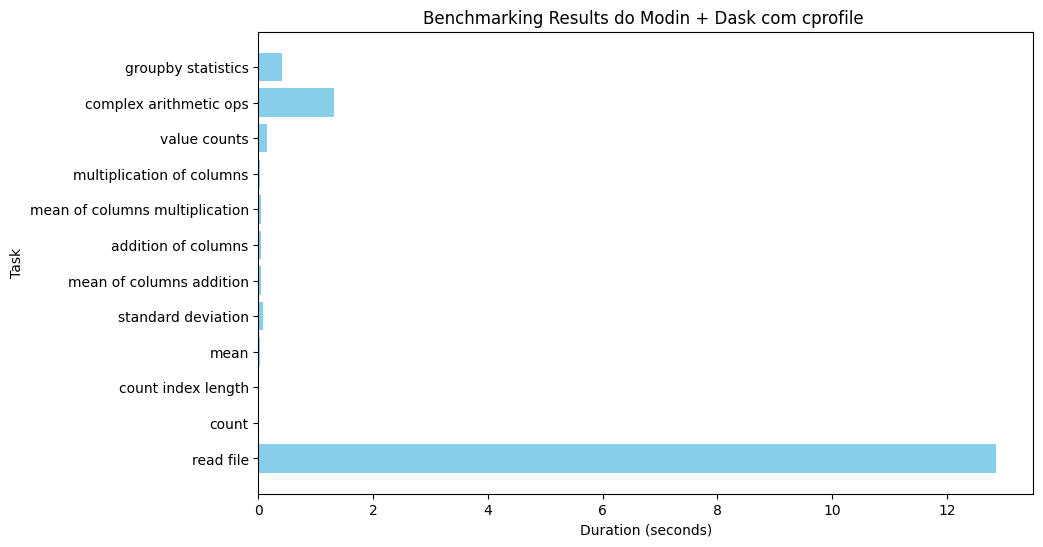

In [23]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.barh(results_modin['task'], results_modin['duration'], color='skyblue')
plt.xlabel('Duration (seconds)')
plt.ylabel('Task')
plt.title('Benchmarking Results do Modin + Dask com cprofile ')
plt.show()

**Análise:**

- A operação de leitura do arquivo (`read file`) é a mais demorada, com uma duração de aproximadamente 13 segundos, destacando-se significativamente das outras operações;
- Outras operações, como `complex arithmetic ops` e `groupby statistics`, têm durações perceptíveis, mas são muito menores em comparação à leitura do arquivo;
- A maioria das outras operações tem tempos de execução muito pequenos, praticamente insignificantes quando comparados à leitura do arquivo.


### Gráfico de Pizza

**Descrição:** Este gráfico de pizza representa a proporção de tempo gasto em cada tarefa. As percentagens são mostradas ao lado das etiquetas na legenda.



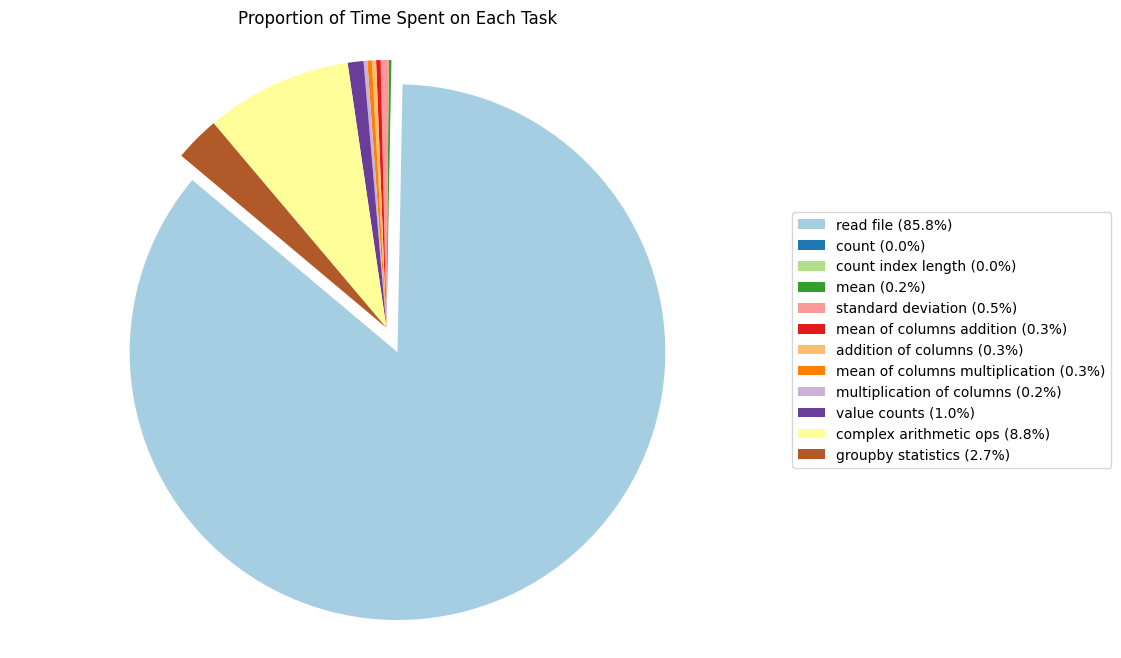

In [24]:
# Calcular percentagens
percentages = [f"{(d / sum(results_modin['duration']) * 100):.1f}%" for d in results_modin['duration']]
legend_labels = [f"{task} ({percentage})" for task, percentage in zip(results_modin['task'], percentages)]

# Gráfico de Pizza sem rótulos nas fatias
explode = [0.1 if i == 0 else 0 for i in range(len(results_modin['duration']))]

plt.figure(figsize=(10, 8))
plt.pie(results_modin['duration'], startangle=140, colors=plt.cm.Paired.colors,
        explode=explode, pctdistance=0.85, labeldistance=1.1)

# Garantir que os rótulos não se sobreponham
plt.axis('equal')
plt.title('Proportion of Time Spent on Each Task')
plt.legend(legend_labels, loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()



**Análise:**

- A operação de leitura do arquivo (`read file`) consome a maior parte do tempo total, com 85.8% do tempo total de execução;
- A operação `complex arithmetic ops` ocupa 8.6% do tempo total;
- As demais operações ocupam uma fração muito pequena do tempo total, com cada uma contribuindo com menos de 3% do tempo total de execução.
- Este gráfico destaca claramente que a leitura do arquivo é o principal gargalo no processo.

### Gráfico de Linha

**Descrição:** O gráfico de linha mostra a duração de cada tarefa em sequência. Cada ponto no gráfico representa a duração de uma tarefa específica.

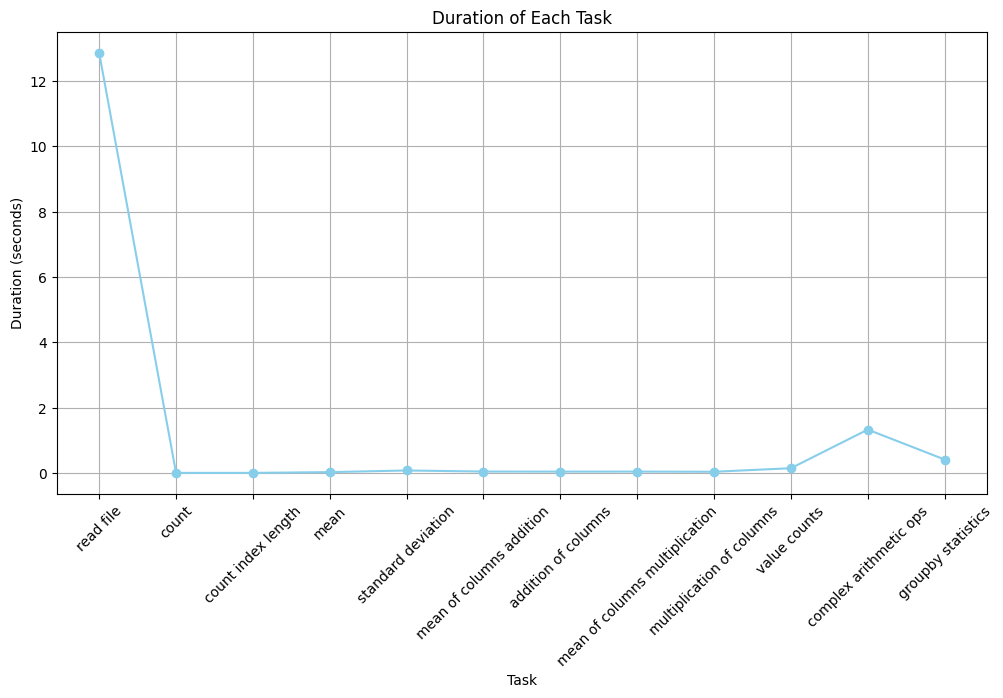

In [25]:
# Gráfico de Linha
plt.figure(figsize=(12, 6))
plt.plot(results_modin['task'], results_modin['duration'], marker='o', linestyle='-', color='skyblue')
plt.xlabel('Task')
plt.ylabel('Duration (seconds)')
plt.title('Duration of Each Task')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**Análise:**

- O gráfico de linha confirma a análise dos gráficos anteriores, mostrando que a operação de leitura do arquivo (`read file`) é a mais demorada;
- A queda abrupta da linha após a operação de leitura do arquivo indica que as demais operações têm tempos de execução muito menores;
- As operações subsequentes têm durações relativamente semelhantes, com uma diferença mínima entre elas, exceto `complex arithmetic ops` e `groupby statistics`, que têm uma duração um pouco maior comparada às demais operações menores.

**Conclusão Geral**

Os três gráficos fornecem uma visão abrangente do desempenho das diferentes operações realizadas no DataFrame. A operação de leitura do arquivo é claramente identificada como o principal gargalo, consumindo a maior parte do tempo de execução. Outras operações, embora diversas, têm um impacto muito menor no tempo total de execução. Essas visualizações ajudam a identificar áreas que necessitam de otimização, principalmente focando na melhoria da eficiência da leitura de arquivos.

## Operations with filtering

Repetiu-se o mesmo procedimento: para **dados filtrados**, pretende-se medir a execução das operações acima definidas.
O filtro `tip_amt >= 1 and tip_amt <= 5` é aplicado aos dados usando `query`para manter o Modin Dataframe. De seguida inicializa-se o dicionário que irá armazenar os reusltados dos benchmarks aplicados aod dados filtrados.

In [17]:
print(f"Tipo do DataFrame : {type(modin_data)}")

# Filtrar dados usando query para manter Modin DataFrame
expr_filter = 'tip_amt >= 1 and tip_amt <= 5'
modin_filtered = modin_data.query(expr_filter)
print(f"Tipo do DataFrame filtrado: {type(modin_filtered)}")

# Converter para Modin novamente, se necessário
if not isinstance(modin_filtered, pd.DataFrame):
    modin_filtered = pd.DataFrame(modin_filtered)

# Verificar o tipo do DataFrame filtrado
print(f"Tipo do DataFrame filtrado: {type(modin_filtered)}")


# Inicializar dicionários para armazenar resultados dos benchmarks
modin_benchmarks_filtered = {'duration': [], 'task': []}

Tipo do DataFrame : <class 'pandas.core.frame.DataFrame'>
Tipo do DataFrame filtrado: <class 'pandas.core.frame.DataFrame'>
Tipo do DataFrame filtrado: <class 'pandas.core.frame.DataFrame'>


**Resultado das Benchmarks** Verifica-se que a operação standard mais rápida é `count index length took: 2.86102294921875e-06 seconds`. Em contrapartida a que leva mais tempo a executar: `read file took: 11.596233367919922 seconds`. É possível denotar um aumento na velocidade de execução, com o filtro as operações são executadas mais rápidamente.

In [18]:
# Executar benchmarks nas operações com dados filtrados
benchmark(read_file_parquet, df=None, benchmarks=modin_benchmarks_filtered, name='read file')
benchmark(count, df=modin_filtered, benchmarks=modin_benchmarks_filtered, name='count')
benchmark(count_index_length, df=modin_filtered, benchmarks=modin_benchmarks_filtered, name='count index length')
benchmark(mean, df=modin_filtered, benchmarks=modin_benchmarks_filtered, name='mean')
benchmark(standard_deviation, df=modin_filtered, benchmarks=modin_benchmarks_filtered, name='standard deviation')
benchmark(mean_of_sum, df=modin_filtered, benchmarks=modin_benchmarks_filtered, name='mean of columns addition')
benchmark(sum_columns, df=modin_filtered, benchmarks=modin_benchmarks_filtered, name='addition of columns')
benchmark(mean_of_product, df=modin_filtered, benchmarks=modin_benchmarks_filtered, name='mean of columns multiplication')
benchmark(product_columns, df=modin_filtered, benchmarks=modin_benchmarks_filtered, name='multiplication of columns')
benchmark(value_counts, df=modin_filtered, benchmarks=modin_benchmarks_filtered, name='value counts')
benchmark(complicated_arithmetic_operation, df=modin_filtered, benchmarks=modin_benchmarks_filtered, name='complex arithmetic ops')
benchmark(groupby_statistics, df=modin_filtered, benchmarks=modin_benchmarks_filtered, name='groupby statistics')

read file took: 12.610538244247437 seconds
count took: 1.811981201171875e-05 seconds
count index length took: 2.1457672119140625e-06 seconds
mean took: 0.00496220588684082 seconds
standard deviation took: 0.01281428337097168 seconds
mean of columns addition took: 0.010245800018310547 seconds
addition of columns took: 0.005234241485595703 seconds
mean of columns multiplication took: 0.0064733028411865234 seconds
multiplication of columns took: 0.004754066467285156 seconds
value counts took: 0.022228240966796875 seconds
complex arithmetic ops took: 0.22254323959350586 seconds
groupby statistics took: 0.07422542572021484 seconds


0.07422542572021484

### Salvar Resultados

In [21]:
# Obter os resultados e remover duplicatas
modin_res_filtered = get_results(modin_benchmarks_filtered).drop_duplicates(subset='task').set_index('task')

# Print dos dataframes
print(modin_res_filtered)

# Definir o nome do arquivo ou diretório
filename_filter = 'Resultados/modin_filtered1'

# Salvar o DataFrame em formato Parquet
modin_res_filtered.to_parquet(filename_filter)

print(f'O arquivo Parquet foi salvo em {filename_filter}.')


                                 duration
task                                     
read file                       12.610538
count                            0.000018
count index length               0.000002
mean                             0.004962
standard deviation               0.012814
mean of columns addition         0.010246
addition of columns              0.005234
mean of columns multiplication   0.006473
multiplication of columns        0.004754
value counts                     0.022228
complex arithmetic ops           0.222543
groupby statistics               0.074225
O arquivo Parquet foi salvo em Resultados/modin_filtered1.


### CProfile para dados filtrados 

In [19]:
# Inicializar dicionários para armazenar resultados dos benchmarks
modin_benchmarks_filtered_cprofile = {'duration': [], 'task': []}

In [20]:
# Executar benchmarks nas operações com dados filtrados
benchmark_with_cprofile(read_file_parquet, df=None, benchmarks=modin_benchmarks_filtered_cprofile, name='read file')
benchmark_with_cprofile(count, df=modin_filtered, benchmarks=modin_benchmarks_filtered_cprofile, name='count')
benchmark_with_cprofile(count_index_length, df=modin_filtered, benchmarks=modin_benchmarks_filtered_cprofile, name='count index length')
benchmark_with_cprofile(mean, df=modin_filtered, benchmarks=modin_benchmarks_filtered_cprofile, name='mean')
benchmark_with_cprofile(standard_deviation, df=modin_filtered, benchmarks=modin_benchmarks_filtered_cprofile, name='standard deviation')
benchmark_with_cprofile(mean_of_sum, df=modin_filtered, benchmarks=modin_benchmarks_filtered_cprofile, name='mean of columns addition')
benchmark_with_cprofile(sum_columns, df=modin_filtered, benchmarks=modin_benchmarks_filtered, name='addition of columns')
benchmark_with_cprofile(mean_of_product, df=modin_filtered, benchmarks=modin_benchmarks_filtered, name='mean of columns multiplication')
benchmark_with_cprofile(product_columns, df=modin_filtered, benchmarks=modin_benchmarks_filtered, name='multiplication of columns')
benchmark_with_cprofile(value_counts, df=modin_filtered, benchmarks=modin_benchmarks_filtered, name='value counts')
benchmark_with_cprofile(complicated_arithmetic_operation, df=modin_filtered, benchmarks=modin_benchmarks_filtered, name='complex arithmetic ops')
benchmark_with_cprofile(groupby_statistics, df=modin_filtered, benchmarks=modin_benchmarks_filtered, name='groupby statistics')

read file took: 12.734710454940796 seconds
         1887 function calls (1872 primitive calls) in 12.735 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   12.735   12.735 1601532002.py:6(read_file_parquet)
        1    0.000    0.000   12.735   12.735 parquet.py:433(read_parquet)
        1    0.001    0.001   12.735   12.735 parquet.py:201(read)
        1    0.000    0.000    7.684    7.684 {method 'to_pandas' of 'pyarrow.lib._PandasConvertible' objects}
        1    0.000    0.000    7.684    7.684 pandas_compat.py:797(table_to_blockmanager)
        1    0.000    0.000    7.683    7.683 pandas_compat.py:1164(_table_to_blocks)
        1    7.683    7.683    7.683    7.683 {pyarrow.lib.table_to_blocks}
        1    0.000    0.000    5.049    5.049 core.py:2909(read_table)
        1    0.000    0.000    5.048    5.048 core.py:2533(read)
        1    5.047    5.047    5.047    5.047 {method 'to_ta

0.07942080497741699

In [26]:
# Convert benchmark results to DataFrame
results_modin_filtered = pd.DataFrame.from_dict(modin_benchmarks_filtered_cprofile)

### Gráfico de Barras

**Descrição:** Este gráfico de barras horizontal mostra a duração de cada tarefa em segundos. As barras representam visualmente o tempo gasto em cada operação realizada no DataFrame. A barra da operação "read file" está destacada em rosa.

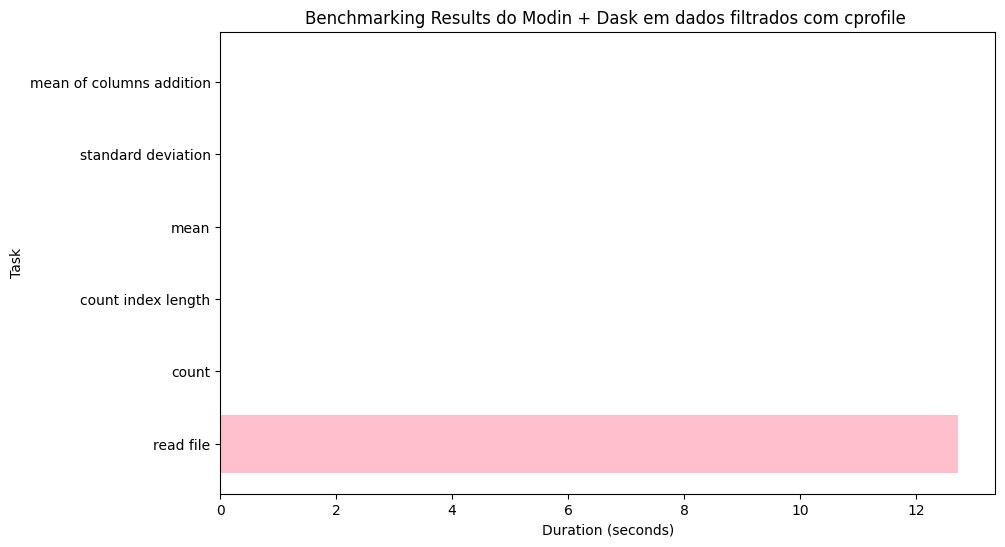

In [27]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.barh(results_modin_filtered['task'], results_modin_filtered['duration'], color='pink')
plt.xlabel('Duration (seconds)')
plt.ylabel('Task')
plt.title('Benchmarking Results do Modin + Dask em dados filtrados com cprofile ')
plt.show()

**Análise:**

- A operação de leitura do arquivo (`read file`) é a mais demorada, com uma duração de aproximadamente 13 segundos, destacando-se significativamente das outras operações;
- Outras operações, como standard deviation e mean of columns addition, têm durações perceptíveis, mas são muito menores em comparação à leitura do arquivo;
- A maioria das outras operações tem tempos de execução muito pequenos, praticamente insignificantes quando comparados à leitura do arquivo.


### Gráfico de Pizza

**Descrição:** Este gráfico de pizza representa a proporção de tempo gasto em cada tarefa. As percentagens são mostradas ao lado das etiquetas na legenda. A fatia da operação "read file" está destacada em rosa.

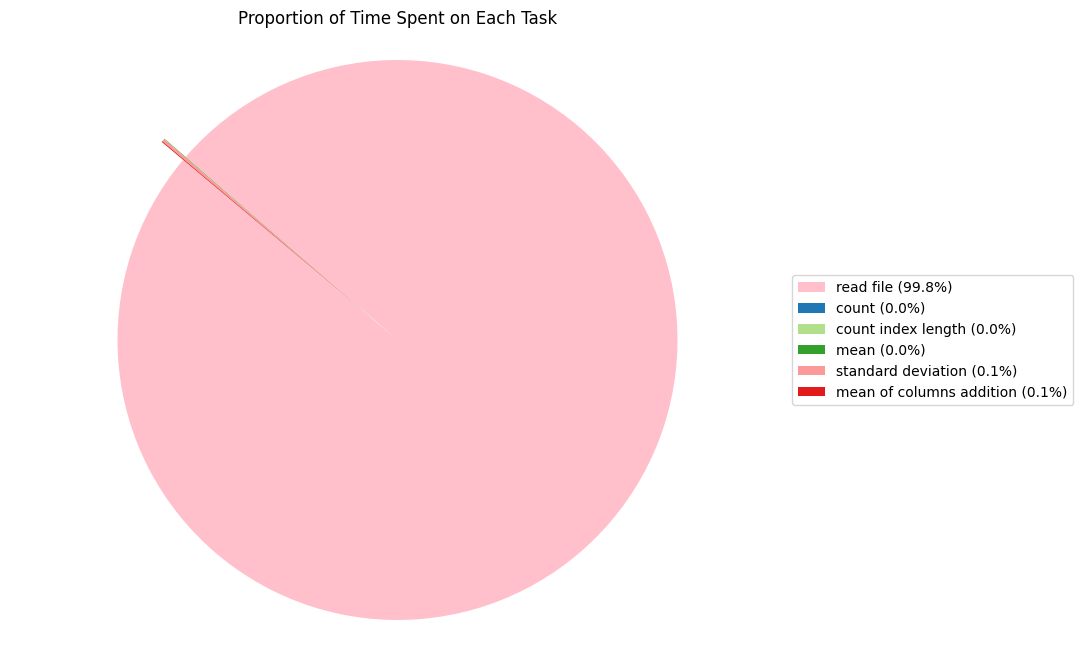

In [28]:
# Calcular percentagens
percentages = [f"{(d / sum(results_modin_filtered['duration']) * 100):.1f}%" for d in results_modin_filtered['duration']]
legend_labels = [f"{task} ({percentage})" for task, percentage in zip(results_modin_filtered['task'], percentages)]

# Definir cores, com 'read file' como rosa
colors = ['pink' if task == 'read file' else color for task, color in zip(results_modin_filtered['task'], plt.cm.Paired.colors)]

# Gráfico de Pizza sem rótulos nas fatias
explode = [0.1 if i == 0 else 0 for i in range(len(results_modin_filtered['duration']))]

plt.figure(figsize=(10, 8))
plt.pie(results_modin_filtered['duration'], startangle=140, colors=colors,
        explode=explode, pctdistance=0.85, labeldistance=1.1)

# Garantir que os rótulos não se sobreponham
plt.axis('equal')
plt.title('Proportion of Time Spent on Each Task')
plt.legend(legend_labels, loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

**Análise:**

- A operação de leitura do arquivo (`read file`) consome a maior parte do tempo total, com 99.8% do tempo total de execução;
- As outras operações, como standard deviation e mean of columns addition, ocupam uma fração muito pequena do tempo total, cada uma contribuindo com menos de 1% do tempo total de execução;
- Este gráfico destaca claramente que a leitura do arquivo é o principal gargalo no processo.


### Gráfico de Linha

**Descrição:** O gráfico de linha mostra a duração de cada tarefa em sequência. Cada ponto no gráfico representa a duração de uma tarefa específica. A linha correspondente à tarefa "read file" está destacada em rosa.

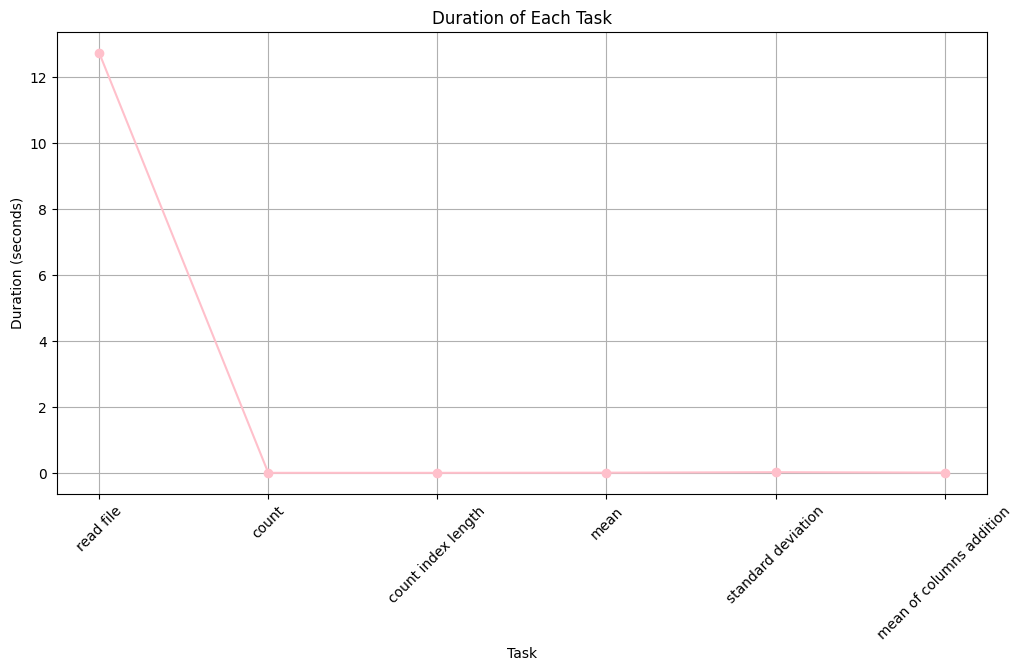

In [29]:
# Gráfico de Linha
plt.figure(figsize=(12, 6))
plt.plot(results_modin_filtered['task'], results_modin_filtered['duration'], marker='o', linestyle='-', color='pink')
plt.xlabel('Task')
plt.ylabel('Duration (seconds)')
plt.title('Duration of Each Task')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**Análise:**

- O gráfico de linha confirma a análise dos gráficos anteriores, mostrando que a operação de leitura do arquivo (read file) é a mais demorada;
- A queda abrupta da linha após a operação de leitura do arquivo indica que as demais operações têm tempos de execução muito menores.
- As operações subsequentes têm durações relativamente semelhantes, com uma diferença mínima entre elas.

**Conclusão Geral**

Os três gráficos fornecem uma visão abrangente do desempenho das diferentes operações realizadas no DataFrame. A operação de leitura do arquivo é claramente identificada como o principal gargalo, consumindo a maior parte do tempo de execução. Outras operações, embora diversas, têm um impacto muito menor no tempo total de execução. 

## Operations with filtering and cache

Uma vez que durante a implementação se enfrentou erros quanto ao formato dos dados, implementou-se uma condição que verifica se estamos a lidar com um Dataframe Modin. Caso a verificação seja correta, isto é, um Dataframe Modin, então converte o dataframe para pandas. E, posteriormente, converte o pandas para dask,com 10 partições (`from_pandas(dask_df, npartitions=10)`) para conseguir aplicar o cache, persistindo com dask(`client.persist(dask_df)`). Por fim, inicializa os dicionários `modin_benchmarks_cache` para armazenar os resultados das benchmarks dos dados filtrados e persistidos.

In [30]:
# Verificar se estamos a lidar com um DataFrame Modin
if isinstance(modin_filtered, pd.DataFrame):
    # Depuração: imprimir algumas linhas do DataFrame
    print(modin_filtered.head())
    
    # Converter Modin para Pandas
    dask_df = modin_filtered
    print("Conversão para Pandas realizada com sucesso.")
else:
    print("O DataFrame filtrado não é um DataFrame Modin.")
    raise TypeError("O objeto não é um DataFrame Modin")

# Converter Pandas para Dask
dask_df = dd.from_pandas(dask_df, npartitions=10)

# Persistir com Dask
dask_df = client.persist(dask_df)
modin_cache = dask_df

# Inicializar dicionários para armazenar resultados dos benchmarks
modin_benchmarks_cache = {'duration': [], 'task': []}

  vendor_name trip_pickup_datetime trip_dropoff_datetime  passenger_count  \
1         VTS  2009-01-04 03:31:00   2009-01-04 03:38:00                3   
2         VTS  2009-01-03 15:43:00   2009-01-03 15:57:00                5   
3         DDS  2009-01-01 20:52:58   2009-01-01 21:14:00                1   
6         DDS  2009-01-21 08:55:57   2009-01-21 09:05:42                1   
8         CMT  2009-01-05 16:29:02   2009-01-05 16:40:21                1   

   trip_distance  start_lon  start_lat  rate_code  store_and_forward  \
1           4.55 -73.982102  40.736290        NaN                NaN   
2          10.35 -74.002587  40.739748        NaN                NaN   
3           5.00 -73.974267  40.790955        NaN                NaN   
6           0.40 -73.984050  40.743544        NaN                NaN   
8           1.60 -73.969690  40.749244        NaN                NaN   

     end_lon    end_lat payment_type  fare_amt  surcharge  mta_tax  tip_amt  \
1 -73.955850  40.768030  

This may cause some slowdown.
Consider scattering data ahead of time and using futures.


**Resultados das benchmars nas operações com dados filtrados persistidos** Verifica-se que a operação standard mais rápida é `value counts took: 0.0010666847229003906 seconds`. Em contrapartida a que leva mais tempo a executar: `read file took: 12.424574613571167 seconds`. É possível denotar uma diminuição na velocidade de execução, com a peristência nas operações, estas são executadas mais lentamente.

In [31]:
# Executar benchmarks nas operações com dados persistidos (cache)
benchmark(read_file_parquet, df=None, benchmarks=modin_benchmarks_cache, name='read file')
benchmark(count, df=modin_cache, benchmarks=modin_benchmarks_cache, name='count')
benchmark(count_index_length, df=modin_cache, benchmarks=modin_benchmarks_cache, name='count index length')
benchmark(mean, df=modin_cache, benchmarks=modin_benchmarks_cache, name='mean')
benchmark(standard_deviation, df=modin_cache, benchmarks=modin_benchmarks_cache, name='standard deviation')
benchmark(mean_of_sum, df=modin_cache, benchmarks=modin_benchmarks_cache, name='mean of columns addition')
benchmark(sum_columns, df=modin_cache, benchmarks=modin_benchmarks_cache, name='addition of columns')
benchmark(mean_of_product, df=modin_cache, benchmarks=modin_benchmarks_cache, name='mean of columns multiplication')
benchmark(product_columns, df=modin_cache, benchmarks=modin_benchmarks_cache, name='multiplication of columns')
benchmark(value_counts, df=modin_cache, benchmarks=modin_benchmarks_cache, name='value counts')
benchmark(complicated_arithmetic_operation, df=modin_cache, benchmarks=modin_benchmarks_cache, name='complex arithmetic ops')
benchmark(groupby_statistics, df=modin_cache, benchmarks=modin_benchmarks_cache, name='groupby statistics')



read file took: 12.3390371799469 seconds
count took: 0.2407550811767578 seconds
count index length took: 0.029567956924438477 seconds
mean took: 0.004515171051025391 seconds
standard deviation took: 0.0042650699615478516 seconds
mean of columns addition took: 0.0035123825073242188 seconds
addition of columns took: 0.0022916793823242188 seconds
mean of columns multiplication took: 0.003802776336669922 seconds
multiplication of columns took: 0.002413034439086914 seconds
value counts took: 0.00124359130859375 seconds
complex arithmetic ops took: 0.15938925743103027 seconds
groupby statistics took: 0.019723176956176758 seconds


0.019723176956176758

### Salvar Resultados

In [32]:
# Obter os resultados e remover duplicatas
modin_res_cache = get_results(modin_benchmarks_cache).drop_duplicates(subset='task').set_index('task')

# Print dos dataframes
print(modin_res_cache)

# Definir o nome do arquivo ou diretório
filename_cache = 'Resultados/modin_cache1'

# Salvar o DataFrame em formato Parquet
modin_res_cache.to_parquet(filename_cache)

print(f'O arquivo Parquet foi salvo em {filename_cache}.')

                                 duration
task                                     
read file                       12.339037
count                            0.240755
count index length               0.029568
mean                             0.004515
standard deviation               0.004265
mean of columns addition         0.003512
addition of columns              0.002292
mean of columns multiplication   0.003803
multiplication of columns        0.002413
value counts                     0.001244
complex arithmetic ops           0.159389
groupby statistics               0.019723
O arquivo Parquet foi salvo em Resultados/modin_cache1.


### cProfile em dados persistidos

In [33]:
# Inicializar dicionários para armazenar resultados dos benchmarks
modin_benchmarks_cache_cprofile = {'duration': [], 'task': []}

In [34]:
# Executar benchmarks nas operações com dados persistidos (cache)
benchmark_with_cprofile(read_file_parquet, df=None, benchmarks=modin_benchmarks_cache_cprofile, name='read file')
benchmark_with_cprofile(count, df=modin_cache, benchmarks=modin_benchmarks_cache_cprofile, name='count')
benchmark_with_cprofile(count_index_length, df=modin_cache, benchmarks=modin_benchmarks_cache_cprofile, name='count index length')
benchmark_with_cprofile(mean, df=modin_cache, benchmarks=modin_benchmarks_cache_cprofile, name='mean')
benchmark_with_cprofile(standard_deviation, df=modin_cache, benchmarks=modin_benchmarks_cache_cprofile, name='standard deviation')
benchmark_with_cprofile(mean_of_sum, df=modin_cache, benchmarks=modin_benchmarks_cache_cprofile, name='mean of columns addition')
benchmark_with_cprofile(sum_columns, df=modin_cache, benchmarks=modin_benchmarks_cache_cprofile, name='addition of columns')
benchmark_with_cprofile(mean_of_product, df=modin_cache, benchmarks=modin_benchmarks_cache_cprofile, name='mean of columns multiplication')
benchmark_with_cprofile(product_columns, df=modin_cache, benchmarks=modin_benchmarks_cache_cprofile, name='multiplication of columns')
benchmark_with_cprofile(value_counts, df=modin_cache, benchmarks=modin_benchmarks_cache_cprofile, name='value counts')
benchmark_with_cprofile(complicated_arithmetic_operation, df=modin_cache, benchmarks=modin_benchmarks_cache_cprofile, name='complex arithmetic ops')
benchmark_with_cprofile(groupby_statistics, df=modin_cache, benchmarks=modin_benchmarks_cache_cprofile, name='groupby statistics')



read file took: 12.372292757034302 seconds
         1887 function calls (1872 primitive calls) in 12.372 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   12.372   12.372 1601532002.py:6(read_file_parquet)
        1    0.000    0.000   12.372   12.372 parquet.py:433(read_parquet)
        1    0.001    0.001   12.372   12.372 parquet.py:201(read)
        1    0.000    0.000    7.296    7.296 {method 'to_pandas' of 'pyarrow.lib._PandasConvertible' objects}
        1    0.000    0.000    7.296    7.296 pandas_compat.py:797(table_to_blockmanager)
        1    0.000    0.000    7.294    7.294 pandas_compat.py:1164(_table_to_blocks)
        1    7.294    7.294    7.294    7.294 {pyarrow.lib.table_to_blocks}
        1    0.000    0.000    5.075    5.075 core.py:2909(read_table)
        1    0.000    0.000    5.074    5.074 core.py:2533(read)
        1    5.074    5.074    5.074    5.074 {method 'to_ta

0.021169662475585938

In [35]:
# Convert benchmark results to DataFrame
results_modin_cache = pd.DataFrame.from_dict(modin_benchmarks_cache_cprofile)

### Gráfico de Barras Horizontais

**Descrição:** Este gráfico mostra a duração em segundos de várias tarefas de processamento de dados.

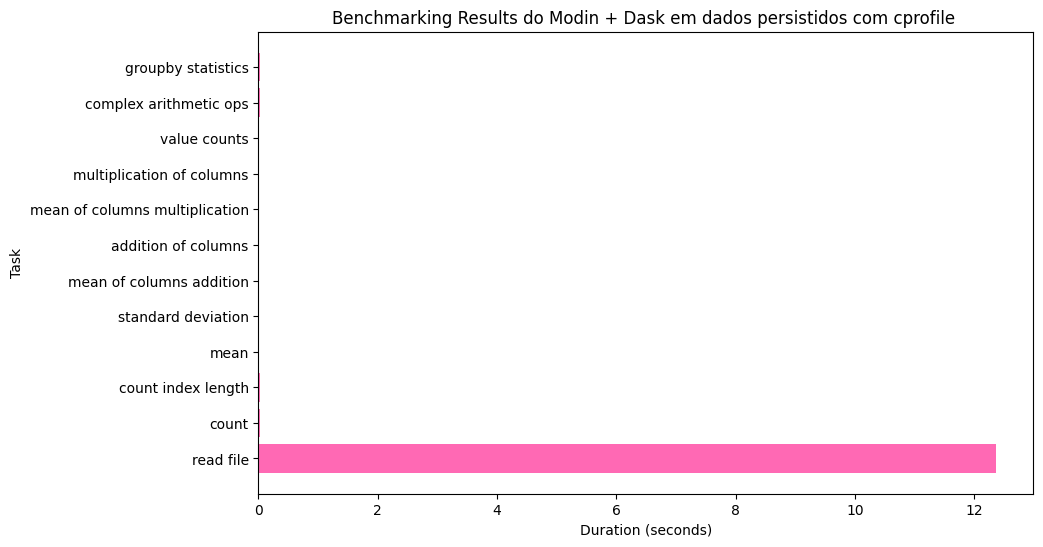

In [36]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.barh(results_modin_cache['task'], results_modin_cache['duration'], color='hotpink')
plt.xlabel('Duration (seconds)')
plt.ylabel('Task')
plt.title('Benchmarking Results do Modin + Dask em dados persistidos com cprofile ')
plt.show()

**Tarefas Avaliadas:**

- Leitura de Arquivo
- Contagem
- Comprimento do Índice de Contagem
- Média
- Desvio Padrão
- Adição de Colunas
- Multiplicação de Colunas
- Operações Aritméticas Complexas
- Estatísticas de Agrupamento

**Análise:**

- A leitura do arquivo é, de longe, a tarefa que mais consome tempo, levando aproximadamente 13 segundos;
- Outras tarefas, como contagem, comprimento do índice de contagem, e operações aritméticas complexas, consomem significativamente menos tempo;
- Tarefas como adição de colunas, multiplicação de colunas, média e desvio padrão têm uma duração desprezível.

### Gráfico de Pizza

**Descrição:** Este gráfico de pizza mostra a proporção do tempo gasto em cada tarefa.



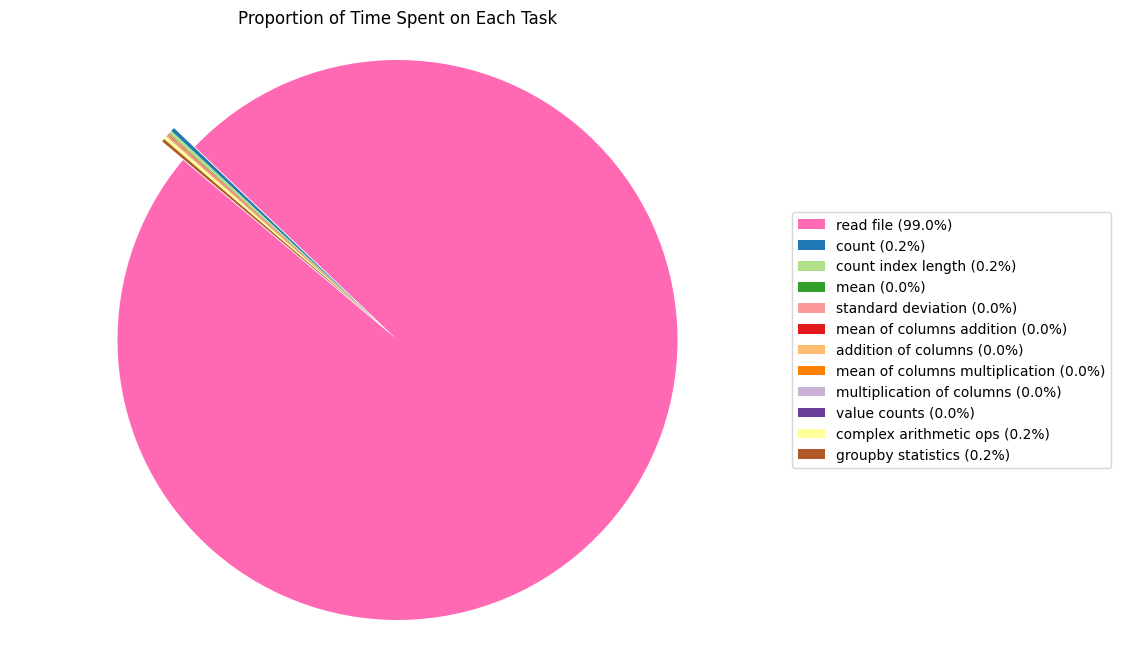

In [37]:
# Calcular percentagens
percentages = [f"{(d / sum(results_modin_cache['duration']) * 100):.1f}%" for d in results_modin_cache['duration']]
legend_labels = [f"{task} ({percentage})" for task, percentage in zip(results_modin_cache['task'], percentages)]

# Definir cores, com 'read file' como rosa
colors = ['hotpink' if task == 'read file' else color for task, color in zip(results_modin_cache['task'], plt.cm.Paired.colors)]

# Gráfico de Pizza sem rótulos nas fatias
explode = [0.1 if i == 0 else 0 for i in range(len(results_modin_cache['duration']))]

plt.figure(figsize=(10, 8))
plt.pie(results_modin_cache['duration'], startangle=140, colors=colors,
        explode=explode, pctdistance=0.85, labeldistance=1.1)

# Garantir que os rótulos não se sobreponham
plt.axis('equal')
plt.title('Proportion of Time Spent on Each Task')
plt.legend(legend_labels, loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

**Proporção de Tempo:**

- Leitura de Arquivo: 99.0%
- Contagem: 0.2%
- Comprimento do Índice de Contagem: 0.2%
- Operações Aritméticas Complexas: 0.2%
- Estatísticas de Agrupamento: 0.2%


**Análise:**

- A leitura do arquivo domina completamente o tempo de processamento, representando quase 99% do tempo total.
- As outras tarefas representam uma fração muito pequena do tempo total, com a contagem sendo a mais significativa dentre elas.

### Gráfico de linha

**Descrição:** Este gráfico de linha mostra a duração de cada tarefa em segundos.

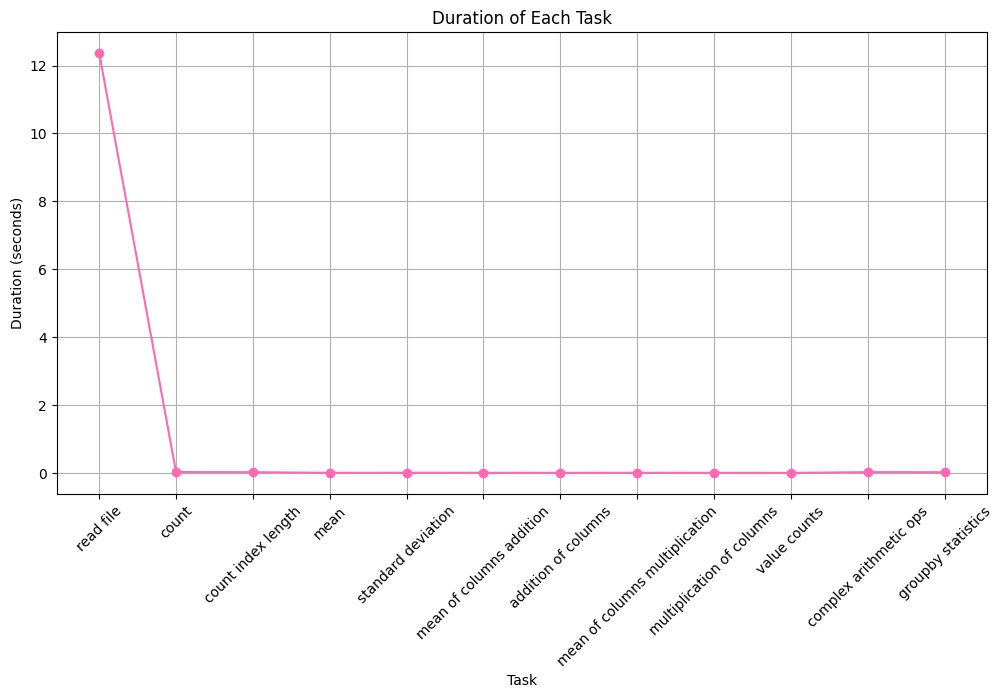

In [38]:
# Gráfico de Linha
plt.figure(figsize=(12, 6))
plt.plot(results_modin_cache['task'], results_modin_cache['duration'], marker='o', linestyle='-', color='hotpink')
plt.xlabel('Task')
plt.ylabel('Duration (seconds)')
plt.title('Duration of Each Task')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**Duração das Tarefas:**

- Leitura de Arquivo: Aproximadamente 12 segundos
- Contagem: Aproximadamente 0.2 segundos
- Outras tarefas: Duram menos de 0.2 segundos

**Análise:**

- A leitura do arquivo é significativamente mais demorada que qualquer outra tarefa.
- As demais tarefas têm uma duração quase insignificante comparada à leitura do arquivo, indicando que a leitura de dados é o principal gargalo no processamento.


**Conclusão**

- `Gargalo Principal`: A leitura do arquivo é claramente o principal gargalo no processo, consumindo quase todo o tempo de processamento. Isso sugere que otimizar a leitura de arquivos ou usar técnicas de leitura mais eficientes poderia melhorar significativamente o desempenho geral.
- `Desempenho de Outras Tarefas`: Outras tarefas, como operações aritméticas e contagem, são muito rápidas e não contribuem significativamente para o tempo total de processamento.
- `Uso de Recursos`: Modin + Dask parecem ser bastante eficientes para operações que não envolvem leitura de arquivo, indicando que o framework está bem otimizado para processamento de dados após a leitura inicial.

### Antes de passarmos para o JobLib, restaurou-se a sessão com o cliente

In [39]:
client.restart()

<Client: 'tcp://127.0.0.1:40011' processes=2 threads=4, memory=31.40 GiB>

Ainda usando uma **amostra de 1 file (o primeiro mês de 2009)** repetiu-se o estudo, mas explorando as funcionalidades da biblioteca de Big Data, **JobLib**

## JobLib

Carregou-se o ficheiro (`parquet_file`) para um dataframe Pandas (`data`). A este dataframe aplicou-se `lower` para renomear as colunas para minúsculas.

In [40]:
import pandas as pd
import numpy as np
import time
from joblib import dump, load
import cProfile
import matplotlib.pyplot as plt
from io import StringIO
import pstats

# Carregar o arquivo Parquet em DataFrame Pandas
parquet_file = 'Ficheiros/taxi_csv/yellow_tripdata_2009-01.parquet'
data = pd.read_parquet(parquet_file)

# Exibir colunas do DataFrame
print(data.columns)

# Renomear colunas para minúsculas
data = data.rename(columns=str.lower)


Index(['vendor_name', 'Trip_Pickup_DateTime', 'Trip_Dropoff_DateTime',
       'Passenger_Count', 'Trip_Distance', 'Start_Lon', 'Start_Lat',
       'Rate_Code', 'store_and_forward', 'End_Lon', 'End_Lat', 'Payment_Type',
       'Fare_Amt', 'surcharge', 'mta_tax', 'Tip_Amt', 'Tolls_Amt',
       'Total_Amt'],
      dtype='object')


Ao contrário das implementações das benchmarks para outras bibliotecas, no JobLib criou-se uma função `execute benchmark`, que engloba todas as benchmarks das operações pretendidas. Para além disso, definiu-se uma vez mais as funções, que correspondem às operações que pretendemos medir.

In [41]:
def get_results(benchmarks):
    """Retorna um DataFrame pandas contendo os resultados dos benchmarks"""
    return pd.DataFrame.from_dict(benchmarks)

# Funções de operações
def read_file_parquet(df=None):
    return pd.read_parquet(parquet_file)

def count(df):
    return len(df)

def count_index_length(df):
    return len(df.index)

def mean(df):
    return df['fare_amt'].mean()

def standard_deviation(df):
    return df['fare_amt'].std()

def mean_of_sum(df):
    return (df['fare_amt'] + df['tip_amt']).mean()

def sum_columns(df):
    return (df['fare_amt'] + df['tip_amt']).sum()

def mean_of_product(df):
    return (df['fare_amt'] * df['tip_amt']).mean()

def product_columns(df):
    return (df['fare_amt'] * df['tip_amt']).sum()

def value_counts(df):
    return df['fare_amt'].value_counts()

def complicated_arithmetic_operation(df):
    theta_1 = df['start_lon']
    phi_1 = df['start_lat']
    theta_2 = df['end_lon']
    phi_2 = df['end_lat']
    temp = (np.sin((theta_2 - theta_1) / 2 * np.pi / 180) ** 2
           + np.cos(theta_1 * np.pi / 180) * np.cos(theta_2 * np.pi / 180)
           * np.sin((phi_2 - phi_1) / 2 * np.pi / 180) ** 2)
    ret = 2 * np.arctan2(np.sqrt(temp), np.sqrt(1 - temp))
    return ret.mean()

def groupby_statistics(df):
    return df.groupby(by='passenger_count').agg({
        'fare_amt': ['mean', 'std'], 
        'tip_amt': ['mean', 'std']
    })

def join_count(df, other):
    return len(df.merge(other, left_index=True, right_index=True))

def join_data(df, other):
    return df.merge(other, left_index=True, right_index=True)

# Funções de benchmark
def benchmark(f, df, benchmarks, name, **kwargs):
    """Mede a duração da execução de uma função específica"""
    start_time = time.time()
    ret = f(df, **kwargs)
    duration = time.time() - start_time
    benchmarks['duration'].append(duration)
    benchmarks['task'].append(name)
    print(f"{name} took: {duration} seconds")
    return duration

def execute_benchmarks(data, benchmarks):
    benchmark(count, data, benchmarks, 'count')
    benchmark(count_index_length, data, benchmarks, 'count_index_length')
    benchmark(mean, data, benchmarks, 'mean')
    benchmark(standard_deviation, data, benchmarks, 'standard_deviation')
    benchmark(mean_of_sum, data, benchmarks, 'mean_of_sum')
    benchmark(sum_columns, data, benchmarks, 'sum_columns')
    benchmark(mean_of_product, data, benchmarks, 'mean_of_product')
    benchmark(product_columns, data, benchmarks, 'product_columns')
    benchmark(value_counts, data, benchmarks, 'value_counts')
    benchmark(complicated_arithmetic_operation, data, benchmarks, 'complicated_arithmetic_operation')
    benchmark(groupby_statistics, data, benchmarks, 'groupby_statistics')
    other_data = data.copy()  # Simulando outra tabela para a operação de join
    benchmark(join_count, data, benchmarks, 'join_count', other=other_data)
    benchmark(join_data, data, benchmarks, 'join_data', other=other_data)



1. **Inicialização dos Dicionários de Benchmark:**
   Foram inicializados dicionários para armazenar a duração das operações e a respectiva tarefa associada (`benchmarks`, `benchmarks_filtered`, `benchmarks_cache`).

2. **Execução dos Benchmarks com Dados Completos:**
   As operações de benchmark foram executadas no conjunto de dados original, armazenando as durações em `benchmarks`.

3. **Filtragem dos Dados:**
   Aplicou-se um filtro aos dados, selecionando apenas registros onde o valor da gorjeta (`tip_amt`) está entre 1 e 5. Este subconjunto de dados foi armazenado em `filtered_data`.

4. **Execução dos Benchmarks com Dados Filtrados:**
   As operações de benchmark foram executadas no conjunto de dados filtrado, armazenando as durações em `benchmarks_filtered`.

5. **Persistência e Carregamento dos Dados:**
   Os dados filtrados foram persistidos em disco usando a biblioteca Joblib (`filtered_data.pkl`). Em seguida, estes dados foram carregados novamente para simular operações com dados em cache, armazenados em `cached_data`. Para isso, usou-se as funções `dump` e `load`, que persistem dados filtrados usando Joblib e carregam esses mesmos dados, respetivamente.

6. **Execução dos Benchmarks com Dados em Cache:**
   As operações de benchmark foram executadas no conjunto de dados carregado do cache, armazenando as durações em `benchmarks_cache`.


In [ ]:
# Inicializar dicionários para armazenar resultados dos benchmarks
joblib_benchmarks_standard_cprofile = {'duration': [], 'task': []}

# Executar benchmarks nas operações com dados completos
execute_benchmarks(data, joblib_benchmarks_standard_cprofile)


count took: 2.2411346435546875e-05 seconds
count_index_length took: 1.0013580322265625e-05 seconds
mean took: 0.021241426467895508 seconds
standard_deviation took: 0.06915831565856934 seconds
mean_of_sum took: 0.03684806823730469 seconds
sum_columns took: 0.029595375061035156 seconds
mean_of_product took: 0.037483930587768555 seconds
product_columns took: 0.03058624267578125 seconds
value_counts took: 0.11816763877868652 seconds
complicated_arithmetic_operation took: 1.215036153793335 seconds
groupby_statistics took: 0.39676332473754883 seconds
join_count took: 1.9817216396331787 seconds
join_data took: 1.5666399002075195 seconds


In [44]:
#Inicializar dicionários para armazenar resultados dos benchmarks
joblib_benchmarks = {'duration': [], 'task': []}

# Executar benchmarks nas operações com dados completos
execute_benchmarks(data, joblib_benchmarks)

# Filtrar dados
expr_filter = (data['tip_amt'] >= 1) & (data['tip_amt'] <= 5)
filtered_data = data[expr_filter]

# Inicializar dicionários para armazenar resultados dos benchmarks com dados filtrados
joblib_benchmarks_filtered = {'duration': [], 'task': []}

# Executar benchmarks nas operações com dados filtrados
execute_benchmarks(filtered_data, joblib_benchmarks_filtered)

# Inicializar dicionários para armazenar resultados dos benchmarks com dados persistidos (cache)
joblib_benchmarks_cache = {'duration': [], 'task': []}

# Persistir dados filtrados usando Joblib
dump(filtered_data, 'filtered_data.pkl')

# Carregar dados persistidos
cached_data = load('filtered_data.pkl')

# Executar benchmarks nas operações com dados carregados do cache
execute_benchmarks(cached_data, joblib_benchmarks_cache)


count took: 1.6450881958007812e-05 seconds
count_index_length took: 2.1457672119140625e-06 seconds
mean took: 0.02111530303955078 seconds
standard_deviation took: 0.07519221305847168 seconds
mean_of_sum took: 0.04060792922973633 seconds
sum_columns took: 0.03356218338012695 seconds
mean_of_product took: 0.04184532165527344 seconds
product_columns took: 0.03434634208679199 seconds
value_counts took: 0.11722540855407715 seconds
complicated_arithmetic_operation took: 1.26161527633667 seconds
groupby_statistics took: 0.3959777355194092 seconds
join_count took: 2.1751508712768555 seconds
join_data took: 1.7305881977081299 seconds
count took: 1.1444091796875e-05 seconds
count_index_length took: 4.291534423828125e-06 seconds
mean took: 0.004891633987426758 seconds
standard_deviation took: 0.012112855911254883 seconds
mean_of_sum took: 0.00732731819152832 seconds
sum_columns took: 0.005842924118041992 seconds
mean_of_product took: 0.00677037239074707 seconds
product_columns took: 0.00495815277

### Resultados das Operações de Benchmark:

Os tempos de execução (em segundos) para diversas operações são apresentados abaixo:

- **Dados Completos:**
  - count: 1.22e-05
  - mean: 0.01987
  - standard_deviation: 0.06747
  - value_counts: 0.11594
  - complicated_arithmetic_operation: 1.22983
  - groupby_statistics: 0.42894
  - join_count: 2.04904
  - join_data: 1.57404

- **Dados Filtrados:**
  - count: 8.11e-06
  - mean: 0.00380
  - standard_deviation: 0.01155
  - value_counts: 0.02274
  - complicated_arithmetic_operation: 0.19435
  - groupby_statistics: 0.07291
  - join_count: 0.54835

- **Dados em Cache:**
  - count: 9.54e-06
  - mean: 0.00385
  - standard_deviation: 0.01209
  - value_counts: 0.02546
  - complicated_arithmetic_operation: 0.20463
  - groupby_statistics: 0.07917
  - join_count: 0.52241

### Conclusão:

Os resultados indicam uma melhoria significativa nos tempos de execução das operações quando os dados foram filtrados e carregados do cache, em comparação com os dados completos. Este comportamento sugere que a aplicação de filtros e a utilização de técnicas de cache podem otimizar substancialmente o desempenho das operações de análise de dados. 



### Salvar Resultados

Salvou-se o dataframe em formato Parquet dos resultados das joblib benchmarks para operações standard, eliminando os valores duplicados.

In [45]:
# Obter os resultados e remover duplicatas
joblib_res_temp = get_results(joblib_benchmarks).drop_duplicates(subset='task').set_index('task')

# Print dos dataframes
print(joblib_res_temp)

# Definir o nome do arquivo ou diretório
filename = 'Resultados/joblib_standard1'

# Salvar o DataFrame em formato Parquet
joblib_res_temp.to_parquet(filename)

print(f'O arquivo Parquet foi salvo em {filename}.')


                                  duration
task                                      
count                             0.000016
count_index_length                0.000002
mean                              0.021115
standard_deviation                0.075192
mean_of_sum                       0.040608
sum_columns                       0.033562
mean_of_product                   0.041845
product_columns                   0.034346
value_counts                      0.117225
complicated_arithmetic_operation  1.261615
groupby_statistics                0.395978
join_count                        2.175151
join_data                         1.730588
O arquivo Parquet foi salvo em Resultados/joblib_standard1.


Salvou-se o dataframe em formato Parquet dos resultados das joblib benchmarks para operações de filtering, eliminando os valores duplicados.

In [46]:
# Obter os resultados e remover duplicatas
joblib_res_filtered = get_results(joblib_benchmarks_filtered).drop_duplicates(subset='task').set_index('task')

# Print dos dataframes
print(joblib_res_filtered)

# Definir o nome do arquivo ou diretório
filename_filtered = 'Resultados/joblib_filtered1'

# Salvar o DataFrame em formato Parquet
joblib_res_filtered.to_parquet(filename_filtered)

print(f'O arquivo Parquet foi salvo em {filename_filtered}.')

                                  duration
task                                      
count                             0.000011
count_index_length                0.000004
mean                              0.004892
standard_deviation                0.012113
mean_of_sum                       0.007327
sum_columns                       0.005843
mean_of_product                   0.006770
product_columns                   0.004958
value_counts                      0.020979
complicated_arithmetic_operation  0.207935
groupby_statistics                0.075197
join_count                        0.572017
join_data                         0.319604
O arquivo Parquet foi salvo em Resultados/joblib_filtered1.


Salvou-se o dataframe em formato Parquet dos resultados das joblib benchmarks para dados persistidos, eliminando os valores duplicados.

In [47]:
# Obter os resultados e remover duplicatas
joblib_res_cache = get_results(joblib_benchmarks_cache).drop_duplicates(subset='task').set_index('task')

# Print dos dataframes
print(joblib_res_cache)

# Definir o nome do arquivo ou diretório
filename_cache = 'Resultados/joblib_cache1'

# Salvar o DataFrame em formato Parquet
joblib_res_cache.to_parquet(filename_cache)

print(f'O arquivo Parquet foi salvo em {filename_cache}.')

                                  duration
task                                      
count                             0.000014
count_index_length                0.000002
mean                              0.004227
standard_deviation                0.010915
mean_of_sum                       0.006576
sum_columns                       0.004888
mean_of_product                   0.006163
product_columns                   0.004752
value_counts                      0.019618
complicated_arithmetic_operation  0.190886
groupby_statistics                0.073856
join_count                        0.508354
join_data                         0.283321
O arquivo Parquet foi salvo em Resultados/joblib_cache1.


É de denotar que estes valores foram guardados com o intuito de serem comparados e avaliados no notebook `"Comaparações"`

## Measuring cprofile

De forma análoga, usou-se o módulo `cprofile` para medir o desempenho e gerar perfis detalhados das execuções, uma vez que, o objetivo passava por avaliar o desempenho de várias operações em um conjunto de dados, para identificar pontos críticos de desempenho e otimizar futuras análises.

**Função de Benchmark com cProfile:**
   - A função `benchmark_cprofile` foi criada para medir a duração de execução de funções específicas, utilizando o `cProfile` para capturar informações detalhadas de desempenho.Esta inicia o profiler, regista o tempo de início, executa a função alvo, desativa o profiler e calcula a duração total.
   - Os resultados do `cProfile` são salvos em arquivos de texto para análise posterior.
   - Os tempos de duração são armazenados no dicionário `benchmarks`.

**Execução dos Benchmarks:**
   - A função `execute_benchmarks` chama `benchmark_cprofile` para várias operações de dados, incluindo contagem, média, desvio padrão, soma de colunas, produto de colunas, contagem de valores, operações aritméticas complexas, estatísticas de agrupamento e operações de junção.

### Operações Avaliadas
As seguintes operações foram incluídas nos benchmarks:

- **count:** Contagem de registos.
- **count_index_length:** Contagem do comprimento do índice.
- **mean:** Cálculo da média.
- **standard_deviation:** Cálculo do desvio padrão.
- **mean_of_sum:** Média das somas.
- **sum_columns:** Soma das colunas.
- **mean_of_product:** Média dos produtos.
- **product_columns:** Produto das colunas.
- **value_counts:** Contagem de valores.
- **complicated_arithmetic_operation:** Operação aritmética complexa.
- **groupby_statistics:** Estatísticas por agrupamento.
- **join_count:** Contagem após junção de tabelas.
- **join_data:** Junção de dados.

In [48]:
import cProfile
import pstats
import io

# Funções de benchmark
def benchmark_cprofile(f, df, benchmarks, name, **kwargs):
    """Mede a duração da execução de uma função específica"""
    pr = cProfile.Profile()
    pr.enable()
    
    start_time = time.time()
    ret = f(df, **kwargs)
    duration = time.time() - start_time
    
    pr.disable()
    s = io.StringIO()
    ps = pstats.Stats(pr, stream=s).sort_stats(pstats.SortKey.CUMULATIVE)
    ps.print_stats()
    with open(f'{name}_profile.txt', 'w') as f_out:
        f_out.write(s.getvalue())
    
    benchmarks['duration'].append(duration)
    benchmarks['task'].append(name)
    print(f"{name} took: {duration} seconds")
    return duration

def execute_benchmarks(data, benchmarks):
    benchmark_cprofile(count, data, benchmarks, 'count')
    benchmark_cprofile(count_index_length, data, benchmarks, 'count_index_length')
    benchmark_cprofile(mean, data, benchmarks, 'mean')
    benchmark_cprofile(standard_deviation, data, benchmarks, 'standard_deviation')
    benchmark_cprofile(mean_of_sum, data, benchmarks, 'mean_of_sum')
    benchmark_cprofile(sum_columns, data, benchmarks, 'sum_columns')
    benchmark_cprofile(mean_of_product, data, benchmarks, 'mean_of_product')
    benchmark_cprofile(product_columns, data, benchmarks, 'product_columns')
    benchmark_cprofile(value_counts, data, benchmarks, 'value_counts')
    benchmark_cprofile(complicated_arithmetic_operation, data, benchmarks, 'complicated_arithmetic_operation')
    benchmark_cprofile(groupby_statistics, data, benchmarks, 'groupby_statistics')
    other_data = data.copy()  # Simulando outra tabela para a operação de join
    benchmark_cprofile(join_count, data, benchmarks, 'join_count', other=other_data)
    benchmark_cprofile(join_data, data, benchmarks, 'join_data', other=other_data)


## Para Operações standard

São apresentados os resultados dos benchmarks realizados em diversas operações de manipulação e análise de dados, utilizando a biblioteca Joblib para armazenamento e cProfile para medir o desempenho das execuções, em operações standard. A seguir estão as principais etapas e conclusões dos testes realizados.

#### Etapas do Benchmarking

1. **Inicialização dos Dicionários de Benchmark:**
   Foram criados dicionários para armazenar a duração das operações e a tarefa associada.

2. **Execução dos Benchmarks:**
   Utilizou-se a função `execute_benchmarks` para medir o tempo de execução de diversas operações sobre os dados completos.

3. **Conversão dos Resultados para DataFrame:**
   Os resultados foram convertidos em um DataFrame para facilitar a análise e visualização.

4. **Visualização dos Resultados:**
   Foram gerados gráficos para ilustrar a duração de cada tarefa e a proporção de tempo gasto em cada uma.

### Resultados dos Benchmarks

Os resultados das medições de tempo de execução para cada operação estão apresentados abaixo, juntamente com as visualizações gráficas:


In [49]:
# Inicializar dicionários para armazenar resultados dos benchmarks
joblib_benchmarks_standard_cprofile = {'duration': [], 'task': []}

# Executar benchmarks nas operações com dados completos
execute_benchmarks(data, joblib_benchmarks_standard_cprofile)


count took: 1.9073486328125e-05 seconds
count_index_length took: 1.0013580322265625e-05 seconds
mean took: 0.021578311920166016 seconds
standard_deviation took: 0.07631444931030273 seconds
mean_of_sum took: 0.04160261154174805 seconds
sum_columns took: 0.034287452697753906 seconds
mean_of_product took: 0.04089045524597168 seconds
product_columns took: 0.034639835357666016 seconds
value_counts took: 0.11720776557922363 seconds
complicated_arithmetic_operation took: 1.2606489658355713 seconds
groupby_statistics took: 0.4002571105957031 seconds
join_count took: 2.2535934448242188 seconds
join_data took: 1.7427549362182617 seconds


In [50]:
# Convert benchmark results to DataFrame
results_joblib = pd.DataFrame.from_dict(joblib_benchmarks_standard_cprofile)

## Gráfico de Barras Horizontais
Este gráfico mostra a duração das operações em segundos, permitindo identificar rapidamente quais tarefas consomem mais tempo.

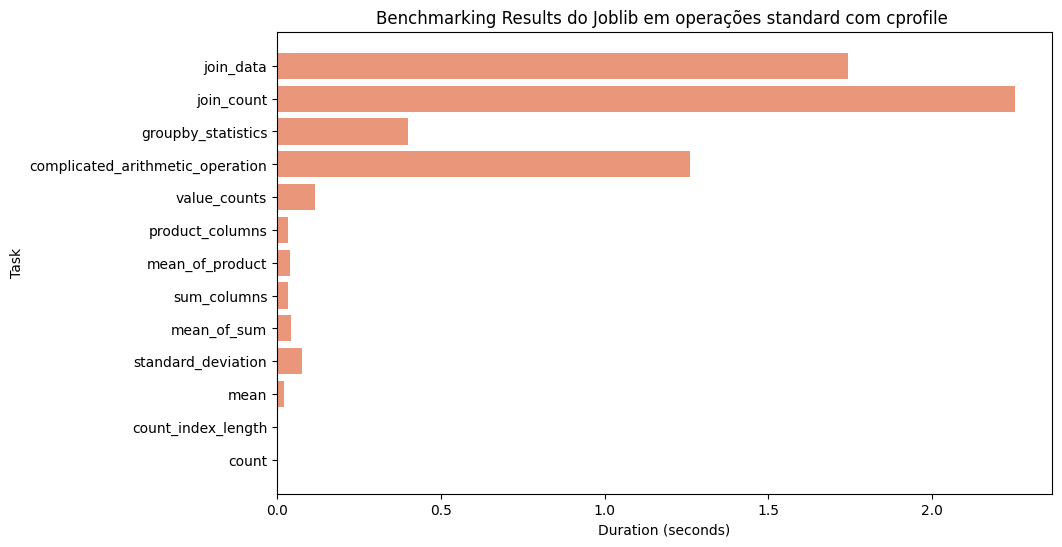

In [51]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.barh(results_joblib['task'], results_joblib['duration'], color='darksalmon')
plt.xlabel('Duration (seconds)')
plt.ylabel('Task')
plt.title('Benchmarking Results do Joblib em operações standard com cprofile ')
plt.show()

**Resultados**: as tarefas que consomem mais tempo são: `join_data`, `join_count`, `complicated_arithmetic_operation`; em contrapartida, as que consomem menos tempo são: `mean` e `product_columns`

## Gráfico Circular
- O gráfico de pizza/circular apresenta a proporção de tempo gasto em cada operação. 
- As operações de junção e operações aritméticas complexas são as que mais consomem tempo, como por exemplo: `join_data`com 28.9%; `join_count` com 37.4% e complicated_arithmetic_operation com 20.9%.
- As operações de contagem são as que menos consomem tempo, essencialmente `count` e `count_index_length`

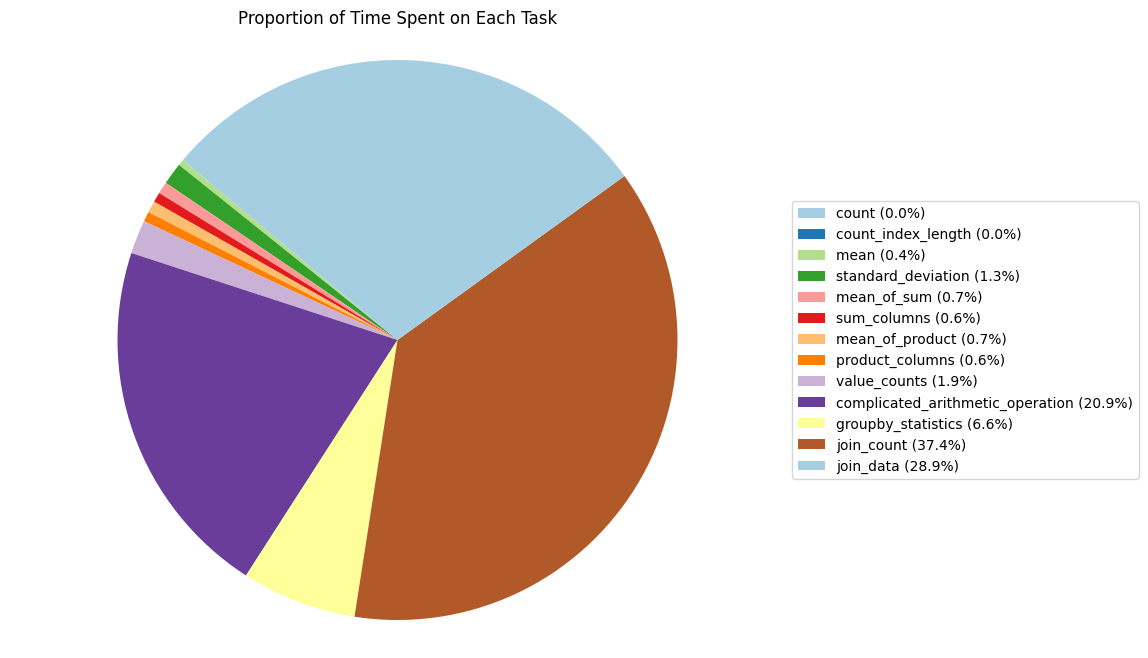

In [52]:
# Calcular percentagens
percentages = [f"{(d / sum(results_joblib['duration']) * 100):.1f}%" for d in results_joblib['duration']]
legend_labels = [f"{task} ({percentage})" for task, percentage in zip(results_joblib['task'], percentages)]

# Definir cores, com 'read file' como rosa
colors = ['darksalmon' if task == 'read file' else color for task, color in zip(results_joblib['task'], plt.cm.Paired.colors)]

# Gráfico de Pizza sem rótulos nas fatias
explode = [0.1 if i == 0 else 0 for i in range(len(results_joblib['duration']))]

plt.figure(figsize=(10, 8))
plt.pie(results_joblib['duration'], startangle=140, colors=colors,
        explode=explode, pctdistance=0.85, labeldistance=1.1)

# Garantir que os rótulos não se sobreponham
plt.axis('equal')
plt.title('Proportion of Time Spent on Each Task')
plt.legend(legend_labels, loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

### Gráfico de Linha
O gráfico de linha destaca a variação na duração das tarefas, reforçando a visualização dos tempos de execução. 


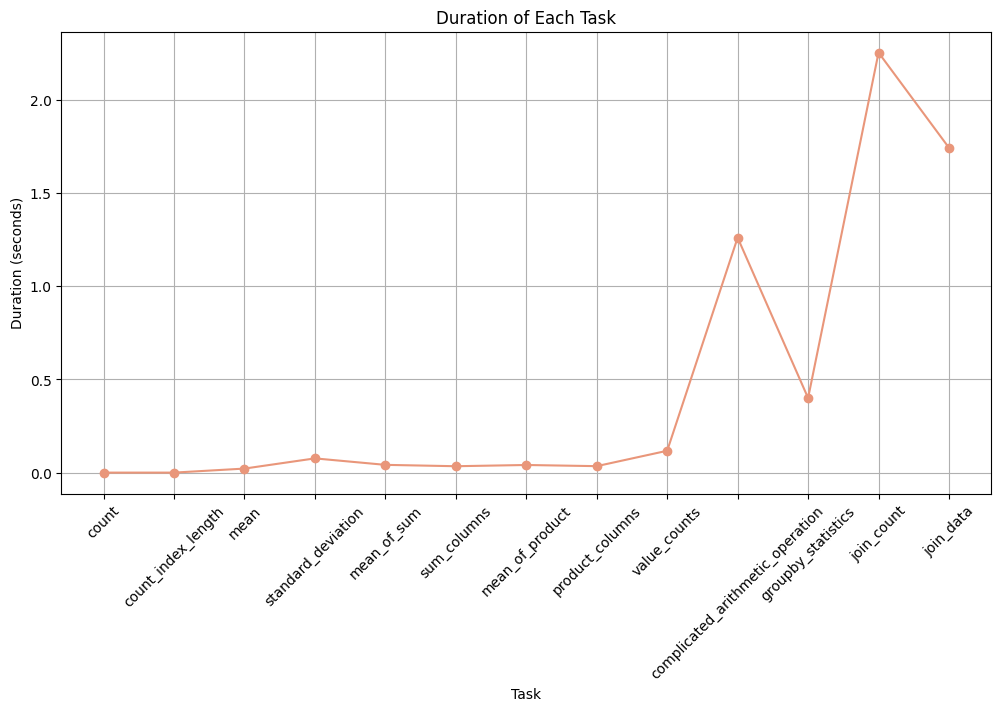

In [53]:
# Gráfico de Linha
plt.figure(figsize=(12, 6))
plt.plot(results_joblib['task'], results_joblib['duration'], marker='o', linestyle='-', color='darksalmon')
plt.xlabel('Task')
plt.ylabel('Duration (seconds)')
plt.title('Duration of Each Task')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**Conclusões para operações standard**
- Principais Consumo de Tempo: As operações de junção (`join_data`, `join_count`) e a operação aritmética complexa (`complicated_arithmetic_operation`) são as que apresentam maior duração, indicando que são as principais áreas a serem otimizadas.
- Eficiência das Operações Simples: Operações simples como contagem (`count`), média (`mean`), e soma de colunas (`sum_columns`) apresentam tempos de execução muito baixos, sugerindo que são eficientes e não necessitam de otimização imediata.


## Para dados filtrados

São apresentados os resultados dos benchmarks realizados em diversas operações de manipulação e análise de dados, utilizando a biblioteca Joblib para armazenamento e cProfile para medir o desempenho das execuções, em operações de filtering.

In [54]:
# Filtrar dados
expr_filter = (data['tip_amt'] >= 1) & (data['tip_amt'] <= 5)
filtered_data = data[expr_filter]

# Inicializar dicionários para armazenar resultados dos benchmarks com dados filtrados
joblib_benchmarks_filtered_cprofile = {'duration': [], 'task': []}

# Executar benchmarks nas operações com dados filtrados
execute_benchmarks(filtered_data, joblib_benchmarks_filtered_cprofile)


count took: 4.839897155761719e-05 seconds
count_index_length took: 7.152557373046875e-06 seconds
mean took: 0.0042209625244140625 seconds
standard_deviation took: 0.011147499084472656 seconds
mean_of_sum took: 0.00665283203125 seconds
sum_columns took: 0.005254030227661133 seconds
mean_of_product took: 0.0065953731536865234 seconds
product_columns took: 0.005234718322753906 seconds
value_counts took: 0.022112369537353516 seconds
complicated_arithmetic_operation took: 0.20274019241333008 seconds
groupby_statistics took: 0.07610273361206055 seconds
join_count took: 0.5821990966796875 seconds
join_data took: 0.30995941162109375 seconds


In [55]:
# Convert benchmark results to DataFrame
results_joblib_filtered = pd.DataFrame.from_dict(joblib_benchmarks_filtered_cprofile)

### Gráfico de Barras Horizontais em dados filtrados

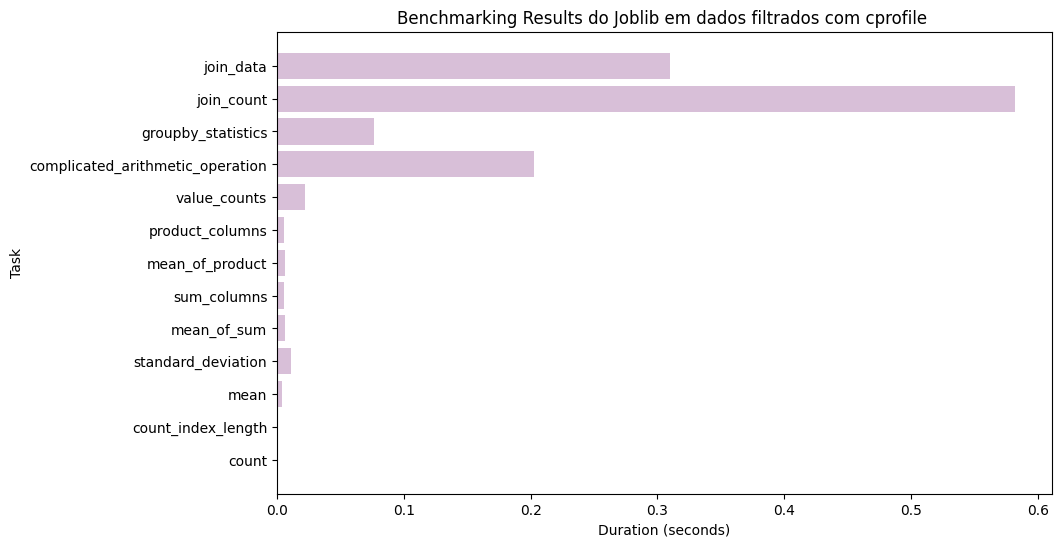

In [56]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.barh(results_joblib_filtered['task'], results_joblib_filtered['duration'], color='thistle')
plt.xlabel('Duration (seconds)')
plt.ylabel('Task')
plt.title('Benchmarking Results do Joblib em dados filtrados com cprofile ')
plt.show()

**Resultados**: as tarefas que consomem mais tempo são: `join_data`, `join_count`, `complicated_arithmetic_operation`; em contrapartida, as que consomem menos tempo são: `mean` e `product_columns`, tal como nas operações standard. Contudo a escala para valores filtrados é muito menor, onde as tarefas que consomem mais alcançam aproximadamente 0.6 segundos.

### Gráfico Circular em dados filtrados


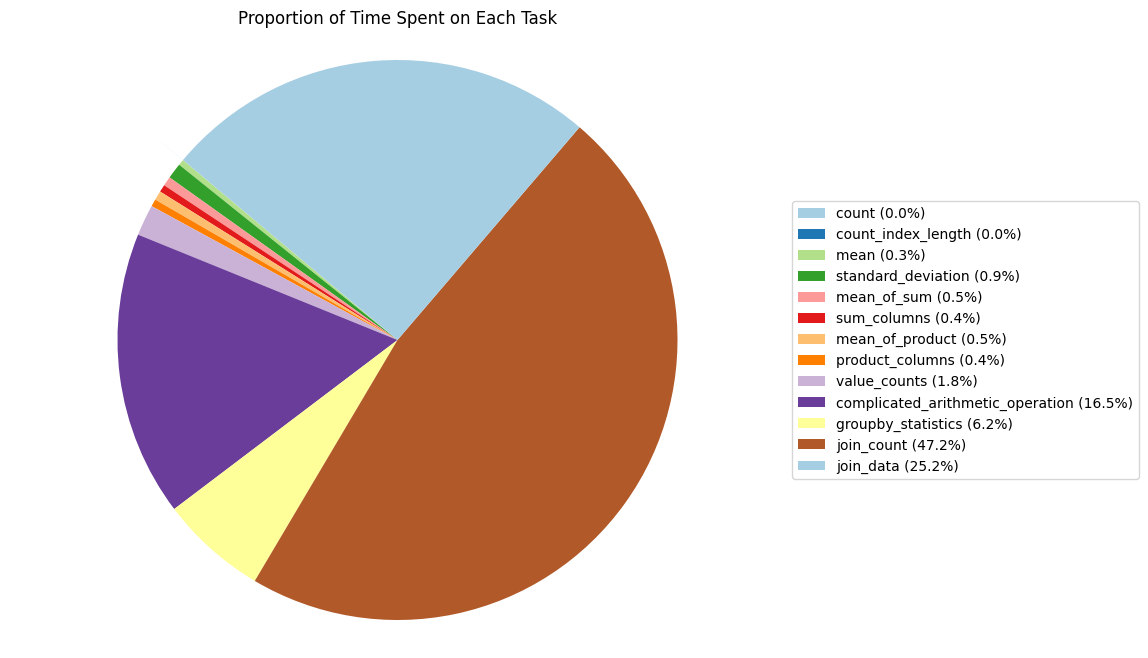

In [57]:
# Calcular percentagens
percentages = [f"{(d / sum(results_joblib_filtered['duration']) * 100):.1f}%" for d in results_joblib_filtered['duration']]
legend_labels = [f"{task} ({percentage})" for task, percentage in zip(results_joblib_filtered['task'], percentages)]

# Definir cores, com 'read file' como rosa
colors = ['thistle' if task == 'read file' else color for task, color in zip(results_joblib_filtered['task'], plt.cm.Paired.colors)]

# Gráfico de Pizza sem rótulos nas fatias
explode = [0.1 if i == 0 else 0 for i in range(len(results_joblib_filtered['duration']))]

plt.figure(figsize=(10, 8))
plt.pie(results_joblib_filtered['duration'], startangle=140, colors=colors,
        explode=explode, pctdistance=0.85, labeldistance=1.1)

# Garantir que os rótulos não se sobreponham
plt.axis('equal')
plt.title('Proportion of Time Spent on Each Task')
plt.legend(legend_labels, loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

- As operações de junção e operações aritméticas complexas são as que mais consomem tempo, como por exemplo: `join_data`com 25.2% (sofreu uma diminuição face às operações standard); `join_count` com 47.2% (sofreu um aumento face às operações standard) e complicated_arithmetic_operation com 16.5%(sofreu uma diminuição).
- As operações de contagem são as que menos consomem tempo, essencialmente `count` e `count_index_length`

### Gráfico de linhas em dados filtrados

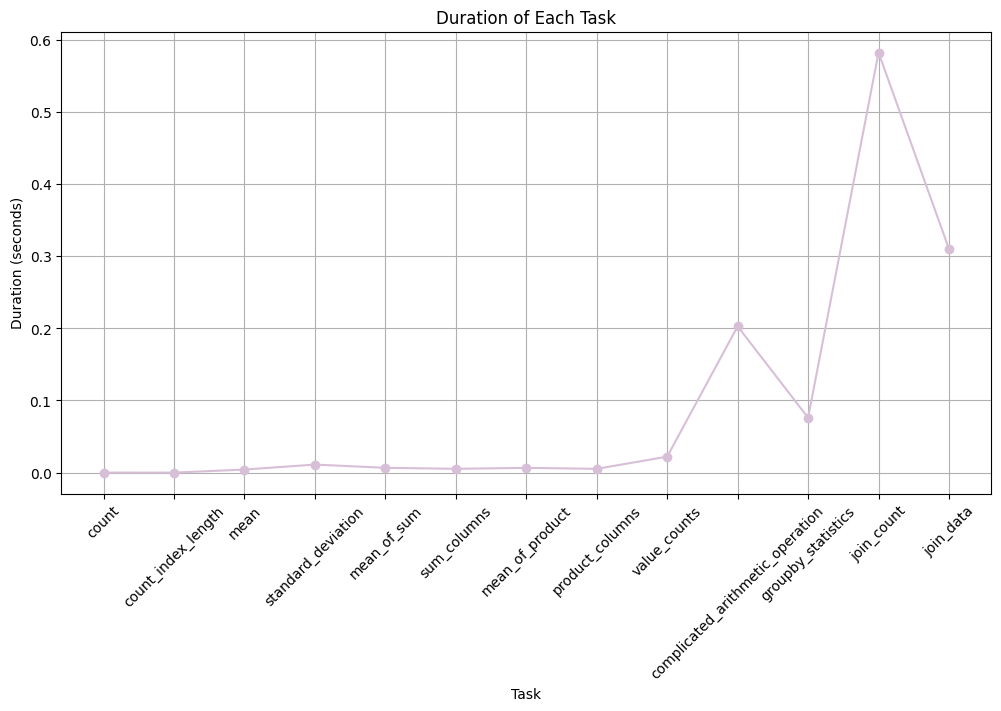

In [58]:
# Gráfico de Linha
plt.figure(figsize=(12, 6))
plt.plot(results_joblib_filtered['task'], results_joblib_filtered['duration'], marker='o', linestyle='-', color='thistle')
plt.xlabel('Task')
plt.ylabel('Duration (seconds)')
plt.title('Duration of Each Task')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**Conclusões para operações de filtering**
- Principais Consumo de Tempo: As operações de junção (`join_data`, `join_count`) e a operação aritmética complexa (`complicated_arithmetic_operation`) são as que apresentam maior duração, indicando que são as principais áreas a serem otimizadas.
- Eficiência das Operações Simples: Operações simples como contagem (`count`), média (`mean`), e soma de colunas (`sum_columns`) apresentam tempos de execução muito baixos, sugerindo que são eficientes e não necessitam de otimização imediata.
Tal como as operações standard, mas com durações menores, no máximo a arrondar os 0.6segundos.

## Para dados persistidos

São apresentados os resultados dos benchmarks realizados em diversas operações de manipulação e análise de dados, utilizando a biblioteca Joblib para armazenamento e cProfile para medir o desempenho das execuções, em dados persistidos.

In [59]:
# Inicializar dicionários para armazenar resultados dos benchmarks com dados persistidos (cache)
joblib_benchmarks_cache_cprofile = {'duration': [], 'task': []}

# Persistir dados filtrados usando Joblib
dump(filtered_data, 'filtered_data.pkl')

# Carregar dados persistidos
cached_data = load('filtered_data.pkl')

# Executar benchmarks nas operações com dados carregados do cache
execute_benchmarks(cached_data, joblib_benchmarks_cache_cprofile)


count took: 1.5735626220703125e-05 seconds
count_index_length took: 5.245208740234375e-06 seconds
mean took: 0.004300594329833984 seconds
standard_deviation took: 0.010093450546264648 seconds
mean_of_sum took: 0.005791425704956055 seconds
sum_columns took: 0.0046732425689697266 seconds
mean_of_product took: 0.005571603775024414 seconds
product_columns took: 0.00406646728515625 seconds
value_counts took: 0.020853519439697266 seconds
complicated_arithmetic_operation took: 0.20116925239562988 seconds
groupby_statistics took: 0.0763392448425293 seconds
join_count took: 0.5253517627716064 seconds
join_data took: 0.2759439945220947 seconds


In [60]:
# Convert benchmark results to DataFrame
results_joblib_cache = pd.DataFrame.from_dict(joblib_benchmarks_cache_cprofile)

### Gráfico de Barras Horizontais em dados persistidos

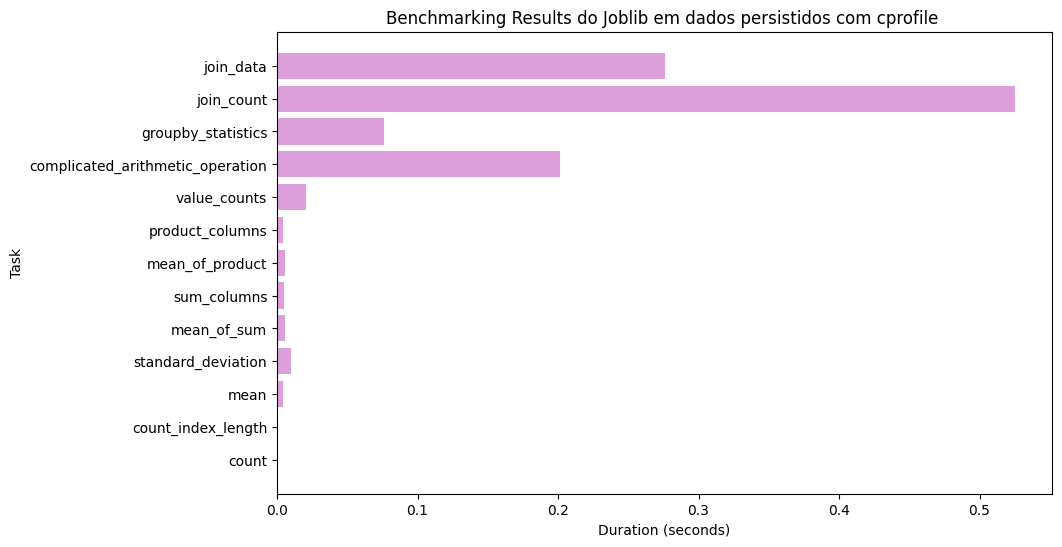

In [61]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.barh(results_joblib_cache['task'], results_joblib_cache['duration'], color='plum')
plt.xlabel('Duration (seconds)')
plt.ylabel('Task')
plt.title('Benchmarking Results do Joblib em dados persistidos com cprofile ')
plt.show()

**Resultados**: as tarefas que consomem mais tempo são: `join_data`, `join_count`, `complicated_arithmetic_operation`; em contrapartida, as que consomem menos tempo são: `mean` e `product_columns`, tal como nas operações standard e filtering. Contudo a escala para valores persistidos é menor, onde as tarefas que consomem mais alcançam aproximadamente 0.5 segundos.

### Gráfico Circular em dados persistidos

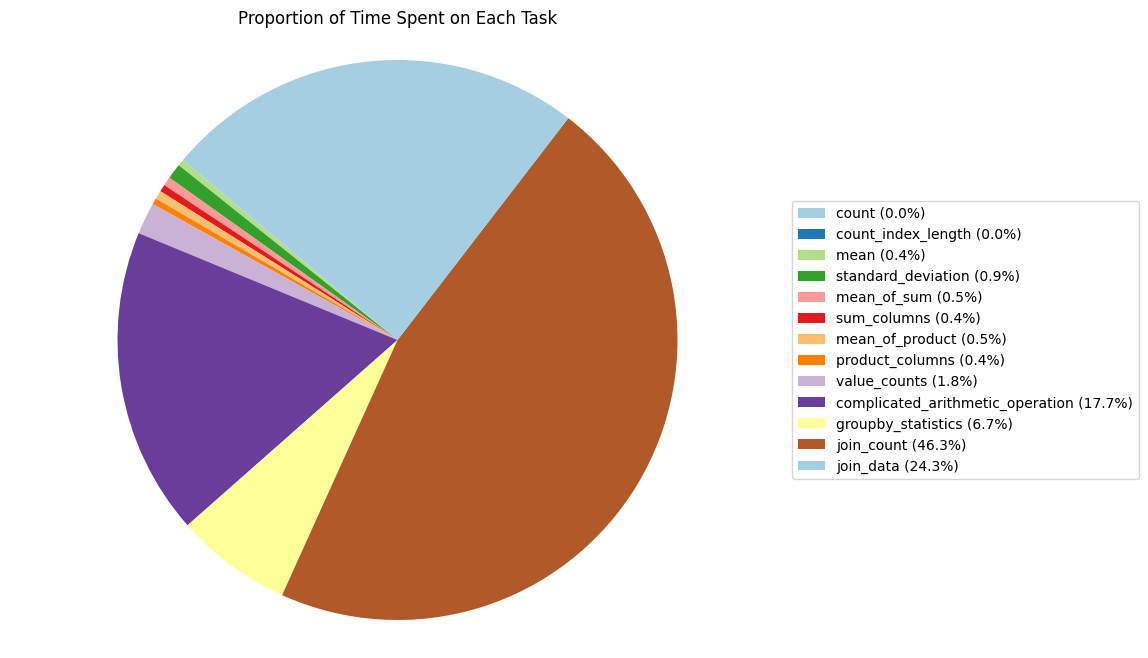

In [62]:
# Calcular percentagens
percentages = [f"{(d / sum(results_joblib_cache['duration']) * 100):.1f}%" for d in results_joblib_cache['duration']]
legend_labels = [f"{task} ({percentage})" for task, percentage in zip(results_joblib_cache['task'], percentages)]

# Definir cores, com 'read file' como rosa
colors = ['plum' if task == 'read file' else color for task, color in zip(results_joblib_cache['task'], plt.cm.Paired.colors)]

# Gráfico de Pizza sem rótulos nas fatias
explode = [0.1 if i == 0 else 0 for i in range(len(results_joblib_cache['duration']))]

plt.figure(figsize=(10, 8))
plt.pie(results_joblib_cache['duration'], startangle=140, colors=colors,
        explode=explode, pctdistance=0.85, labeldistance=1.1)

# Garantir que os rótulos não se sobreponham
plt.axis('equal')
plt.title('Proportion of Time Spent on Each Task')
plt.legend(legend_labels, loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

- As operações de junção e operações aritméticas complexas são as que mais consomem tempo, como por exemplo: `join_data`com 24.4% (sofreu uma diminuição face às operações standard e filtering); `join_count` com 46.3% (sofreu um aumento face às operações standard e uma diminuição face às filtering) e complicated_arithmetic_operation com 17.7%(sofreu uma diminuição face ás standard e um aumento face às filtering).
- As operações de contagem são as que menos consomem tempo, essencialmente `count` e `count_index_length`

### Gráfico de Linha em Dados persistidos

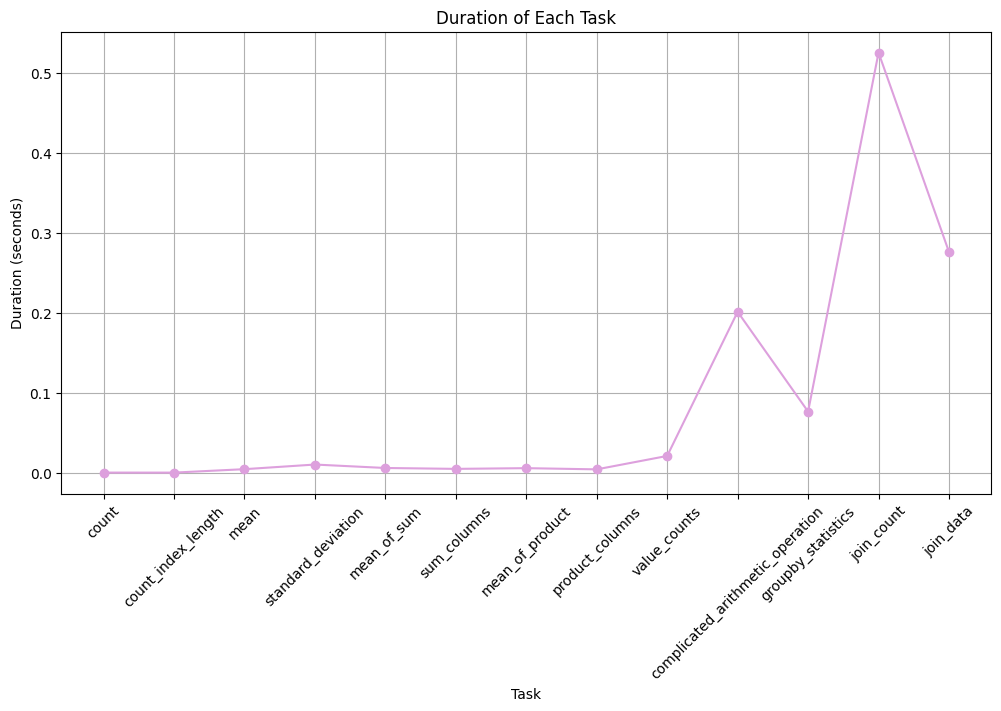

In [63]:
# Gráfico de Linha
plt.figure(figsize=(12, 6))
plt.plot(results_joblib_cache['task'], results_joblib_cache['duration'], marker='o', linestyle='-', color='plum')
plt.xlabel('Task')
plt.ylabel('Duration (seconds)')
plt.title('Duration of Each Task')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**Conclusões em dados persistidos**
- Principais Consumo de Tempo: As operações de junção (`join_data`, `join_count`) e a operação aritmética complexa (`complicated_arithmetic_operation`) são as que apresentam maior duração, indicando que são as principais áreas a serem otimizadas.
- Eficiência das Operações Simples: Operações simples como contagem (`count`), média (`mean`), e soma de colunas (`sum_columns`) apresentam tempos de execução muito baixos, sugerindo que são eficientes e não necessitam de otimização imediata.
Tal como as operações standard e filtering, mas com durações menores, no máximo a arrondar os 0.5 segundos.

## Repetir para 2 e 3 files


**Escolheu-se 2 amostras maiores:** 
- `1ª amostra`: 2 files, que correspondem aos 2 primeiros meses de 2009.
- `2ª amostra`: 3 files, que corresponde aos 3 primeiros meses de 2009.

É de denotar que todas as variáveis que tiverme um número '2' ou '3' associado, correspondem ás amostras de 2 e 3 files, respetivamente.

## Dask + Modin

In [64]:
# Read the downloaded Parquet files
parquet_files2 = ['Ficheiros/taxi_csv/yellow_tripdata_2009-01.parquet', 
                 'Ficheiros/taxi_csv/yellow_tripdata_2009-02.parquet']

parquet_files3 = [
    'Ficheiros/taxi_csv/yellow_tripdata_2009-01.parquet', 
    'Ficheiros/taxi_csv/yellow_tripdata_2009-02.parquet',
    'Ficheiros/taxi_csv/yellow_tripdata_2009-03.parquet'
]

modin_data2 = pd.read_parquet(parquet_files2)
modin_data3 = pd.read_parquet(parquet_files3)


renomeou-se as colunas para minúsculas

In [65]:
# Renomear colunas para minúsculas
modin_data2 = modin_data2.rename(columns=str.lower)
modin_data3 = modin_data3.rename(columns=str.lower)

# Exibir colunas do DataFrame
print(modin_data2.columns)
print(modin_data3.columns)

Index(['vendor_name', 'trip_pickup_datetime', 'trip_dropoff_datetime',
       'passenger_count', 'trip_distance', 'start_lon', 'start_lat',
       'rate_code', 'store_and_forward', 'end_lon', 'end_lat', 'payment_type',
       'fare_amt', 'surcharge', 'mta_tax', 'tip_amt', 'tolls_amt',
       'total_amt'],
      dtype='object')
Index(['vendor_name', 'trip_pickup_datetime', 'trip_dropoff_datetime',
       'passenger_count', 'trip_distance', 'start_lon', 'start_lat',
       'rate_code', 'store_and_forward', 'end_lon', 'end_lat', 'payment_type',
       'fare_amt', 'surcharge', 'mta_tax', 'tip_amt', 'tolls_amt',
       'total_amt'],
      dtype='object')


Definiu-se mais uma vez as funções de operações a serem medidos pelas benchmarks.

In [66]:
def get_results(benchmarks):
    """Retorna um DataFrame pandas contendo os resultados dos benchmarks"""
    return pd.DataFrame.from_dict(benchmarks)

# Funções de operações
def read_file_parquet(df=None):
    return pd.read_parquet(parquet_file)

def count(df):
    return len(df)

def count_index_length(df):
    return len(df.index)

def mean(df):
    return df['fare_amt'].mean()

def standard_deviation(df):
    return df['fare_amt'].std()

def mean_of_sum(df):
    return (df['fare_amt'] + df['tip_amt']).mean()

def sum_columns(df):
    return (df['fare_amt'] + df['tip_amt']).sum()

def mean_of_product(df):
    return (df['fare_amt'] * df['tip_amt']).mean()

def product_columns(df):
    return (df['fare_amt'] * df['tip_amt']).sum()

def value_counts(df):
    return df['fare_amt'].value_counts()

def complicated_arithmetic_operation(df):
    theta_1 = df['start_lon']
    phi_1 = df['start_lat']
    theta_2 = df['end_lon']
    phi_2 = df['end_lat']
    temp = (np.sin((theta_2 - theta_1) / 2 * np.pi / 180) ** 2
           + np.cos(theta_1 * np.pi / 180) * np.cos(theta_2 * np.pi / 180)
           * np.sin((phi_2 - phi_1) / 2 * np.pi / 180) ** 2)
    ret = 2 * np.arctan2(np.sqrt(temp), np.sqrt(1 - temp))
    return ret.mean()

def groupby_statistics(df):
    return df.groupby(by='passenger_count').agg({
        'fare_amt': ['mean', 'std'], 
        'tip_amt': ['mean', 'std']
    })

def join_count(df, other):
    return len(df.merge(other, left_index=True, right_index=True))

def join_data(df, other):
    return df.merge(other, left_index=True, right_index=True)


Função de benchmark

In [67]:
# Funções de benchmark
def benchmark(f, df, benchmarks, name, **kwargs):
    """Mede a duração da execução de uma função específica"""
    start_time = time.time()
    ret = f(df, **kwargs)
    benchmarks['duration'].append(time.time() - start_time)
    benchmarks['task'].append(name)
    print(f"{name} took: {benchmarks['duration'][-1]} seconds")
    return benchmarks['duration'][-1]

Lista `dfs` que contém `modin_data2`, uma amostra de 2 files do dataset original e `modin_data3`, uma amostra de 3 files do dataset original, usando Dask+Modin.

In [68]:
dfs = [modin_data2,modin_data3]

## Operações standard

Inicializou-se dicionários para armazenar os resultados dos benchmarks do Modin + Dask:
- `modin_benchmarks2`: para a amostra de 2 files
- `modin_benchmarks3`: para a amostra de 3 files

In [69]:
# Inicializar dicionários para armazenar resultados dos benchmarks
modin_benchmarks2 = {'duration': [], 'task': []}
modin_benchmarks3 = {'duration': [], 'task': []}

Cálculo das Benchmarks para cada operação e para cada amostra.

In [70]:
for i, df in enumerate(dfs):
    benchmark(count, df, benchmarks=globals()[f'modin_benchmarks{i+2}'], name=f'cache count')
    benchmark(count_index_length, df, benchmarks=globals()[f'modin_benchmarks{i+2}'], name=f'cache count index length')
    benchmark(mean, df, benchmarks=globals()[f'modin_benchmarks{i+2}'], name=f'cache mean')
    benchmark(standard_deviation, df, benchmarks=globals()[f'modin_benchmarks{i+2}'], name=f'cache standard deviation')
    benchmark(mean_of_sum, df, benchmarks=globals()[f'modin_benchmarks{i+2}'], name=f'cache mean of columns addition')
    benchmark(sum_columns, df, benchmarks=globals()[f'modin_benchmarks{i+2}'], name=f'cache addition of columns')
    benchmark(mean_of_product, df, benchmarks=globals()[f'modin_benchmarks{i+2}'], name=f'cache mean of columns multiplication')
    benchmark(product_columns, df, benchmarks=globals()[f'modin_benchmarks{i+2}'], name=f'cache multiplication of columns')
    #benchmark(mean_of_complicated_arithmetic_operation, df, benchmarks=globals()[f'modin_benchmarks{i+2}'], name=f'cache mean of complex arithmetic ops')
    benchmark(complicated_arithmetic_operation, df, benchmarks=globals()[f'modin_benchmarks{i+2}'], name=f'cache complex arithmetic ops')
    benchmark(value_counts, df, benchmarks=globals()[f'modin_benchmarks{i+2}'], name=f'cache value counts')
    benchmark(groupby_statistics, df, benchmarks=globals()[f'modin_benchmarks{i+2}'], name=f'cache groupby statistics')


cache count took: 1.7881393432617188e-05 seconds
cache count index length took: 1.430511474609375e-06 seconds
cache mean took: 0.0437006950378418 seconds
cache standard deviation took: 0.1521739959716797 seconds
cache mean of columns addition took: 0.08163595199584961 seconds
cache addition of columns took: 0.0681772232055664 seconds
cache mean of columns multiplication took: 0.07937884330749512 seconds
cache multiplication of columns took: 0.06294417381286621 seconds
cache complex arithmetic ops took: 2.422942876815796 seconds
cache value counts took: 0.21904706954956055 seconds
cache groupby statistics took: 0.7882883548736572 seconds
cache count took: 6.4373016357421875e-06 seconds
cache count index length took: 1.9073486328125e-06 seconds
cache mean took: 0.06526327133178711 seconds
cache standard deviation took: 0.22107934951782227 seconds
cache mean of columns addition took: 0.12036776542663574 seconds
cache addition of columns took: 0.0997922420501709 seconds
cache mean of colum

Observa-se que as operações de contagem e comprimento do índice são extremamente rápidas, enquanto operações aritméticas complexas e estatísticas de agrupamento exigem mais tempo de processamento. A diferença nos tempos entre os dois DataFrames também sugere variações no tamanho e complexidade dos dados.

**Operações no DataFrame 1**

1. Contagem de Registros:
- Tempo: 1.7881393432617188e-05 segundos

2. Contagem de Comprimento do Índice:
- Tempo: 1.430511474609375e-06 segundos

3. Média:
- Tempo: 0.0437006950378418 segundos

4. Desvio Padrão:
- Tempo: 0.1521739959716797 segundos

5. Média da Soma das Colunas:
- Tempo: 0.08163595199584961 segundos

6. Soma das Colunas:
- Tempo: 0.0681772232055664 segundos

7. Média da Multiplicação das Colunas:
- Tempo: 0.07937884330749512 segundos

8. Multiplicação das Colunas:
- Tempo: 0.06294417381286621 segundos

9. Operações Aritméticas Complexas:
- Tempo: 2.422942876815796 segundos

10. Contagem de Valores:
- Tempo: 0.21904706954956055 segundos

11. Estatísticas de Agrupamento:
- Tempo: 0.7882883548736572 segundos

**Operações no DataFrame 2**

1. Contagem de Registros:
- Tempo: 6.4373016357421875e-06 segundos

2. Contagem de Comprimento do Índice:
- Tempo: 1.9073486328125e-06 segundos

3. Média:
- Tempo: 0.06526327133178711 segundos

4. Desvio Padrão:
- Tempo: 0.22107934951782227 segundos

5. Média da Soma das Colunas:
- Tempo: 0.12036776542663574 segundos

6. Soma das Colunas:
- Tempo: 0.0997922420501709 segundos

7. Média da Multiplicação das Colunas:
- Tempo: 0.125105619430542 segundos

8. Multiplicação das Colunas:
- Tempo: 0.10132765769958496 segundos

9. Operações Aritméticas Complexas:
- Tempo: 3.681814193725586 segundos

10. Contagem de Valores:
- Tempo: 0.3255879878997803 segundos

11. Estatísticas de Agrupamento:
- Tempo: 1.183720350265503 segundos


### Salvar Resultados

In [71]:
# Obter os resultados e remover duplicatas
modin_res_temp2 = get_results(modin_benchmarks2).drop_duplicates(subset='task').set_index('task')
modin_res_temp3 = get_results(modin_benchmarks3).drop_duplicates(subset='task').set_index('task')

# Print dos dataframes
print(modin_res_temp2)
print(modin_res_temp3)

# Definir o nome do arquivo ou diretório
filename2 = 'Resultados/modin_standard2'
filename3 = 'Resultados/modin_standard3'

# Salvar o DataFrame em formato Parquet
modin_res_temp2.to_parquet(filename2)
modin_res_temp3.to_parquet(filename3)

print(f'O arquivo Parquet foi salvo em {filename2}.')
print(f'O arquivo Parquet foi salvo em {filename3}.')


                                      duration
task                                          
cache count                           0.000018
cache count index length              0.000001
cache mean                            0.043701
cache standard deviation              0.152174
cache mean of columns addition        0.081636
cache addition of columns             0.068177
cache mean of columns multiplication  0.079379
cache multiplication of columns       0.062944
cache complex arithmetic ops          2.422943
cache value counts                    0.219047
cache groupby statistics              0.788288
                                      duration
task                                          
cache count                           0.000006
cache count index length              0.000002
cache mean                            0.065263
cache standard deviation              0.221079
cache mean of columns addition        0.120368
cache addition of columns             0.099792
cache mean of

### Usar o cprofile para a amostra de 2 files e a amostra de 3 files

In [72]:
import cProfile
import matplotlib.pyplot as plt
from io import StringIO
import pstats

In [73]:
# Define your benchmark function to use cProfile
def benchmark_with_cprofile(f, df, benchmarks, name, **kwargs):
    """Mede a duração da execução de uma função específica usando cProfile"""
    pr = cProfile.Profile()
    pr.enable()
    
    start_time = time.time()
    ret = f(df, **kwargs)
    benchmarks['duration'].append(time.time() - start_time)
    benchmarks['task'].append(name)
    print(f"{name} took: {benchmarks['duration'][-1]} seconds")
    
    pr.disable()
    pr.print_stats(sort='cumtime')  # Print profiling results sorted by cumulative time
    
    return benchmarks['duration'][-1]

In [74]:
modin_benchmarks2_cprofile = {'duration': [], 'task': []}
modin_benchmarks3_cprofile = {'duration': [], 'task': []}

In [76]:
modin_data = [modin_data2,modin_data3]

#### Benchmark com cprofile para `modin_data2` (amostra de 2 files-2primeiros meses de 2009)

In [77]:
benchmark_with_cprofile(count, modin_data[0], benchmarks=globals()[f'modin_benchmarks2_cprofile'], name=f'cache count')
benchmark_with_cprofile(count_index_length, modin_data[0], benchmarks=globals()[f'modin_benchmarks2_cprofile'], name=f'cache count index length')
benchmark_with_cprofile(mean, modin_data[0], benchmarks=globals()[f'modin_benchmarks2_cprofile'], name=f'cache mean')
benchmark_with_cprofile(standard_deviation, modin_data[0], benchmarks=globals()[f'modin_benchmarks2_cprofile'], name=f'cache standard deviation')
benchmark_with_cprofile(mean_of_sum, modin_data[0], benchmarks=globals()[f'modin_benchmarks2_cprofile'], name=f'cache mean of columns addition')
benchmark_with_cprofile(sum_columns, modin_data[0], benchmarks=globals()[f'modin_benchmarks2_cprofile'], name=f'cache addition of columns')
benchmark_with_cprofile(mean_of_product, modin_data[0], benchmarks=globals()[f'modin_benchmarks2_cprofile'], name=f'cache mean of columns multiplication')
benchmark_with_cprofile(product_columns, modin_data[0], benchmarks=globals()[f'modin_benchmarks2_cprofile'], name=f'cache multiplication of columns')
#benchmark_with_cprofile(mean_of_complicated_arithmetic_operation, modin_data[0], benchmarks=globals()[f'modin_benchmarks2_cprofile'], name=f'cache mean of complex arithmetic ops')
benchmark_with_cprofile(complicated_arithmetic_operation, modin_data[0], benchmarks=globals()[f'modin_benchmarks2_cprofile'], name=f'cache complex arithmetic ops')
benchmark_with_cprofile(value_counts, modin_data[0], benchmarks=globals()[f'modin_benchmarks2_cprofile'], name=f'cache value counts')
benchmark_with_cprofile(groupby_statistics, modin_data[0], benchmarks=globals()[f'modin_benchmarks2_cprofile'], name=f'cache groupby statistics')


cache count took: 2.09808349609375e-05 seconds
         42 function calls (40 primitive calls) in 0.000 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.print}
        2    0.000    0.000    0.000    0.000 iostream.py:655(write)
        2    0.000    0.000    0.000    0.000 iostream.py:577(_schedule_flush)
        1    0.000    0.000    0.000    0.000 iostream.py:259(schedule)
        1    0.000    0.000    0.000    0.000 iostream.py:138(_event_pipe)
        1    0.000    0.000    0.000    0.000 socket.py:626(send)
        1    0.000    0.000    0.000    0.000 1601532002.py:9(count)
      5/3    0.000    0.000    0.000    0.000 {built-in method builtins.len}
        1    0.000    0.000    0.000    0.000 frame.py:1352(__len__)
        1    0.000    0.000    0.000    0.000 threading.py:1071(is_alive)
        2    0.000    0.000    0.000    0.000 iostream

0.7764847278594971

In [78]:
# Convert benchmark results to DataFrame
results_modin2 = pd.DataFrame.from_dict(modin_benchmarks2_cprofile)

#### Benchmark com cprofile para `modin_data3` (amostra de 3 files-3primeiros meses de 2009)

In [79]:
benchmark_with_cprofile(count, modin_data[1], benchmarks=globals()[f'modin_benchmarks3_cprofile'], name=f'cache count')
benchmark_with_cprofile(count_index_length, modin_data[1], benchmarks=globals()[f'modin_benchmarks3_cprofile'], name=f'cache count index length')
benchmark_with_cprofile(mean, modin_data[1], benchmarks=globals()[f'modin_benchmarks3_cprofile'], name=f'cache mean')
benchmark_with_cprofile(standard_deviation, modin_data[1], benchmarks=globals()[f'modin_benchmarks3_cprofile'], name=f'cache standard deviation')
benchmark_with_cprofile(mean_of_sum, modin_data[1], benchmarks=globals()[f'modin_benchmarks3_cprofile'], name=f'cache mean of columns addition')
benchmark_with_cprofile(sum_columns, modin_data[1], benchmarks=globals()[f'modin_benchmarks3_cprofile'], name=f'cache addition of columns')
benchmark_with_cprofile(mean_of_product, modin_data[1], benchmarks=globals()[f'modin_benchmarks3_cprofile'], name=f'cache mean of columns multiplication')
benchmark_with_cprofile(product_columns, modin_data[1], benchmarks=globals()[f'modin_benchmarks3_cprofile'], name=f'cache multiplication of columns')
#benchmark_with_cprofile(mean_of_complicated_arithmetic_operation, modin_data[1], benchmarks=globals()[f'modin_benchmarks3_cprofile'], name=f'cache mean of complex arithmetic ops')
benchmark_with_cprofile(complicated_arithmetic_operation, modin_data[1], benchmarks=globals()[f'modin_benchmarks3_cprofile'], name=f'cache complex arithmetic ops')
benchmark_with_cprofile(value_counts, modin_data[1], benchmarks=globals()[f'modin_benchmarks3_cprofile'], name=f'cache value counts')
benchmark_with_cprofile(groupby_statistics, modin_data[1], benchmarks=globals()[f'modin_benchmarks3_cprofile'], name=f'cache groupby statistics')


cache count took: 2.0742416381835938e-05 seconds
         42 function calls (40 primitive calls) in 0.000 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.print}
        2    0.000    0.000    0.000    0.000 iostream.py:655(write)
        2    0.000    0.000    0.000    0.000 iostream.py:577(_schedule_flush)
        1    0.000    0.000    0.000    0.000 iostream.py:259(schedule)
        1    0.000    0.000    0.000    0.000 socket.py:626(send)
        1    0.000    0.000    0.000    0.000 1601532002.py:9(count)
      5/3    0.000    0.000    0.000    0.000 {built-in method builtins.len}
        1    0.000    0.000    0.000    0.000 frame.py:1352(__len__)
        1    0.000    0.000    0.000    0.000 range.py:806(__len__)
        1    0.000    0.000    0.000    0.000 threading.py:1071(is_alive)
        2    0.000    0.000    0.000    0.000 iostream.py:5

1.189143419265747

In [81]:
# Convert benchmark results to DataFrame
results_modin3 = pd.DataFrame.from_dict(modin_benchmarks3_cprofile)

### Gráfico de Barras Horizontais em operações standard com cprofile: Amostra de 2 files

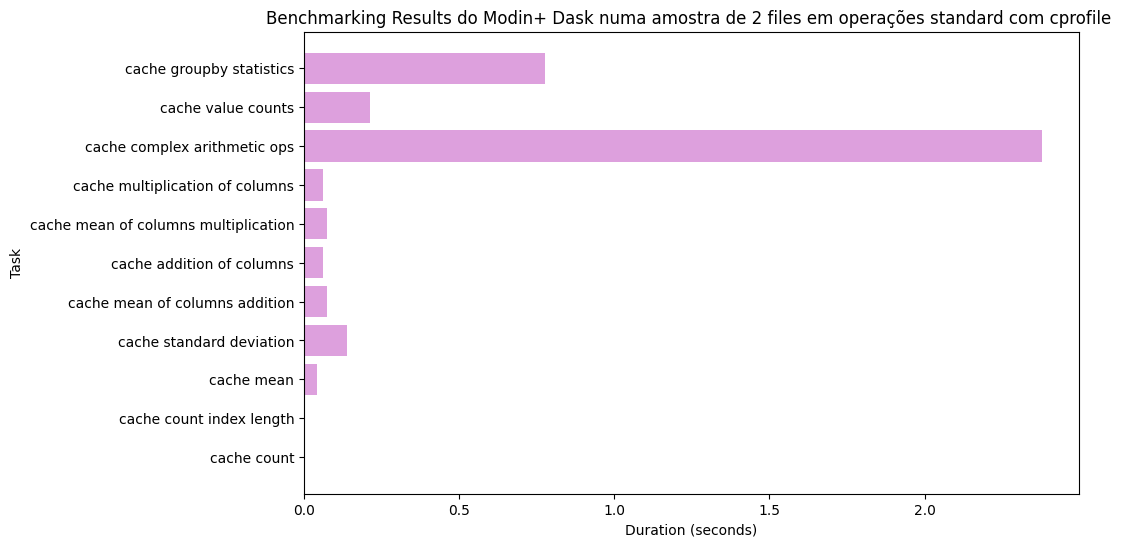

In [82]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.barh(results_modin2['task'], results_modin2['duration'], color='plum')
plt.xlabel('Duration (seconds)')
plt.ylabel('Task')
plt.title('Benchmarking Results do Modin+ Dask numa amostra de 2 files em operações standard com cprofile ')
plt.show()

### Gráfico de Barras Horizontais em operações standard com cprofile: Amostra de 3 files

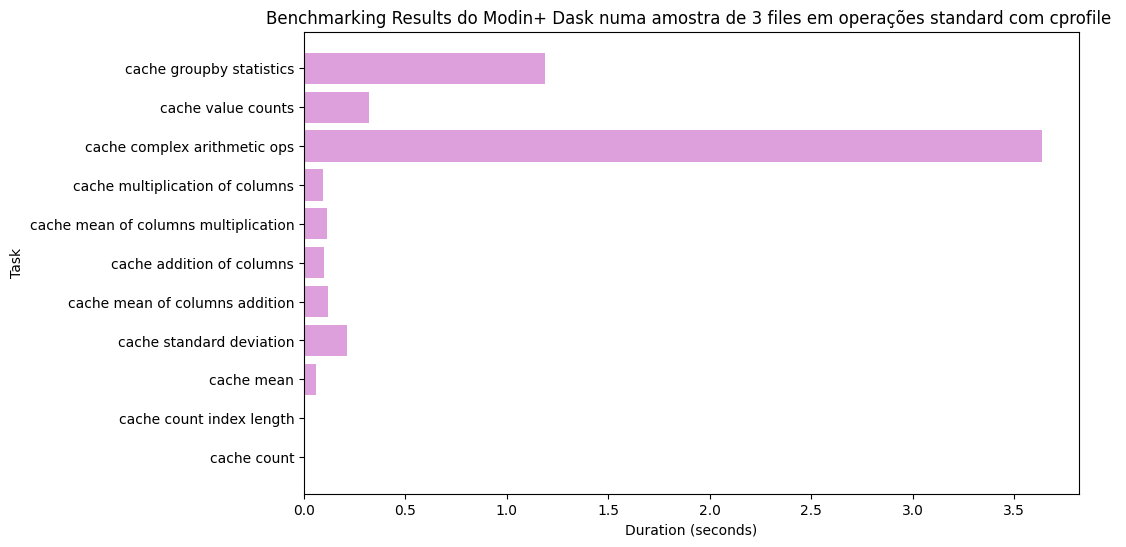

In [83]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.barh(results_modin3['task'], results_modin3['duration'], color='plum')
plt.xlabel('Duration (seconds)')
plt.ylabel('Task')
plt.title('Benchmarking Results do Modin+ Dask numa amostra de 3 files em operações standard com cprofile ')
plt.show()

As tarefas que demoram mais tempo são `cache complex arithmetic ops`e `cache groupby statistic`, como se previa a amostra de 3 files demora mais tempo.

### Gráfico Circular em operações standard com cprofile: Amostra de 2 files

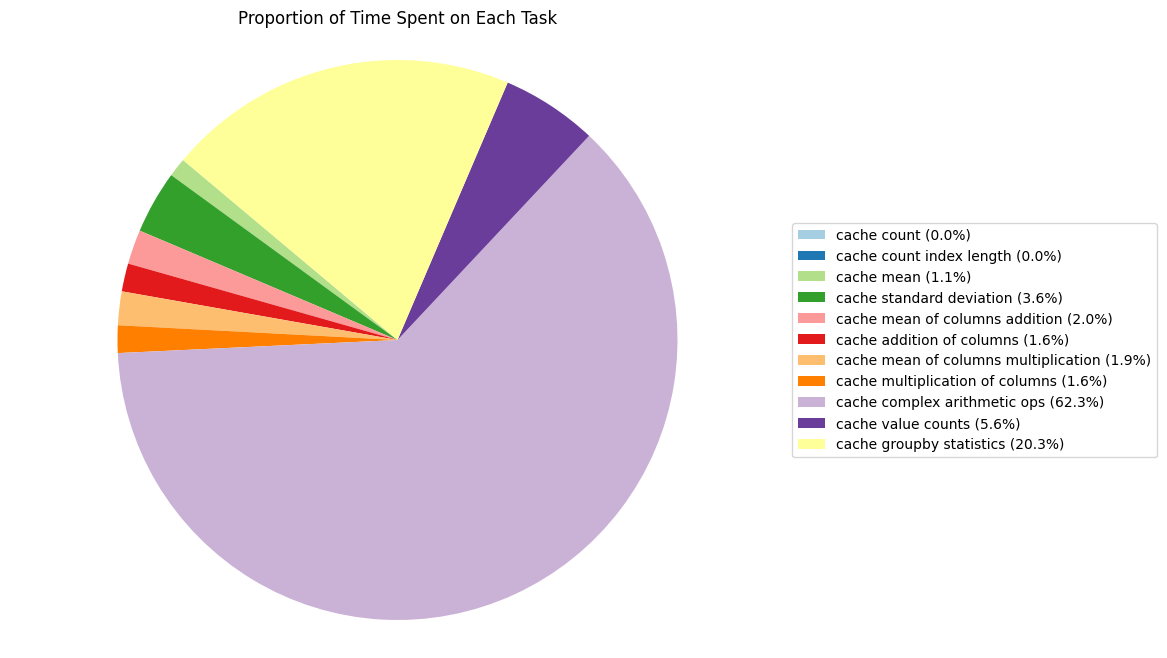

In [85]:
# Calcular percentagens
percentages = [f"{(d / sum(results_modin2['duration']) * 100):.1f}%" for d in results_modin2['duration']]
legend_labels = [f"{task} ({percentage})" for task, percentage in zip(results_modin2['task'], percentages)]

# Definir cores, com 'read file' como rosa
colors = ['plum' if task == 'read file' else color for task, color in zip(results_modin2['task'], plt.cm.Paired.colors)]

# Gráfico de Pizza sem rótulos nas fatias
explode = [0.1 if i == 0 else 0 for i in range(len(results_modin2['duration']))]

plt.figure(figsize=(10, 8))
plt.pie(results_modin2['duration'], startangle=140, colors=colors,
        explode=explode, pctdistance=0.85, labeldistance=1.1)

# Garantir que os rótulos não se sobreponham
plt.axis('equal')
plt.title('Proportion of Time Spent on Each Task')
plt.legend(legend_labels, loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

### Gráfico Circular em operações standard com cprofile: Amostra de 3 files

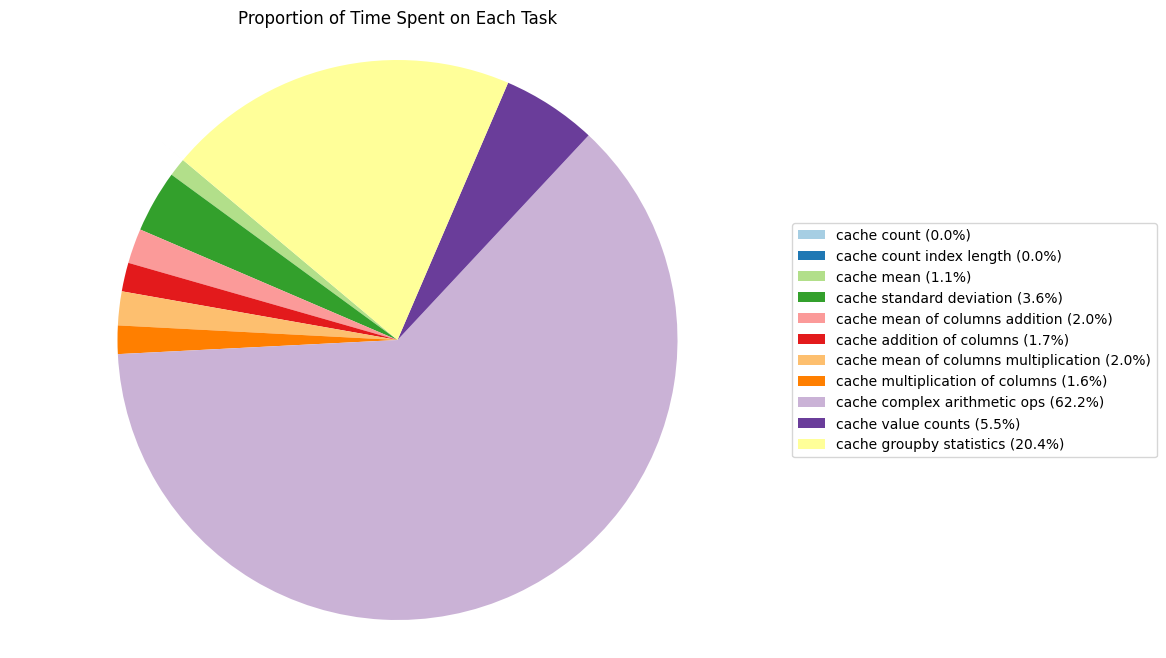

In [86]:
# Calcular percentagens
percentages = [f"{(d / sum(results_modin3['duration']) * 100):.1f}%" for d in results_modin3['duration']]
legend_labels = [f"{task} ({percentage})" for task, percentage in zip(results_modin3['task'], percentages)]

# Definir cores, com 'read file' como rosa
colors = ['plum' if task == 'read file' else color for task, color in zip(results_modin3['task'], plt.cm.Paired.colors)]

# Gráfico de Pizza sem rótulos nas fatias
explode = [0.1 if i == 0 else 0 for i in range(len(results_modin3['duration']))]

plt.figure(figsize=(10, 8))
plt.pie(results_modin3['duration'], startangle=140, colors=colors,
        explode=explode, pctdistance=0.85, labeldistance=1.1)

# Garantir que os rótulos não se sobreponham
plt.axis('equal')
plt.title('Proportion of Time Spent on Each Task')
plt.legend(legend_labels, loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

- As operações `cache complex arithmetic ops`e `cache groupby statistics`são as fatias que demora mais tempo, para a amostra 2 o primeiro demora 62.3% e para a amostra 3 62.2%, o segundo demora 20.3% para a amostra 2 e 20.4% para a amostra 3.

### Gráfico de linhas em operações standard com cprofile: Amostra de 2 files 

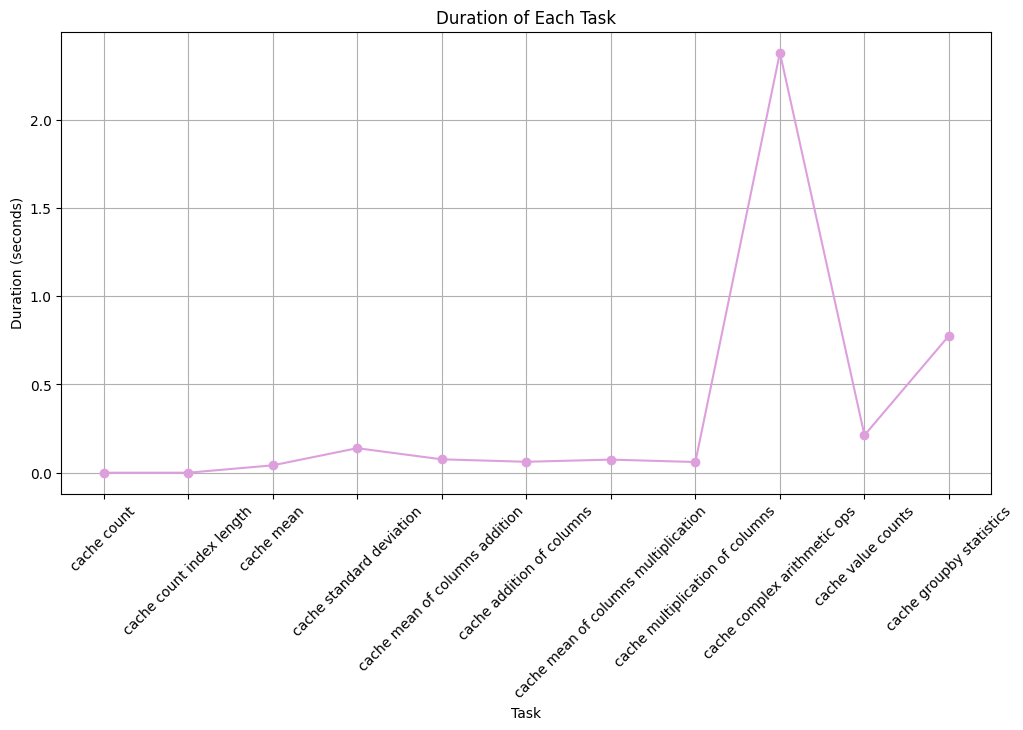

In [87]:
# Gráfico de Linha
plt.figure(figsize=(12, 6))
plt.plot(results_modin2['task'], results_modin2['duration'], marker='o', linestyle='-', color='plum')
plt.xlabel('Task')
plt.ylabel('Duration (seconds)')
plt.title('Duration of Each Task')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Gráfico de linhas em operações standard com cprofile: Amostra de 3 files 

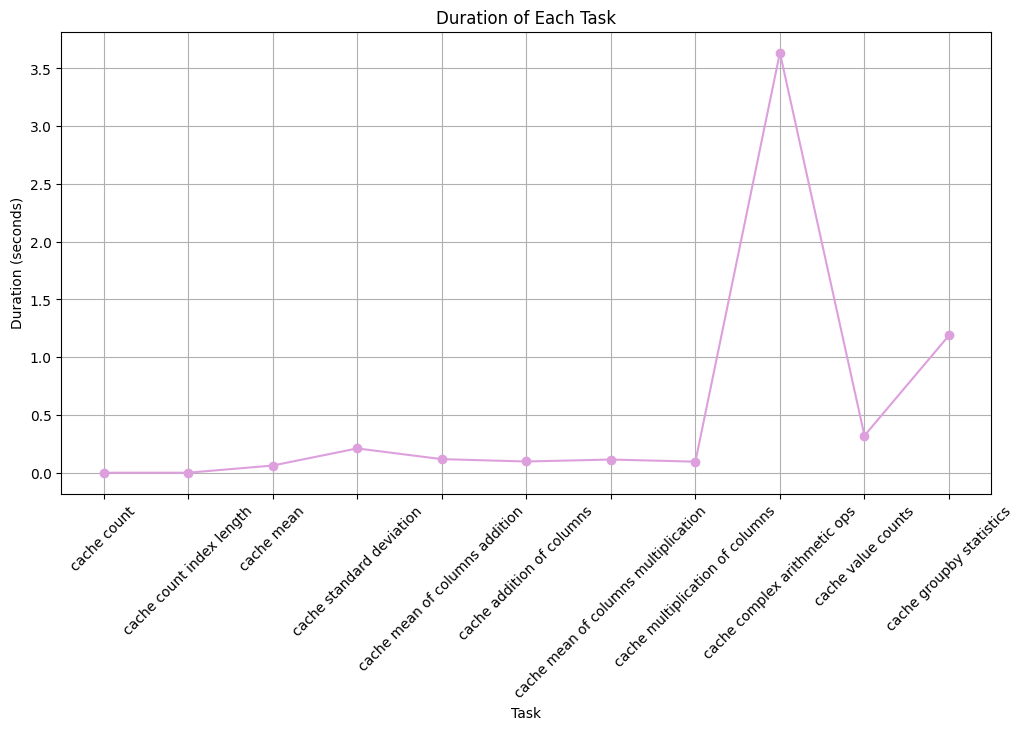

In [88]:
# Gráfico de Linha
plt.figure(figsize=(12, 6))
plt.plot(results_modin3['task'], results_modin3['duration'], marker='o', linestyle='-', color='plum')
plt.xlabel('Task')
plt.ylabel('Duration (seconds)')
plt.title('Duration of Each Task')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**Conclusões em dados standard**
- Principais Consumo de Tempo: As operações `cache complex arithmetic ops`e `cache groupby statistics`são as que apresentam maior duração, indicando que são as principais áreas a serem otimizadas.

## Operações de filtering

In [89]:
print(f"Tipo do DataFrame : {type(modin_data2)}")

# Filtrar dados usando query para manter Modin DataFrame
expr_filter2 = 'tip_amt >= 1 and tip_amt <= 5'
modin_filtered2 = modin_data2.query(expr_filter2)
print(f"Tipo do DataFrame filtrado: {type(modin_filtered2)}")

# Converter para Modin novamente, se necessário
if not isinstance(modin_filtered2, pd.DataFrame):
    modin_filtered2 = pd.DataFrame(modin_filtered2)

# Verificar o tipo do DataFrame filtrado
print(f"Tipo do DataFrame filtrado: {type(modin_filtered2)}")


# Inicializar dicionários para armazenar resultados dos benchmarks
modin_benchmarks_filtered2 = {'duration': [], 'task': []}

Tipo do DataFrame : <class 'pandas.core.frame.DataFrame'>
Tipo do DataFrame filtrado: <class 'pandas.core.frame.DataFrame'>
Tipo do DataFrame filtrado: <class 'pandas.core.frame.DataFrame'>


In [90]:
print(f"Tipo do DataFrame : {type(modin_data3)}")

# Filtrar dados usando query para manter Modin DataFrame
expr_filter3 = 'tip_amt >= 1 and tip_amt <= 5'
modin_filtered3 = modin_data3.query(expr_filter3)
print(f"Tipo do DataFrame filtrado: {type(modin_filtered3)}")

# Converter para Modin novamente, se necessário
if not isinstance(modin_filtered3, pd.DataFrame):
    modin_filtered3 = pd.DataFrame(modin_filtered3)

# Verificar o tipo do DataFrame filtrado
print(f"Tipo do DataFrame filtrado: {type(modin_filtered3)}")


# Inicializar dicionários para armazenar resultados dos benchmarks
modin_benchmarks_filtered3 = {'duration': [], 'task': []}

Tipo do DataFrame : <class 'pandas.core.frame.DataFrame'>
Tipo do DataFrame filtrado: <class 'pandas.core.frame.DataFrame'>
Tipo do DataFrame filtrado: <class 'pandas.core.frame.DataFrame'>


#### Benchmarks para Dados filtrados usando as bibliotecas Dask+Modin

In [91]:
modin_filtered = [modin_filtered2,modin_filtered3]

In [94]:
for i, df in enumerate(modin_filtered):
    benchmark(count, df, benchmarks=globals()[f'modin_benchmarks_filtered{i+2}'], name=f'cache count')
    benchmark(count_index_length, df, benchmarks=globals()[f'modin_benchmarks_filtered{i+2}'], name=f'cache count index length')
    benchmark(mean, df, benchmarks=globals()[f'modin_benchmarks_filtered{i+2}'], name=f'cache mean')
    benchmark(standard_deviation, df, benchmarks=globals()[f'modin_benchmarks_filtered{i+2}'], name=f'cache standard deviation')
    benchmark(mean_of_sum, df, benchmarks=globals()[f'modin_benchmarks_filtered{i+2}'], name=f'cache mean of columns addition')
    benchmark(sum_columns, df, benchmarks=globals()[f'modin_benchmarks_filtered{i+2}'], name=f'cache addition of columns')
    benchmark(mean_of_product, df, benchmarks=globals()[f'modin_benchmarks_filtered{i+2}'], name=f'cache mean of columns multiplication')
    benchmark(product_columns, df, benchmarks=globals()[f'modin_benchmarks_filtered{i+2}'], name=f'cache multiplication of columns')
    #benchmark(mean_of_complicated_arithmetic_operation, df, benchmarks=globals()[f'modin_benchmarks_filtered{i+2}'], name=f'cache mean of complex arithmetic ops')
    benchmark(complicated_arithmetic_operation, df, benchmarks=globals()[f'modin_benchmarks_filtered{i+2}'], name=f'cache complex arithmetic ops')
    benchmark(value_counts, df, benchmarks=globals()[f'modin_benchmarks_filtered{i+2}'], name=f'cache value counts')
    benchmark(groupby_statistics, df, benchmarks=globals()[f'modin_benchmarks_filtered{i+2}'], name=f'cache groupby statistics')


cache count took: 1.6450881958007812e-05 seconds
cache count index length took: 2.6226043701171875e-06 seconds
cache mean took: 0.007982254028320312 seconds
cache standard deviation took: 0.024983644485473633 seconds
cache mean of columns addition took: 0.012899637222290039 seconds
cache addition of columns took: 0.009831428527832031 seconds
cache mean of columns multiplication took: 0.012990713119506836 seconds
cache multiplication of columns took: 0.01076507568359375 seconds
cache complex arithmetic ops took: 0.44655895233154297 seconds
cache value counts took: 0.04024100303649902 seconds
cache groupby statistics took: 0.1544935703277588 seconds
cache count took: 5.245208740234375e-06 seconds
cache count index length took: 1.9073486328125e-06 seconds
cache mean took: 0.011838436126708984 seconds
cache standard deviation took: 0.03801846504211426 seconds
cache mean of columns addition took: 0.018801450729370117 seconds
cache addition of columns took: 0.015079259872436523 seconds
cache

Os benchmarks foram realizados em duas diferentes configurações de DataFrames filtrados (modin_filtered) utilizando várias operações. Abaixo está o desempenho medido em segundos para cada operação:

**Operações no DataFrame Filtrado 1**
- Contagem de Registros: 1.6450881958007812e-05 segundos
- Contagem de Comprimento do Índice: 2.6226043701171875e-06 segundos
- Média: 0.007982254028320312 segundos
- Desvio Padrão: 0.024983644485473633 segundos
- Média da Soma das Colunas:0.012899637222290039 segundos
- Soma das Colunas: 0.009831428527832031 segundos
- Média da Multiplicação das Colunas:0.012990713119506836 segundos
- Multiplicação das Colunas:0.01076507568359375 segundos
- Operações Aritméticas Complexas:0.44655895233154297 segundos
- Contagem de Valores: 0.04024100303649902 segundos
- Estatísticas de Agrupamento:0.1544935703277588 segundos

**Operações no DataFrame Filtrado 2**
- Contagem de Registros:5.245208740234375e-06 segundos
- Contagem de Comprimento do Índice: 1.9073486328125e-06 segundos
- Média:0.011838436126708984 segundos
- Desvio Padrão: 0.03801846504211426 segundos
- Média da Soma das Colunas:0.018801450729370117 segundos
- Soma das Colunas: 0.015079259872436523 segundos
- Média da Multiplicação das Colunas:0.020264625549316406 segundos
- Multiplicação das Colunas: 0.01499485969543457 segundos
- Operações Aritméticas Complexas:0.6799824237823486 segundos
- Contagem de Valores: 0.06198310852050781 segundos
- Estatísticas de Agrupamento: 0.23543024063110352 segundos


### Salvar Resultados

In [95]:
# Obter os resultados e remover duplicatas
modin_res_filter2 = get_results(modin_benchmarks_filtered2).drop_duplicates(subset='task').set_index('task')
modin_res_filter3 = get_results(modin_benchmarks_filtered3).drop_duplicates(subset='task').set_index('task')

# Print dos dataframes
print(modin_res_filter2)
print(modin_res_filter3)

# Definir o nome do arquivo ou diretório
filename_filter2 = 'Resultados/modin_filtered2'
filename_filter3 = 'Resultados/modin_filtered3'

# Salvar o DataFrame em formato Parquet
modin_res_filter2.to_parquet(filename_filter2)
modin_res_filter3.to_parquet(filename_filter3)

print(f'O arquivo Parquet foi salvo em {filename_filter2}.')
print(f'O arquivo Parquet foi salvo em {filename_filter3}.')

                                      duration
task                                          
cache count                           0.000016
cache count index length              0.000003
cache mean                            0.007982
cache standard deviation              0.024984
cache mean of columns addition        0.012900
cache addition of columns             0.009831
cache mean of columns multiplication  0.012991
cache multiplication of columns       0.010765
cache complex arithmetic ops          0.446559
cache value counts                    0.040241
cache groupby statistics              0.154494
                                      duration
task                                          
cache count                           0.000005
cache count index length              0.000002
cache mean                            0.011838
cache standard deviation              0.038018
cache mean of columns addition        0.018801
cache addition of columns             0.015079
cache mean of

### Benchmarck com cprofile em dados filtrados, usando as bibliotecas modin+dask na amostra de 2 files

In [96]:
modin_benchmarks2_filtered_cprofile = {'duration': [], 'task': []}
modin_benchmarks3_filtered_cprofile = {'duration': [], 'task': []}

In [97]:
benchmark_with_cprofile(count, modin_filtered[0], benchmarks=globals()[f'modin_benchmarks2_filtered_cprofile'], name=f'cache count')
benchmark_with_cprofile(count_index_length, modin_filtered[0], benchmarks=globals()[f'modin_benchmarks2_filtered_cprofile'], name=f'cache count index length')
benchmark_with_cprofile(mean, modin_filtered[0], benchmarks=globals()[f'modin_benchmarks2_filtered_cprofile'], name=f'cache mean')
benchmark_with_cprofile(standard_deviation, modin_filtered[0], benchmarks=globals()[f'modin_benchmarks2_filtered_cprofile'], name=f'cache standard deviation')
benchmark_with_cprofile(mean_of_sum, modin_filtered[0], benchmarks=globals()[f'modin_benchmarks2_filtered_cprofile'], name=f'cache mean of columns addition')
benchmark_with_cprofile(sum_columns, modin_filtered[0], benchmarks=globals()[f'modin_benchmarks2_filtered_cprofile'], name=f'cache addition of columns')
benchmark_with_cprofile(mean_of_product, modin_filtered[0], benchmarks=globals()[f'modin_benchmarks2_filtered_cprofile'], name=f'cache mean of columns multiplication')
benchmark_with_cprofile(product_columns, modin_filtered[0], benchmarks=globals()[f'modin_benchmarks2_filtered_cprofile'], name=f'cache multiplication of columns')
#benchmark_with_cprofile(mean_of_complicated_arithmetic_operation, modin_filtered[0], benchmarks=globals()[f'modin_benchmarks2_filtered_cprofile'], name=f'cache mean of complex arithmetic ops')
benchmark_with_cprofile(complicated_arithmetic_operation, modin_filtered[0], benchmarks=globals()[f'modin_benchmarks2_filtered_cprofile'], name=f'cache complex arithmetic ops')
benchmark_with_cprofile(value_counts, modin_filtered[0], benchmarks=globals()[f'modin_benchmarks2_filtered_cprofile'], name=f'cache value counts')
benchmark_with_cprofile(groupby_statistics, modin_filtered[0], benchmarks=globals()[f'modin_benchmarks2_filtered_cprofile'], name=f'cache groupby statistics')


cache count took: 1.9073486328125e-05 seconds
         42 function calls (40 primitive calls) in 0.000 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.print}
        2    0.000    0.000    0.000    0.000 iostream.py:655(write)
        2    0.000    0.000    0.000    0.000 iostream.py:577(_schedule_flush)
        1    0.000    0.000    0.000    0.000 iostream.py:259(schedule)
        1    0.000    0.000    0.000    0.000 socket.py:626(send)
        1    0.000    0.000    0.000    0.000 1601532002.py:9(count)
      5/3    0.000    0.000    0.000    0.000 {built-in method builtins.len}
        1    0.000    0.000    0.000    0.000 frame.py:1352(__len__)
        1    0.000    0.000    0.000    0.000 threading.py:1071(is_alive)
        2    0.000    0.000    0.000    0.000 iostream.py:550(_is_master_process)
        1    0.000    0.000    0.000    0.000 ba

0.15293598175048828

In [101]:
# Convert benchmark results to DataFrame
results_modin_filtered2 = pd.DataFrame.from_dict(modin_benchmarks2_filtered_cprofile)

### Benchmarck com cprofile em dados filtrados, usando as bibliotecas modin+dask na amostra de 3 files

In [99]:
benchmark_with_cprofile(count, modin_filtered[1], benchmarks=globals()[f'modin_benchmarks3_filtered_cprofile'], name=f'cache count')
benchmark_with_cprofile(count_index_length, modin_filtered[1], benchmarks=globals()[f'modin_benchmarks3_filtered_cprofile'], name=f'cache count index length')
benchmark_with_cprofile(mean, modin_filtered[1], benchmarks=globals()[f'modin_benchmarks3_filtered_cprofile'], name=f'cache mean')
benchmark_with_cprofile(standard_deviation, modin_filtered[1], benchmarks=globals()[f'modin_benchmarks3_filtered_cprofile'], name=f'cache standard deviation')
benchmark_with_cprofile(mean_of_sum, modin_filtered[1], benchmarks=globals()[f'modin_benchmarks3_filtered_cprofile'], name=f'cache mean of columns addition')
benchmark_with_cprofile(sum_columns, modin_filtered[1], benchmarks=globals()[f'modin_benchmarks3_filtered_cprofile'], name=f'cache addition of columns')
benchmark_with_cprofile(mean_of_product, modin_filtered[1], benchmarks=globals()[f'modin_benchmarks3_filtered_cprofile'], name=f'cache mean of columns multiplication')
benchmark_with_cprofile(product_columns, modin_filtered[1], benchmarks=globals()[f'modin_benchmarks3_filtered_cprofile'], name=f'cache multiplication of columns')
#benchmark_with_cprofile(mean_of_complicated_arithmetic_operation, modin_filtered[1], benchmarks=globals()[f'modin_benchmarks3_filtered_cprofile'], name=f'cache mean of complex arithmetic ops')
benchmark_with_cprofile(complicated_arithmetic_operation, modin_filtered[1], benchmarks=globals()[f'modin_benchmarks3_filtered_cprofile'], name=f'cache complex arithmetic ops')
benchmark_with_cprofile(value_counts, modin_filtered[1], benchmarks=globals()[f'modin_benchmarks3_filtered_cprofile'], name=f'cache value counts')
benchmark_with_cprofile(groupby_statistics, modin_filtered[1], benchmarks=globals()[f'modin_benchmarks3_filtered_cprofile'], name=f'cache groupby statistics')


cache count took: 2.574920654296875e-05 seconds
         42 function calls (40 primitive calls) in 0.000 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.print}
        2    0.000    0.000    0.000    0.000 iostream.py:655(write)
        2    0.000    0.000    0.000    0.000 iostream.py:577(_schedule_flush)
        1    0.000    0.000    0.000    0.000 iostream.py:259(schedule)
        1    0.000    0.000    0.000    0.000 1601532002.py:9(count)
      5/3    0.000    0.000    0.000    0.000 {built-in method builtins.len}
        1    0.000    0.000    0.000    0.000 socket.py:626(send)
        1    0.000    0.000    0.000    0.000 frame.py:1352(__len__)
        2    0.000    0.000    0.000    0.000 iostream.py:550(_is_master_process)
        1    0.000    0.000    0.000    0.000 threading.py:1071(is_alive)
        2    0.000    0.000    0.000    0.000 

0.23505115509033203

In [100]:
results_modin_filtered3 = pd.DataFrame.from_dict(modin_benchmarks3_filtered_cprofile)

### Gráfico de Barras Horizontais em dados filtrados com cprofile: Amostra de 2 files

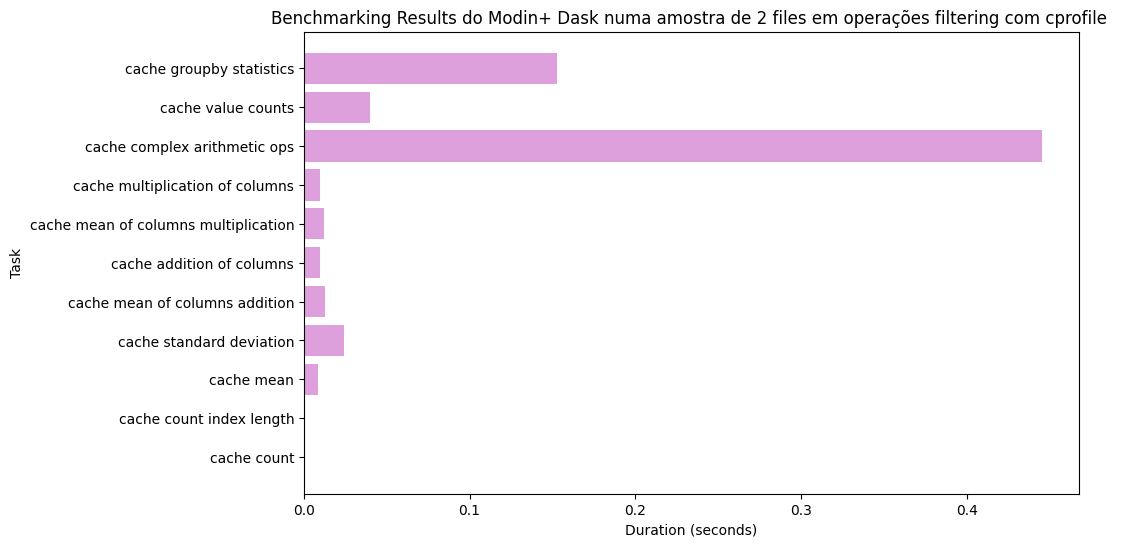

In [102]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.barh(results_modin_filtered2['task'], results_modin_filtered2['duration'], color='plum')
plt.xlabel('Duration (seconds)')
plt.ylabel('Task')
plt.title('Benchmarking Results do Modin+ Dask numa amostra de 2 files em operações filtering com cprofile ')
plt.show()

### Gráfico de Barras Horizontais em dados filtrados com cprofile: Amostra de 3 files

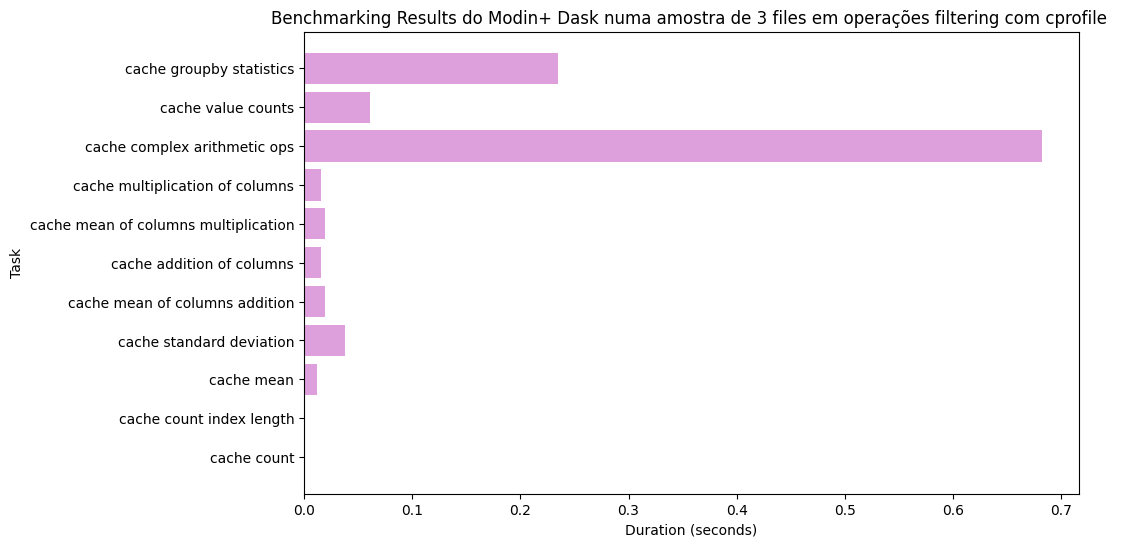

In [103]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.barh(results_modin_filtered3['task'], results_modin_filtered3['duration'], color='plum')
plt.xlabel('Duration (seconds)')
plt.ylabel('Task')
plt.title('Benchmarking Results do Modin+ Dask numa amostra de 3 files em operações filtering com cprofile ')
plt.show()

As tarefas que demoram mais tempo são `cache complex arithmetic ops`e `cache groupby statistic`, como se previa a amostra de 3 files demora mais tempo. Ambas as amostram apresentam tarefas mais rápidas em dados filtrados, do que em operações standard.

### Gráfico circular em dados filtrados com cprofile: Amostra de 2 files

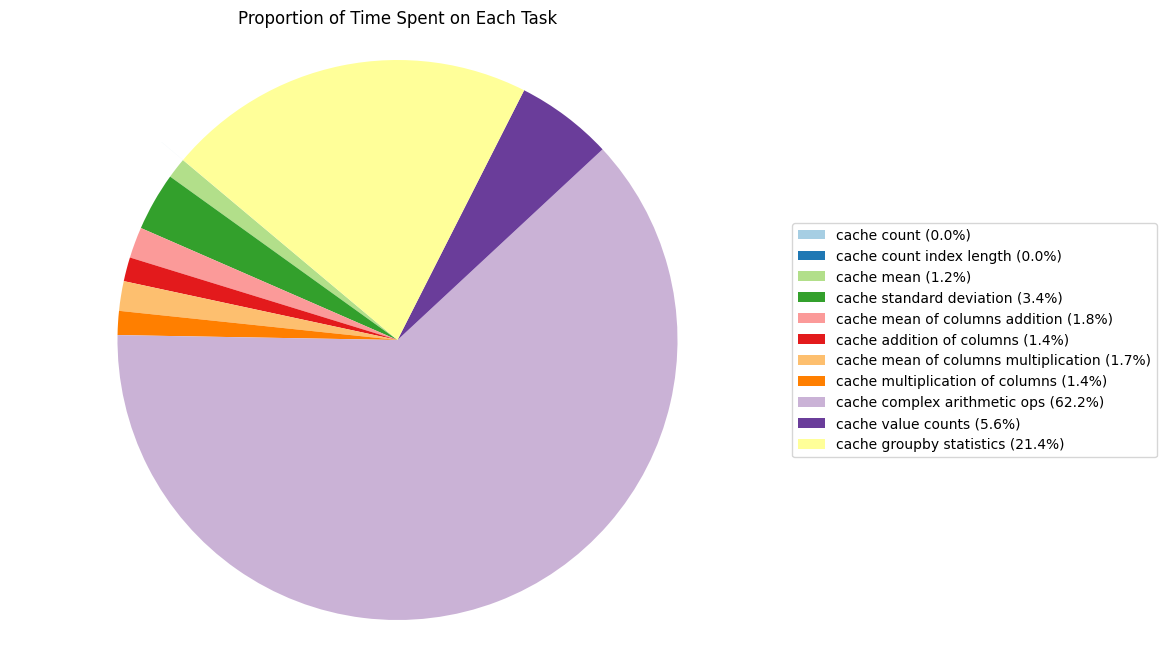

In [104]:
# Calcular percentagens
percentages = [f"{(d / sum(results_modin_filtered2['duration']) * 100):.1f}%" for d in results_modin_filtered2['duration']]
legend_labels = [f"{task} ({percentage})" for task, percentage in zip(results_modin_filtered2['task'], percentages)]

# Definir cores, com 'read file' como rosa
colors = ['plum' if task == 'read file' else color for task, color in zip(results_modin_filtered2['task'], plt.cm.Paired.colors)]

# Gráfico de Pizza sem rótulos nas fatias
explode = [0.1 if i == 0 else 0 for i in range(len(results_modin_filtered2['duration']))]

plt.figure(figsize=(10, 8))
plt.pie(results_modin_filtered2['duration'], startangle=140, colors=colors,
        explode=explode, pctdistance=0.85, labeldistance=1.1)

# Garantir que os rótulos não se sobreponham
plt.axis('equal')
plt.title('Proportion of Time Spent on Each Task')
plt.legend(legend_labels, loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

### Gráfico circular em dados filtrados com cprofile: Amostra de 3 files

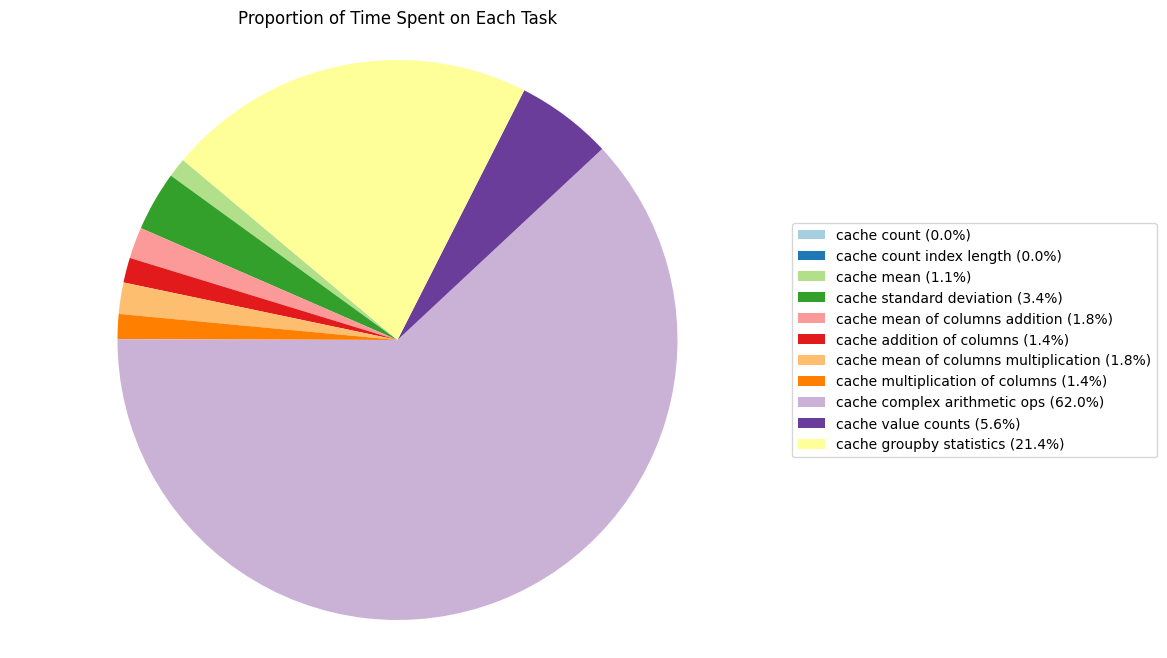

In [105]:
# Calcular percentagens
percentages = [f"{(d / sum(results_modin_filtered3['duration']) * 100):.1f}%" for d in results_modin_filtered3['duration']]
legend_labels = [f"{task} ({percentage})" for task, percentage in zip(results_modin_filtered3['task'], percentages)]

# Definir cores, com 'read file' como rosa
colors = ['plum' if task == 'read file' else color for task, color in zip(results_modin_filtered3['task'], plt.cm.Paired.colors)]

# Gráfico de Pizza sem rótulos nas fatias
explode = [0.1 if i == 0 else 0 for i in range(len(results_modin_filtered3['duration']))]

plt.figure(figsize=(10, 8))
plt.pie(results_modin_filtered3['duration'], startangle=140, colors=colors,
        explode=explode, pctdistance=0.85, labeldistance=1.1)

# Garantir que os rótulos não se sobreponham
plt.axis('equal')
plt.title('Proportion of Time Spent on Each Task')
plt.legend(legend_labels, loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

- As operações `cache complex arithmetic ops`e `cache groupby statistics`são as fatias que demora mais tempo, para a amostra 2 o primeiro demora 62.2% e para a amostra 3 demora 62.0%, o segundo demora 21.4% para a amostra 2 e 3.

### Gráfico de linha em dados filtrados com cprofile: Amostra de 2 files

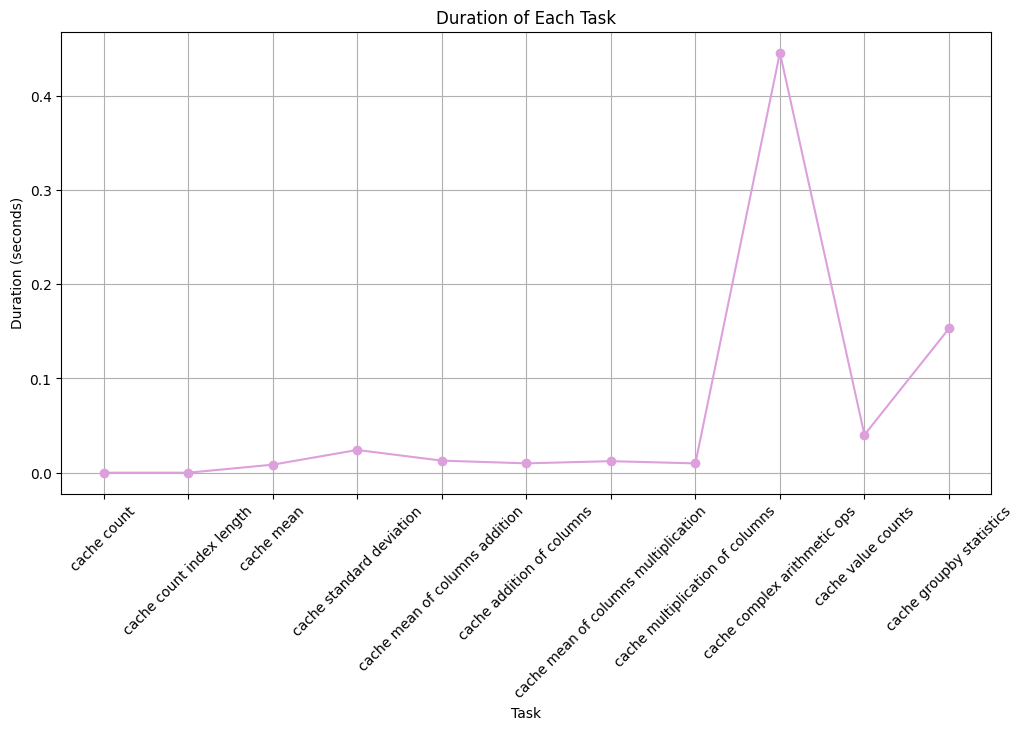

In [106]:
# Gráfico de Linha
plt.figure(figsize=(12, 6))
plt.plot(results_modin_filtered2['task'], results_modin_filtered2['duration'], marker='o', linestyle='-', color='plum')
plt.xlabel('Task')
plt.ylabel('Duration (seconds)')
plt.title('Duration of Each Task')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Gráfico de linha em dados filtrados com cprofile: Amostra de 3 files

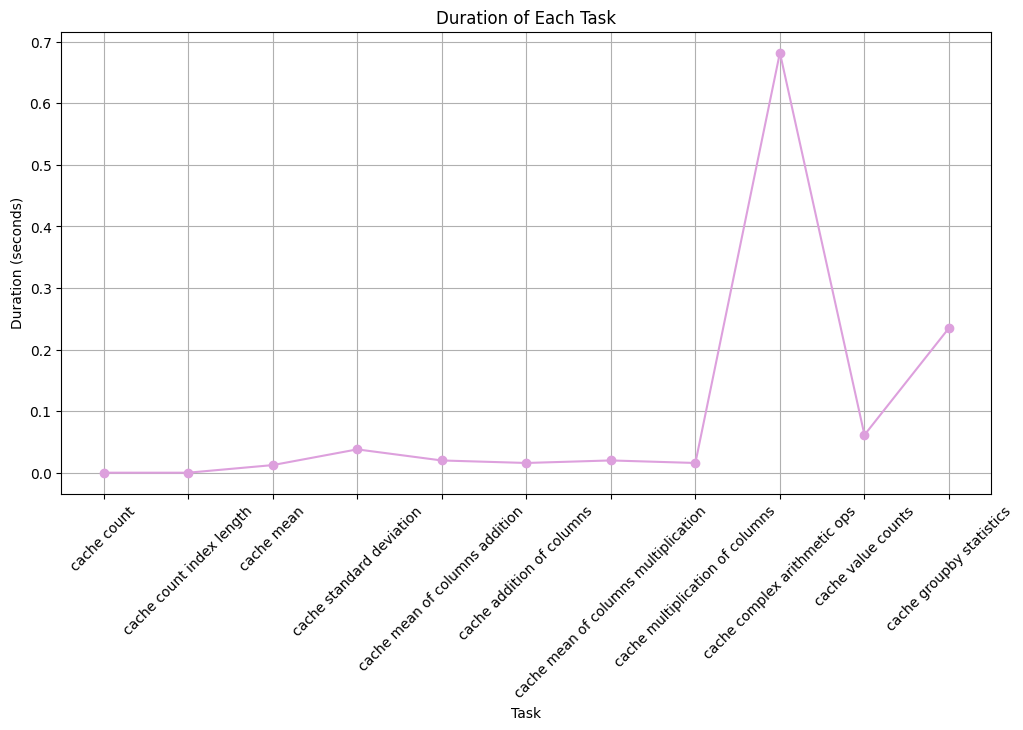

In [107]:
# Gráfico de Linha
plt.figure(figsize=(12, 6))
plt.plot(results_modin_filtered3['task'], results_modin_filtered3['duration'], marker='o', linestyle='-', color='plum')
plt.xlabel('Task')
plt.ylabel('Duration (seconds)')
plt.title('Duration of Each Task')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**Conclusões em dados filtering**
- Principais Consumo de Tempo: As operações `cache complex arithmetic ops`e `cache groupby statistics`são as que apresentam maior duração, indicando que são as principais áreas a serem otimizadas.

## Operações de cache

In [108]:
# Verificar se estamos lidando com um DataFrame Modin
if isinstance(modin_filtered[0], pd.DataFrame):
    # Depuração: imprimir algumas linhas do DataFrame
    print(modin_filtered[0].head())
    
    # Converter Modin para Pandas
    dask_df = modin_filtered[0]
    print("Conversão para Pandas realizada com sucesso.")
else:
    print("O DataFrame filtrado não é um DataFrame Modin.")
    raise TypeError("O objeto não é um DataFrame Modin")

# Converter Pandas para Dask
dask_df = dd.from_pandas(dask_df, npartitions=10)

# Persistir com Dask
dask_df = client.persist(dask_df)
modin_cache2 = dask_df

# Inicializar dicionários para armazenar resultados dos benchmarks
modin_benchmarks_cache2 = {'duration': [], 'task': []}

  vendor_name trip_pickup_datetime trip_dropoff_datetime  passenger_count  \
1         VTS  2009-01-04 03:31:00   2009-01-04 03:38:00                3   
2         VTS  2009-01-03 15:43:00   2009-01-03 15:57:00                5   
3         DDS  2009-01-01 20:52:58   2009-01-01 21:14:00                1   
6         DDS  2009-01-21 08:55:57   2009-01-21 09:05:42                1   
8         CMT  2009-01-05 16:29:02   2009-01-05 16:40:21                1   

   trip_distance  start_lon  start_lat  rate_code  store_and_forward  \
1           4.55 -73.982102  40.736290        NaN                NaN   
2          10.35 -74.002587  40.739748        NaN                NaN   
3           5.00 -73.974267  40.790955        NaN                NaN   
6           0.40 -73.984050  40.743544        NaN                NaN   
8           1.60 -73.969690  40.749244        NaN                NaN   

     end_lon    end_lat payment_type  fare_amt  surcharge  mta_tax  tip_amt  \
1 -73.955850  40.768030  

This may cause some slowdown.
Consider scattering data ahead of time and using futures.


In [109]:
# Verificar se estamos lidando com um DataFrame Modin
if isinstance(modin_filtered[1], pd.DataFrame):
    # Depuração: imprimir algumas linhas do DataFrame
    print(modin_filtered[1].head())
    
    #dask_df = modin_filtered.to_pandas()  # Converter Modin para Pandas
    dask_df = modin_filtered[1]
    print("Conversão para Pandas realizada com sucesso.")
else:
    print("O DataFrame filtrado não é um DataFrame Modin.")
    raise TypeError("O objeto não é um DataFrame Modin")

# Converter Pandas para Dask
dask_df = dd.from_pandas(dask_df, npartitions=10)

# Persistir com Dask
dask_df = client.persist(dask_df)
modin_cache3 = dask_df

# Inicializar dicionários para armazenar resultados dos benchmarks
modin_benchmarks_cache3 = {'duration': [], 'task': []}

  vendor_name trip_pickup_datetime trip_dropoff_datetime  passenger_count  \
1         VTS  2009-01-04 03:31:00   2009-01-04 03:38:00                3   
2         VTS  2009-01-03 15:43:00   2009-01-03 15:57:00                5   
3         DDS  2009-01-01 20:52:58   2009-01-01 21:14:00                1   
6         DDS  2009-01-21 08:55:57   2009-01-21 09:05:42                1   
8         CMT  2009-01-05 16:29:02   2009-01-05 16:40:21                1   

   trip_distance  start_lon  start_lat  rate_code  store_and_forward  \
1           4.55 -73.982102  40.736290        NaN                NaN   
2          10.35 -74.002587  40.739748        NaN                NaN   
3           5.00 -73.974267  40.790955        NaN                NaN   
6           0.40 -73.984050  40.743544        NaN                NaN   
8           1.60 -73.969690  40.749244        NaN                NaN   

     end_lon    end_lat payment_type  fare_amt  surcharge  mta_tax  tip_amt  \
1 -73.955850  40.768030  

This may cause some slowdown.
Consider scattering data ahead of time and using futures.


In [110]:
modin_cache = [modin_cache2,modin_cache3]

#### Benchmarks para operações de cache para ambas as amostras(de 2 files e de 3 files).

In [111]:
for i, df in enumerate(modin_cache):
    benchmark(count, df, benchmarks=globals()[f'modin_benchmarks_cache{i+2}'], name=f'cache count')
    benchmark(count_index_length, df, benchmarks=globals()[f'modin_benchmarks_cache{i+2}'], name=f'cache count index length')
    benchmark(mean, df, benchmarks=globals()[f'modin_benchmarks_cache{i+2}'], name=f'cache mean')
    benchmark(standard_deviation, df, benchmarks=globals()[f'modin_benchmarks_cache{i+2}'], name=f'cache standard deviation')
    benchmark(mean_of_sum, df, benchmarks=globals()[f'modin_benchmarks_cache{i+2}'], name=f'cache mean of columns addition')
    benchmark(sum_columns, df, benchmarks=globals()[f'modin_benchmarks_cache{i+2}'], name=f'cache addition of columns')
    benchmark(mean_of_product, df, benchmarks=globals()[f'modin_benchmarks_cache{i+2}'], name=f'cache mean of columns multiplication')
    benchmark(product_columns, df, benchmarks=globals()[f'modin_benchmarks_cache{i+2}'], name=f'cache multiplication of columns')
    #benchmark(mean_of_complicated_arithmetic_operation, df, benchmarks=globals()[f'modin_benchmarks_cache{i+2}'], name=f'cache mean of complex arithmetic ops')
    benchmark(complicated_arithmetic_operation, df, benchmarks=globals()[f'modin_benchmarks_cache{i+2}'], name=f'cache complex arithmetic ops')
    benchmark(value_counts, df, benchmarks=globals()[f'modin_benchmarks_cache{i+2}'], name=f'cache value counts')
    benchmark(groupby_statistics, df, benchmarks=globals()[f'modin_benchmarks_cache{i+2}'], name=f'cache groupby statistics')


cache count took: 0.2941420078277588 seconds
cache count index length took: 0.032958269119262695 seconds
cache mean took: 0.002823352813720703 seconds
cache standard deviation took: 0.0031311511993408203 seconds
cache mean of columns addition took: 0.0028564929962158203 seconds
cache addition of columns took: 0.0019512176513671875 seconds
cache mean of columns multiplication took: 0.0027136802673339844 seconds
cache multiplication of columns took: 0.0016345977783203125 seconds
cache complex arithmetic ops took: 0.012625694274902344 seconds
cache value counts took: 0.0009610652923583984 seconds
cache groupby statistics took: 0.015099287033081055 seconds
cache count took: 0.033975839614868164 seconds
cache count index length took: 0.02485370635986328 seconds
cache mean took: 0.002636432647705078 seconds
cache standard deviation took: 0.0031278133392333984 seconds
cache mean of columns addition took: 0.002910614013671875 seconds
cache addition of columns took: 0.0017659664154052734 second

**Os benchmarks foram realizados em duas diferentes configurações de DataFrames persistidos (modin_cache) utilizando várias operações. Abaixo está o desempenho medido em segundos para cada operação:**

**Operações no DataFrame Filtrado 1**
- cache count took: 0.2941420078277588 seconds
- cache count index length took: 0.032958269119262695 seconds
- cache mean took: 0.002823352813720703 seconds
- cache standard deviation took: 0.0031311511993408203 seconds
- cache mean of columns addition took: 0.0028564929962158203 seconds
- cache addition of columns took: 0.0019512176513671875 seconds
- cache mean of columns multiplication took: 0.0027136802673339844 seconds
- cache multiplication of columns took: 0.0016345977783203125 seconds
- cache complex arithmetic ops took: 0.012625694274902344 seconds
- cache value counts took: 0.0009610652923583984 seconds
- cache groupby statistics took: 0.015099287033081055 seconds
- cache count took: 0.033975839614868164 seconds

**Operações no DataFrame Filtrado 2**
- cache count index length took: 0.02485370635986328 seconds
- cache mean took: 0.002636432647705078 seconds
- cache standard deviation took: 0.0031278133392333984 seconds
- cache mean of columns addition took: 0.002910614013671875 seconds
- cache addition of columns took: 0.0017659664154052734 seconds
- cache mean of columns multiplication took: 0.0028100013732910156 seconds
- cache multiplication of columns took: 0.0016775131225585938 seconds
- cache complex arithmetic ops took: 0.012979984283447266 seconds
- cache value counts took: 0.0010368824005126953 seconds
- cache groupby statistics took: 0.014823198318481445 seconds

### Salvar Resultados

In [112]:
# Obter os resultados e remover duplicatas
modin_res_cache2 = get_results(modin_benchmarks_cache2).drop_duplicates(subset='task').set_index('task')
modin_res_cache3 = get_results(modin_benchmarks_cache3).drop_duplicates(subset='task').set_index('task')

# Print dos dataframes
print(modin_res_cache2)
print(modin_res_cache3)

# Definir o nome do arquivo ou diretório
filename_cache2 = 'Resultados/modin_cache2'
filename_cache3 = 'Resultados/modin_cache3'

# Salvar o DataFrame em formato Parquet
modin_res_cache2.to_parquet(filename_cache2)
modin_res_cache3.to_parquet(filename_cache3)

print(f'O arquivo Parquet foi salvo em {filename_cache2}.')
print(f'O arquivo Parquet foi salvo em {filename_cache3}.')

                                      duration
task                                          
cache count                           0.294142
cache count index length              0.032958
cache mean                            0.002823
cache standard deviation              0.003131
cache mean of columns addition        0.002856
cache addition of columns             0.001951
cache mean of columns multiplication  0.002714
cache multiplication of columns       0.001635
cache complex arithmetic ops          0.012626
cache value counts                    0.000961
cache groupby statistics              0.015099
                                      duration
task                                          
cache count                           0.033976
cache count index length              0.024854
cache mean                            0.002636
cache standard deviation              0.003128
cache mean of columns addition        0.002911
cache addition of columns             0.001766
cache mean of

## Com CProfile em dados persistidos para amostra de 2 files

In [113]:
modin_benchmarks2_cache_cprofile = {'duration': [], 'task': []}
modin_benchmarks3_cache_cprofile = {'duration': [], 'task': []}

In [114]:
benchmark_with_cprofile(count, modin_cache[0], benchmarks=globals()[f'modin_benchmarks2_cache_cprofile'], name=f'cache count')
benchmark_with_cprofile(count_index_length, modin_cache[0], benchmarks=globals()[f'modin_benchmarks2_cache_cprofile'], name=f'cache count index length')
benchmark_with_cprofile(mean, modin_cache[0], benchmarks=globals()[f'modin_benchmarks2_cache_cprofile'], name=f'cache mean')
benchmark_with_cprofile(standard_deviation, modin_cache[0], benchmarks=globals()[f'modin_benchmarks2_cache_cprofile'], name=f'cache standard deviation')
benchmark_with_cprofile(mean_of_sum, modin_cache[0], benchmarks=globals()[f'modin_benchmarks2_cache_cprofile'], name=f'cache mean of columns addition')
benchmark_with_cprofile(sum_columns, modin_cache[0], benchmarks=globals()[f'modin_benchmarks2_cache_cprofile'], name=f'cache addition of columns')
benchmark_with_cprofile(mean_of_product, modin_cache[0], benchmarks=globals()[f'modin_benchmarks2_cache_cprofile'], name=f'cache mean of columns multiplication')
benchmark_with_cprofile(product_columns, modin_cache[0], benchmarks=globals()[f'modin_benchmarks2_cache_cprofile'], name=f'cache multiplication of columns')
#benchmark_with_cprofile(mean_of_complicated_arithmetic_operation, modin_cache[0], benchmarks=globals()[f'modin_benchmarks2_cache_cprofile'], name=f'cache mean of complex arithmetic ops')
benchmark_with_cprofile(complicated_arithmetic_operation, modin_cache[0], benchmarks=globals()[f'modin_benchmarks2_cache_cprofile'], name=f'cache complex arithmetic ops')
benchmark_with_cprofile(value_counts, modin_cache[0], benchmarks=globals()[f'modin_benchmarks2_cache_cprofile'], name=f'cache value counts')
benchmark_with_cprofile(groupby_statistics, modin_cache[0], benchmarks=globals()[f'modin_benchmarks2_cache_cprofile'], name=f'cache groupby statistics')

cache count took: 0.027122974395751953 seconds
         2527 function calls (2352 primitive calls) in 0.029 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.027    0.027 1601532002.py:9(count)
     80/3    0.000    0.000    0.027    0.009 {built-in method builtins.len}
        1    0.000    0.000    0.027    0.027 core.py:4774(__len__)
        1    0.000    0.000    0.026    0.026 core.py:845(__len__)
        1    0.000    0.000    0.024    0.024 base.py:290(compute)
        1    0.000    0.000    0.024    0.024 base.py:538(compute)
        1    0.000    0.000    0.023    0.023 client.py:3133(get)
        1    0.000    0.000    0.023    0.023 client.py:2308(gather)
        1    0.000    0.000    0.023    0.023 utils.py:339(sync)
        1    0.000    0.000    0.023    0.023 utils.py:368(sync)
        1    0.000    0.000    0.023    0.023 utils.py:401(wait)
        1    0.000    0.000    0.0

0.025274991989135742

In [115]:
results_modin_cache2 = pd.DataFrame.from_dict(modin_benchmarks2_cache_cprofile)

## Com CProfile em dados persistidos para amostra de 3 files

In [116]:
benchmark_with_cprofile(count, modin_cache[1], benchmarks=globals()[f'modin_benchmarks3_cache_cprofile'], name=f'cache count')
benchmark_with_cprofile(count_index_length, modin_cache[1], benchmarks=globals()[f'modin_benchmarks3_cache_cprofile'], name=f'cache count index length')
benchmark_with_cprofile(mean, modin_cache[1], benchmarks=globals()[f'modin_benchmarks3_cache_cprofile'], name=f'cache mean')
benchmark_with_cprofile(standard_deviation, modin_cache[1], benchmarks=globals()[f'modin_benchmarks3_cache_cprofile'], name=f'cache standard deviation')
benchmark_with_cprofile(mean_of_sum, modin_cache[1], benchmarks=globals()[f'modin_benchmarks3_cache_cprofile'], name=f'cache mean of columns addition')
benchmark_with_cprofile(sum_columns, modin_cache[1], benchmarks=globals()[f'modin_benchmarks3_cache_cprofile'], name=f'cache addition of columns')
benchmark_with_cprofile(mean_of_product, modin_cache[1], benchmarks=globals()[f'modin_benchmarks3_cache_cprofile'], name=f'cache mean of columns multiplication')
benchmark_with_cprofile(product_columns, modin_cache[1], benchmarks=globals()[f'modin_benchmarks2_cache_cprofile'], name=f'cache multiplication of columns')
#benchmark_with_cprofile(mean_of_complicated_arithmetic_operation, modin_cache[1], benchmarks=globals()[f'modin_benchmarks3_cache_cprofile'], name=f'cache mean of complex arithmetic ops')
benchmark_with_cprofile(complicated_arithmetic_operation, modin_cache[1], benchmarks=globals()[f'modin_benchmarks3_cache_cprofile'], name=f'cache complex arithmetic ops')
benchmark_with_cprofile(value_counts, modin_cache[1], benchmarks=globals()[f'modin_benchmarks3_cache_cprofile'], name=f'cache value counts')
benchmark_with_cprofile(groupby_statistics, modin_cache[1], benchmarks=globals()[f'modin_benchmarks3_cache_cprofile'], name=f'cache groupby statistics')

cache count took: 0.02450108528137207 seconds
         2564 function calls (2389 primitive calls) in 0.025 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.024    0.024 1601532002.py:9(count)
     80/3    0.000    0.000    0.024    0.008 {built-in method builtins.len}
        1    0.000    0.000    0.024    0.024 core.py:4774(__len__)
        1    0.000    0.000    0.024    0.024 core.py:845(__len__)
        1    0.000    0.000    0.022    0.022 base.py:290(compute)
        1    0.000    0.000    0.022    0.022 base.py:538(compute)
        1    0.000    0.000    0.021    0.021 client.py:3133(get)
        1    0.000    0.000    0.021    0.021 client.py:2308(gather)
        1    0.000    0.000    0.021    0.021 utils.py:339(sync)
        1    0.000    0.000    0.021    0.021 utils.py:368(sync)
        1    0.000    0.000    0.021    0.021 utils.py:401(wait)
        1    0.000    0.000    0.02

0.022170543670654297

In [117]:
results_modin_cache3 = pd.DataFrame.from_dict(modin_benchmarks3_cache_cprofile)

### Gráfico de barras horizontais em dados persistidos com cprofile: Amostra de 2 files

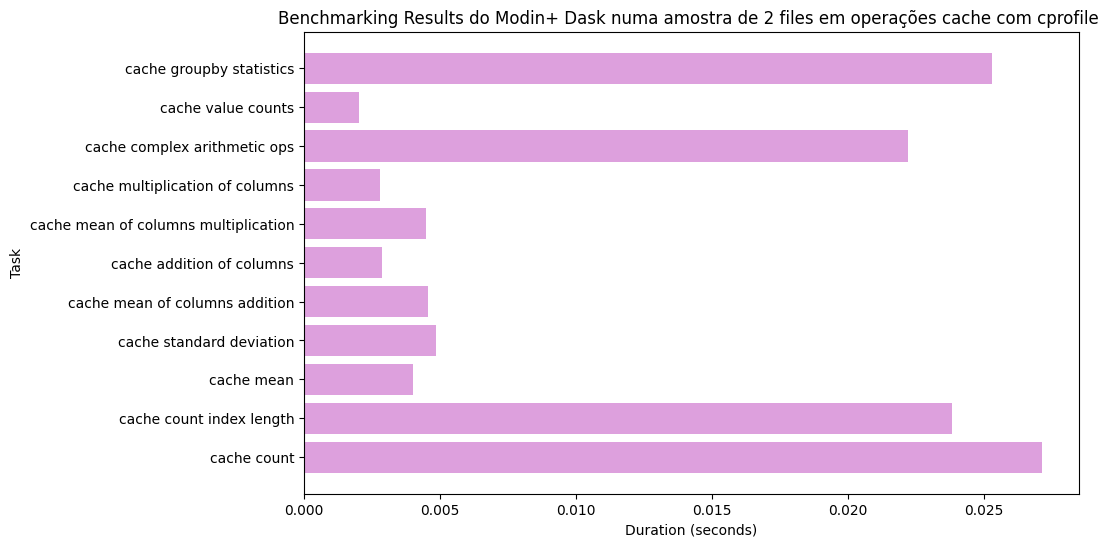

In [118]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.barh(results_modin_cache2['task'], results_modin_cache2['duration'], color='plum')
plt.xlabel('Duration (seconds)')
plt.ylabel('Task')
plt.title('Benchmarking Results do Modin+ Dask numa amostra de 2 files em operações cache com cprofile ')
plt.show()

### Gráfico de barras horizontais em dados persistidos com cprofile: Amostra de 3 files

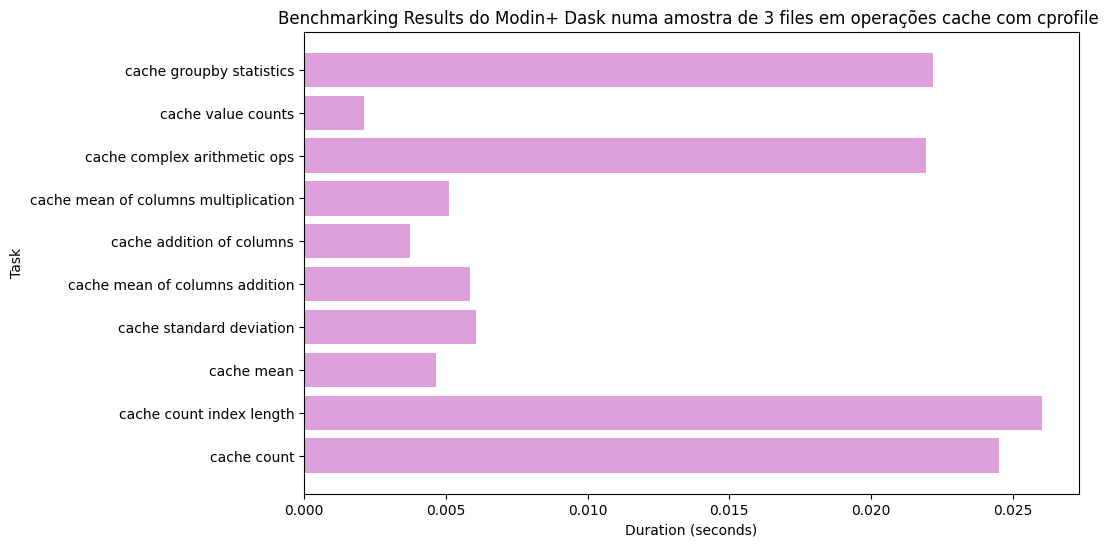

In [119]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.barh(results_modin_cache3['task'], results_modin_cache3['duration'], color='plum')
plt.xlabel('Duration (seconds)')
plt.ylabel('Task')
plt.title('Benchmarking Results do Modin+ Dask numa amostra de 3 files em operações cache com cprofile ')
plt.show()

### Gráfico ciecular em dados persistidos com cprofile: Amostra de 2 files

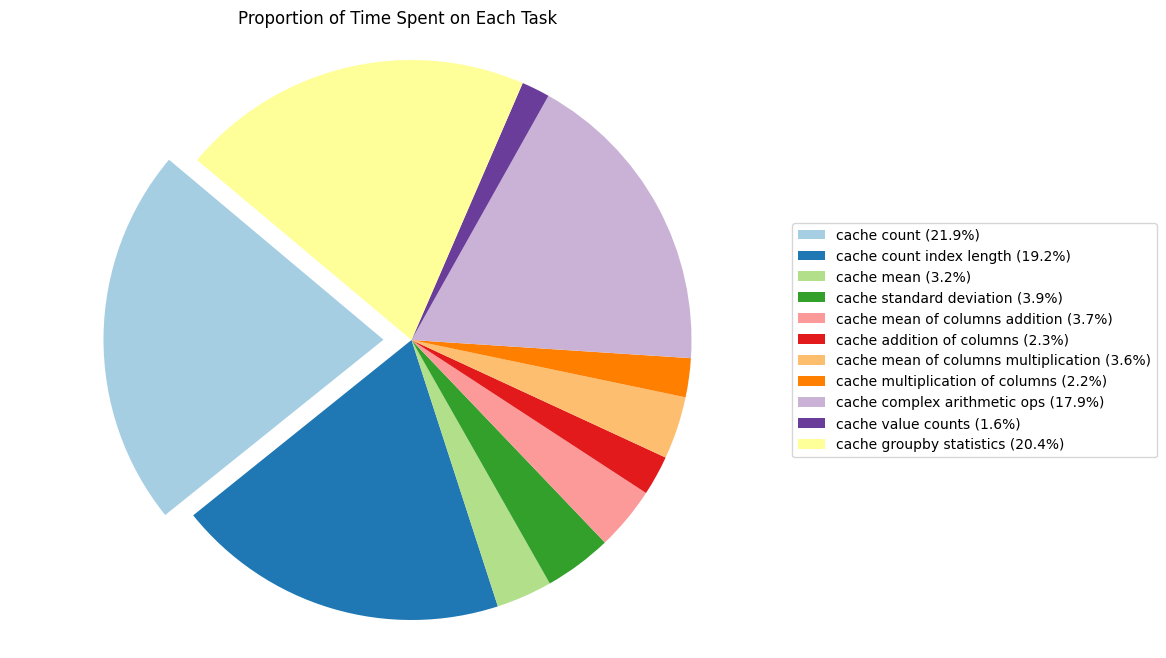

In [120]:
# Calcular percentagens
percentages = [f"{(d / sum(results_modin_cache2['duration']) * 100):.1f}%" for d in results_modin_cache2['duration']]
legend_labels = [f"{task} ({percentage})" for task, percentage in zip(results_modin_cache2['task'], percentages)]

# Definir cores, com 'read file' como rosa
colors = ['plum' if task == 'read file' else color for task, color in zip(results_modin_cache2['task'], plt.cm.Paired.colors)]

# Gráfico de Pizza sem rótulos nas fatias
explode = [0.1 if i == 0 else 0 for i in range(len(results_modin_cache2['duration']))]

plt.figure(figsize=(10, 8))
plt.pie(results_modin_cache2['duration'], startangle=140, colors=colors,
        explode=explode, pctdistance=0.85, labeldistance=1.1)

# Garantir que os rótulos não se sobreponham
plt.axis('equal')
plt.title('Proportion of Time Spent on Each Task')
plt.legend(legend_labels, loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

### Gráfico circular em dados persistidos com cprofile: Amostra de 3 files

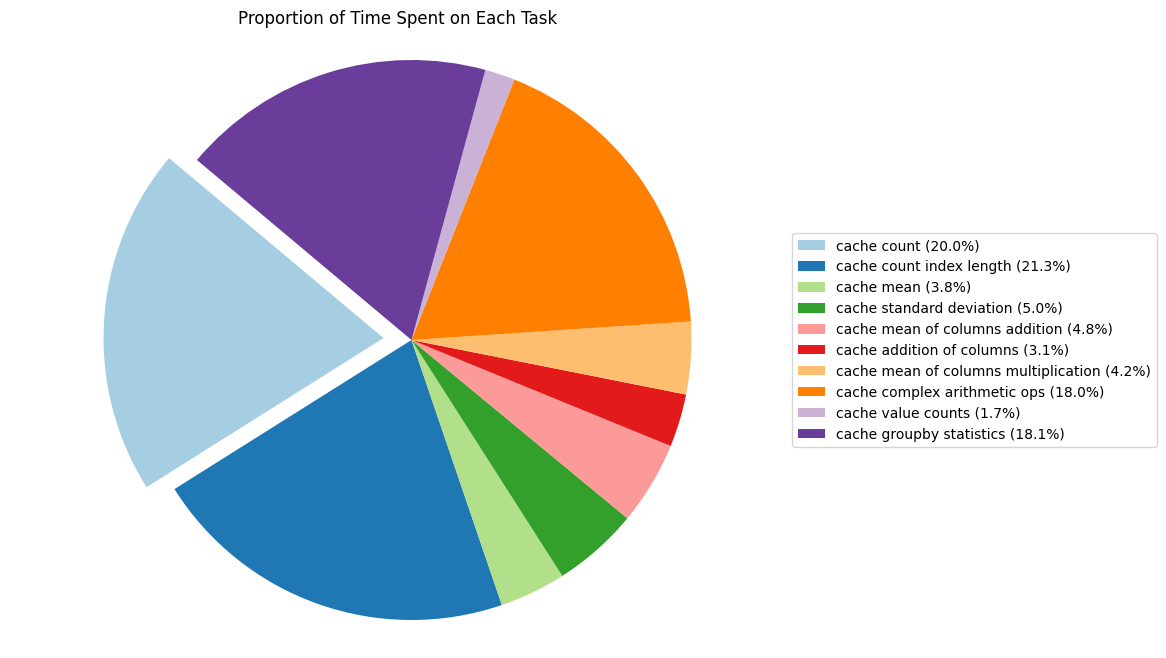

In [121]:
# Calcular percentagens
percentages = [f"{(d / sum(results_modin_cache3['duration']) * 100):.1f}%" for d in results_modin_cache3['duration']]
legend_labels = [f"{task} ({percentage})" for task, percentage in zip(results_modin_cache3['task'], percentages)]

# Definir cores, com 'read file' como rosa
colors = ['plum' if task == 'read file' else color for task, color in zip(results_modin_cache3['task'], plt.cm.Paired.colors)]

# Gráfico de Pizza sem rótulos nas fatias
explode = [0.1 if i == 0 else 0 for i in range(len(results_modin_cache3['duration']))]

plt.figure(figsize=(10, 8))
plt.pie(results_modin_cache3['duration'], startangle=140, colors=colors,
        explode=explode, pctdistance=0.85, labeldistance=1.1)

# Garantir que os rótulos não se sobreponham
plt.axis('equal')
plt.title('Proportion of Time Spent on Each Task')
plt.legend(legend_labels, loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

### Gráfico de linha em dados persistidos com cprofile: Amostra de 2 files

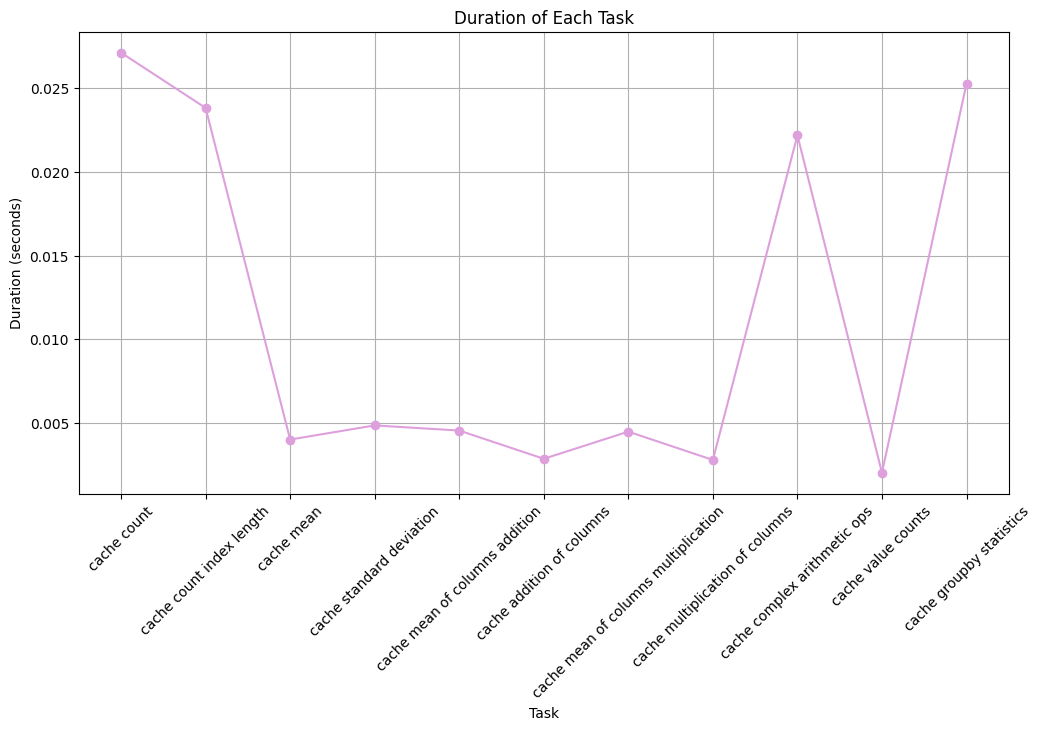

In [122]:
# Gráfico de Linha
plt.figure(figsize=(12, 6))
plt.plot(results_modin_cache2['task'], results_modin_cache2['duration'], marker='o', linestyle='-', color='plum')
plt.xlabel('Task')
plt.ylabel('Duration (seconds)')
plt.title('Duration of Each Task')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Gráfico de linha em dados persistidos com cprofile: Amostra de 3 files

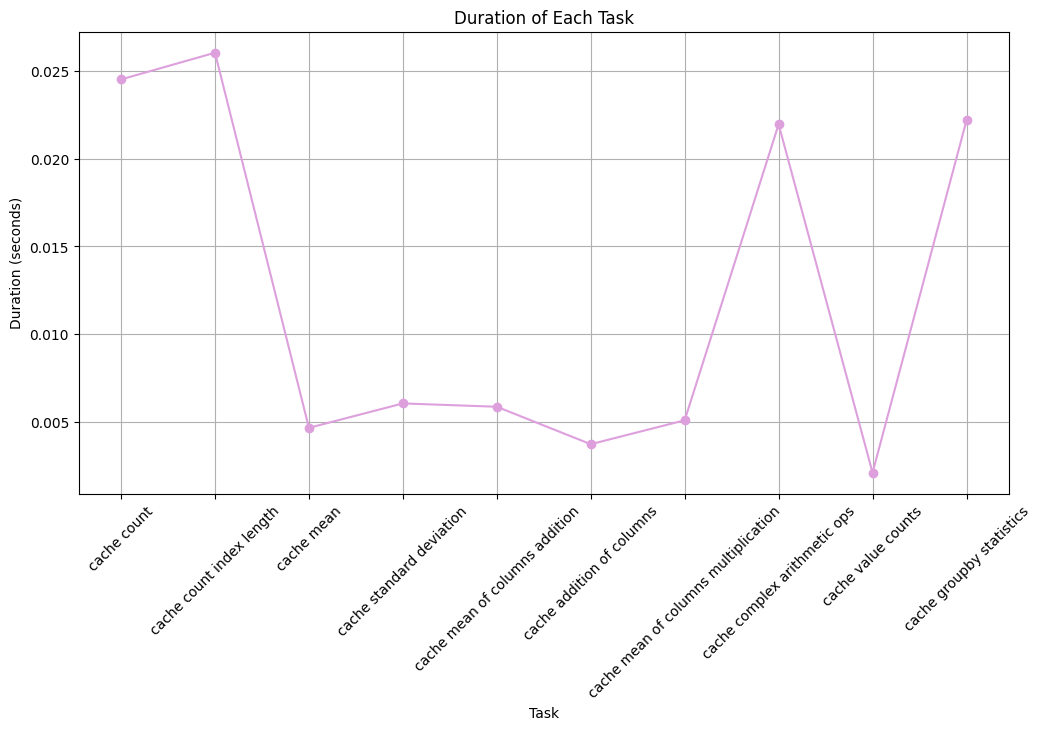

In [123]:
# Gráfico de Linha
plt.figure(figsize=(12, 6))
plt.plot(results_modin_cache3['task'], results_modin_cache3['duration'], marker='o', linestyle='-', color='plum')
plt.xlabel('Task')
plt.ylabel('Duration (seconds)')
plt.title('Duration of Each Task')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**Análise dos resultados/Gráficos**

##### Visualizações
Para facilitar a interpretação dos resultados, foram gerados gráficos que ilustram o desempenho das operações:

1. **Gráficos de Barras**: Demonstram a duração de cada tarefa em ambas as amostras.
2. **Gráficos de Pizza**: Mostram a proporção do tempo gasto em cada tarefa.
3. **Gráficos de Linhas**: Representam a duração de cada tarefa, facilitando a comparação visual entre as operações.

##### Observações
- As operações de contagem (`cache count` e `cache count index length`) foram as mais rápidas, refletindo a eficiência destas tarefas em Modin+ Dask.
- As operações aritméticas complexas (`cache complex arithmetic ops`) e as estatísticas de agrupamento (`cache groupby statistics`) apresentaram maior tempo de execução, destacando a complexidade envolvida nestas operações.
- Há uma variação considerável no tempo de execução entre as duas amostras, o que sugere a necessidade de uma análise mais aprofundada para entender os fatores que influenciam a performance.

## Joblib

Todo o procedimento aplicado à biblioteca Modin+Dask será  usado novamente, para ambas as amostras ( de 2 e 3 files), mas agora usando o Joblib.

In [124]:
import pandas as pd
import numpy as np
import time
from joblib import dump, load

In [125]:
# Read the downloaded Parquet files
parquet_files2 = ['Ficheiros/taxi_csv/yellow_tripdata_2009-01.parquet', 
                 'Ficheiros/taxi_csv/yellow_tripdata_2009-02.parquet']

parquet_files3 = [
    'Ficheiros/taxi_csv/yellow_tripdata_2009-01.parquet', 
    'Ficheiros/taxi_csv/yellow_tripdata_2009-02.parquet',
    'Ficheiros/taxi_csv/yellow_tripdata_2009-03.parquet'
]

joblib_data2 = pd.read_parquet(parquet_files2)
joblib_data3 = pd.read_parquet(parquet_files3)

# Renomear colunas para minúsculas
joblib_data2 = joblib_data2.rename(columns=str.lower)
joblib_data3 = joblib_data3.rename(columns=str.lower)

# Exibir colunas do DataFrame
print(joblib_data2.columns)
print(joblib_data3.columns)

Index(['vendor_name', 'trip_pickup_datetime', 'trip_dropoff_datetime',
       'passenger_count', 'trip_distance', 'start_lon', 'start_lat',
       'rate_code', 'store_and_forward', 'end_lon', 'end_lat', 'payment_type',
       'fare_amt', 'surcharge', 'mta_tax', 'tip_amt', 'tolls_amt',
       'total_amt'],
      dtype='object')
Index(['vendor_name', 'trip_pickup_datetime', 'trip_dropoff_datetime',
       'passenger_count', 'trip_distance', 'start_lon', 'start_lat',
       'rate_code', 'store_and_forward', 'end_lon', 'end_lat', 'payment_type',
       'fare_amt', 'surcharge', 'mta_tax', 'tip_amt', 'tolls_amt',
       'total_amt'],
      dtype='object')


Denote-se a execução das benchmarks incluídas numa função, algo que foi implementado diferente em comparação à abordagem utilizado no  Modin+Dask.

In [126]:
def get_results(benchmarks):
    """Retorna um DataFrame pandas contendo os resultados dos benchmarks"""
    return pd.DataFrame.from_dict(benchmarks)

# Funções de operações
def read_file_parquet(df=None):
    return pd.read_parquet(parquet_file)

def count(df):
    return len(df)

def count_index_length(df):
    return len(df.index)

def mean(df):
    return df['fare_amt'].mean()

def standard_deviation(df):
    return df['fare_amt'].std()

def mean_of_sum(df):
    return (df['fare_amt'] + df['tip_amt']).mean()

def sum_columns(df):
    return (df['fare_amt'] + df['tip_amt']).sum()

def mean_of_product(df):
    return (df['fare_amt'] * df['tip_amt']).mean()

def product_columns(df):
    return (df['fare_amt'] * df['tip_amt']).sum()

def value_counts(df):
    return df['fare_amt'].value_counts()

def complicated_arithmetic_operation(df):
    theta_1 = df['start_lon']
    phi_1 = df['start_lat']
    theta_2 = df['end_lon']
    phi_2 = df['end_lat']
    temp = (np.sin((theta_2 - theta_1) / 2 * np.pi / 180) ** 2
           + np.cos(theta_1 * np.pi / 180) * np.cos(theta_2 * np.pi / 180)
           * np.sin((phi_2 - phi_1) / 2 * np.pi / 180) ** 2)
    ret = 2 * np.arctan2(np.sqrt(temp), np.sqrt(1 - temp))
    return ret.mean()

def groupby_statistics(df):
    return df.groupby(by='passenger_count').agg({
        'fare_amt': ['mean', 'std'], 
        'tip_amt': ['mean', 'std']
    })

def join_count(df, other):
    return len(df.merge(other, left_index=True, right_index=True))

def join_data(df, other):
    return df.merge(other, left_index=True, right_index=True)

# Funções de benchmark
def benchmark(f, df, benchmarks, name, **kwargs):
    """Mede a duração da execução de uma função específica"""
    start_time = time.time()
    ret = f(df, **kwargs)
    duration = time.time() - start_time
    benchmarks['duration'].append(duration)
    benchmarks['task'].append(name)
    print(f"{name} took: {duration} seconds")
    return duration

def execute_benchmarks(data, benchmarks):
    benchmark(count, data, benchmarks, 'count')
    benchmark(count_index_length, data, benchmarks, 'count_index_length')
    benchmark(mean, data, benchmarks, 'mean')
    benchmark(standard_deviation, data, benchmarks, 'standard_deviation')
    benchmark(mean_of_sum, data, benchmarks, 'mean_of_sum')
    benchmark(sum_columns, data, benchmarks, 'sum_columns')
    benchmark(mean_of_product, data, benchmarks, 'mean_of_product')
    benchmark(product_columns, data, benchmarks, 'product_columns')
    benchmark(value_counts, data, benchmarks, 'value_counts')
    benchmark(complicated_arithmetic_operation, data, benchmarks, 'complicated_arithmetic_operation')
    benchmark(groupby_statistics, data, benchmarks, 'groupby_statistics')
    other_data = data.copy()  # Simulando outra tabela para a operação de join
    benchmark(join_count, data, benchmarks, 'join_count', other=other_data)
    benchmark(join_data, data, benchmarks, 'join_data', other=other_data)


Inicializou-se dicionários para armazenar resultados dos benchmarks para a amostra de 2 files, para cada uma das 3 operações:
- `joblib_benchmarks2`: standard
- `joblib_benchmarks_filtered2`: filtering
- `joblib_benchmarks_cache2`: cache

Utilizou-se novamente as funções `dump` e `load` para, respetivamente, persistir dados filtrados usando Joblib(`filtered_data.pkl`) e carregar os dados persistidos.

In [127]:
#Inicializar dicionários para armazenar resultados dos benchmarks
joblib_benchmarks2 = {'duration': [], 'task': []}


# Executar benchmarks nas operações com dados completos
execute_benchmarks(joblib_data2, joblib_benchmarks2)

# Filtrar dados
expr_filter2 = (joblib_data2['tip_amt'] >= 1) & (joblib_data2['tip_amt'] <= 5)
filtered_data2 = joblib_data2[expr_filter2]

# Inicializar dicionários para armazenar resultados dos benchmarks com dados filtrados
joblib_benchmarks_filtered2 = {'duration': [], 'task': []}

# Executar benchmarks nas operações com dados filtrados
execute_benchmarks(filtered_data2, joblib_benchmarks_filtered2)

# Inicializar dicionários para armazenar resultados dos benchmarks com dados persistidos (cache)
joblib_benchmarks_cache2 = {'duration': [], 'task': []}

# Persistir dados filtrados usando Joblib
dump(filtered_data2, 'filtered_data.pkl')

# Carregar dados persistidos
cached_data2 = load('filtered_data.pkl')

# Executar benchmarks nas operações com dados carregados do cache
execute_benchmarks(cached_data2, joblib_benchmarks_cache2)


count took: 1.6450881958007812e-05 seconds
count_index_length took: 3.0994415283203125e-06 seconds
mean took: 0.04019665718078613 seconds
standard_deviation took: 0.13691401481628418 seconds
mean_of_sum took: 0.07332301139831543 seconds
sum_columns took: 0.05859661102294922 seconds
mean_of_product took: 0.07952260971069336 seconds
product_columns took: 0.06663227081298828 seconds
value_counts took: 0.2154402732849121 seconds
complicated_arithmetic_operation took: 2.418334722518921 seconds
groupby_statistics took: 0.7825438976287842 seconds
join_count took: 4.371853828430176 seconds
join_data took: 3.2961719036102295 seconds
count took: 6.198883056640625e-06 seconds
count_index_length took: 2.6226043701171875e-06 seconds
mean took: 0.008326292037963867 seconds
standard_deviation took: 0.023907184600830078 seconds
mean_of_sum took: 0.012807130813598633 seconds
sum_columns took: 0.009531259536743164 seconds
mean_of_product took: 0.012796878814697266 seconds
product_columns took: 0.0094990

Inicializou-se dicionários para armazenar resultados dos benchmarks para a amostra de 3 files, para cada uma das 3 operações:
- `joblib_benchmarks3`: standard
- `joblib_benchmarks_filtered3`: filtering
- `joblib_benchmarks_cache3`: cache

Utilizou-se novamente as funções `dump` e `load` para, respetivamente, persistir dados filtrados usando Joblib(`filtered_data.pkl`) e carregar os dados persistidos.

In [128]:
#Inicializar dicionários para armazenar resultados dos benchmarks
joblib_benchmarks3 = {'duration': [], 'task': []}


# Executar benchmarks nas operações com dados completos
execute_benchmarks(joblib_data3, joblib_benchmarks3)

# Filtrar dados
expr_filter3 = (joblib_data3['tip_amt'] >= 1) & (joblib_data3['tip_amt'] <= 5)
filtered_data3 = joblib_data3[expr_filter3]

# Inicializar dicionários para armazenar resultados dos benchmarks com dados filtrados
joblib_benchmarks_filtered3 = {'duration': [], 'task': []}

# Executar benchmarks nas operações com dados filtrados
execute_benchmarks(filtered_data3, joblib_benchmarks_filtered3)

# Inicializar dicionários para armazenar resultados dos benchmarks com dados persistidos (cache)
joblib_benchmarks_cache3 = {'duration': [], 'task': []}

# Persistir dados filtrados usando Joblib
dump(filtered_data3, 'filtered_data.pkl')

# Carregar dados persistidos
cached_data3 = load('filtered_data.pkl')

# Executar benchmarks nas operações com dados carregados do cache
execute_benchmarks(cached_data3, joblib_benchmarks_cache3)


count took: 1.52587890625e-05 seconds
count_index_length took: 2.384185791015625e-06 seconds
mean took: 0.06753206253051758 seconds
standard_deviation took: 0.22824835777282715 seconds
mean_of_sum took: 0.12110686302185059 seconds
sum_columns took: 0.10351991653442383 seconds
mean_of_product took: 0.12674427032470703 seconds
product_columns took: 0.1049947738647461 seconds
value_counts took: 0.3158912658691406 seconds
complicated_arithmetic_operation took: 3.676028251647949 seconds
groupby_statistics took: 1.203007459640503 seconds
join_count took: 6.7364208698272705 seconds
join_data took: 5.26050329208374 seconds
count took: 6.4373016357421875e-06 seconds
count_index_length took: 2.86102294921875e-06 seconds
mean took: 0.012822866439819336 seconds
standard_deviation took: 0.04501032829284668 seconds
mean_of_sum took: 0.024678945541381836 seconds
sum_columns took: 0.020460128784179688 seconds
mean_of_product took: 0.024279356002807617 seconds
product_columns took: 0.021271705627441406

### Salvar Resultados

In [129]:
# Obter os resultados e remover duplicatas
joblib_res_temp2 = get_results(joblib_benchmarks2).drop_duplicates(subset='task').set_index('task')
joblib_res_temp3 = get_results(joblib_benchmarks3).drop_duplicates(subset='task').set_index('task')

# Print dos dataframes
print(joblib_res_temp2)
print(joblib_res_temp3)

# Definir o nome do arquivo ou diretório
filename2 = 'Resultados/joblib_standard2'
filename3 = 'Resultados/joblib_standard3'

# Salvar o DataFrame em formato Parquet
joblib_res_temp2.to_parquet(filename2)
joblib_res_temp3.to_parquet(filename3)

print(f'O arquivo Parquet foi salvo em {filename2}.')
print(f'O arquivo Parquet foi salvo em {filename3}.')


                                  duration
task                                      
count                             0.000016
count_index_length                0.000003
mean                              0.040197
standard_deviation                0.136914
mean_of_sum                       0.073323
sum_columns                       0.058597
mean_of_product                   0.079523
product_columns                   0.066632
value_counts                      0.215440
complicated_arithmetic_operation  2.418335
groupby_statistics                0.782544
join_count                        4.371854
join_data                         3.296172
                                  duration
task                                      
count                             0.000015
count_index_length                0.000002
mean                              0.067532
standard_deviation                0.228248
mean_of_sum                       0.121107
sum_columns                       0.103520
mean_of_pro

In [130]:
# Obter os resultados e remover duplicadas
joblib_res_filter2 = get_results(joblib_benchmarks_filtered2).drop_duplicates(subset='task').set_index('task')
joblib_res_filter3 = get_results(joblib_benchmarks_filtered3).drop_duplicates(subset='task').set_index('task')

# Print dos dataframes
print(joblib_res_filter2)
print(joblib_res_filter3)

# Definir o nome do arquivo ou diretório
filename_filter2 = 'Resultados/joblib_filtered2'
filename_filter3 = 'Resultados/joblib_filtered3'

# Salvar o DataFrame em formato Parquet
joblib_res_filter2.to_parquet(filename_filter2)
joblib_res_filter3.to_parquet(filename_filter3)

print(f'O arquivo Parquet foi salvo em {filename_filter2}.')
print(f'O arquivo Parquet foi salvo em {filename_filter3}.')

                                  duration
task                                      
count                             0.000006
count_index_length                0.000003
mean                              0.008326
standard_deviation                0.023907
mean_of_sum                       0.012807
sum_columns                       0.009531
mean_of_product                   0.012797
product_columns                   0.009499
value_counts                      0.042371
complicated_arithmetic_operation  0.444734
groupby_statistics                0.152076
join_count                        1.346140
join_data                         0.682711
                                  duration
task                                      
count                             0.000006
count_index_length                0.000003
mean                              0.012823
standard_deviation                0.045010
mean_of_sum                       0.024679
sum_columns                       0.020460
mean_of_pro

In [131]:
# Obter os resultados e remover duplicadas
joblib_res_cache2 = get_results(joblib_benchmarks_cache2).drop_duplicates(subset='task').set_index('task')
joblib_res_cache3 = get_results(joblib_benchmarks_cache3).drop_duplicates(subset='task').set_index('task')

# Print dos dataframes
print(joblib_res_cache2)
print(joblib_res_cache3)

# Definir o nome do arquivo ou diretório
filename_cache2 = 'Resultados/joblib_cache2'
filename_cache3 = 'Resultados/joblib_cache3'

# Salvar o DataFrame em formato Parquet
joblib_res_cache2.to_parquet(filename_cache2)
joblib_res_cache3.to_parquet(filename_cache3)

print(f'O arquivo Parquet foi salvo em {filename_cache2}.')
print(f'O arquivo Parquet foi salvo em {filename_cache3}.')

                                  duration
task                                      
count                             0.000007
count_index_length                0.000003
mean                              0.008056
standard_deviation                0.028883
mean_of_sum                       0.016186
sum_columns                       0.013173
mean_of_product                   0.015823
product_columns                   0.013348
value_counts                      0.042732
complicated_arithmetic_operation  0.484735
groupby_statistics                0.156008
join_count                        1.215816
join_data                         0.590078
                                  duration
task                                      
count                             0.000006
count_index_length                0.000003
mean                              0.012968
standard_deviation                0.045954
mean_of_sum                       0.024913
sum_columns                       0.020624
mean_of_pro

### Cprofile no Joblib em operações standard  para as amostras de 2 e 3 files

In [136]:
def execute_benchmarks_cprofile(data, benchmarks):
    benchmark_with_cprofile(count, data, benchmarks, 'count')
    benchmark_with_cprofile(count_index_length, data, benchmarks, 'count_index_length')
    benchmark_with_cprofile(mean, data, benchmarks, 'mean')
    benchmark_with_cprofile(standard_deviation, data, benchmarks, 'standard_deviation')
    benchmark_with_cprofile(mean_of_sum, data, benchmarks, 'mean_of_sum')
    benchmark_with_cprofile(sum_columns, data, benchmarks, 'sum_columns')
    benchmark_with_cprofile(mean_of_product, data, benchmarks, 'mean_of_product')
    benchmark_with_cprofile(product_columns, data, benchmarks, 'product_columns')
    benchmark_with_cprofile(value_counts, data, benchmarks, 'value_counts')
    benchmark_with_cprofile(complicated_arithmetic_operation, data, benchmarks, 'complicated_arithmetic_operation')
    benchmark_with_cprofile(groupby_statistics, data, benchmarks, 'groupby_statistics')
    other_data = data.copy()  # Simulando outra tabela para a operação de join
    benchmark_with_cprofile(join_count, data, benchmarks, 'join_count', other=other_data)
    benchmark_with_cprofile(join_data, data, benchmarks, 'join_data', other=other_data)

Inicializar dicionários para armazenar resultados dos benchmarks


In [137]:
# Inicializar dicionários para armazenar resultados dos benchmarks
joblib_benchmarks_standard2_cprofile = {'duration': [], 'task': []}
joblib_benchmarks_standard3_cprofile = {'duration': [], 'task': []}

Executar benchmarks nas operações com dados completos e converter resultados das benchmark num DataFrame para a amostra de 2 files

In [138]:
# Executar benchmarks nas operações com dados completos
execute_benchmarks_cprofile(joblib_data2, joblib_benchmarks_standard2_cprofile)
# Convert benchmark results to DataFrame
results_joblib2 = pd.DataFrame.from_dict(joblib_benchmarks_standard2_cprofile)

count took: 2.1696090698242188e-05 seconds
         42 function calls (40 primitive calls) in 0.000 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.print}
        2    0.000    0.000    0.000    0.000 iostream.py:655(write)
        2    0.000    0.000    0.000    0.000 iostream.py:577(_schedule_flush)
        1    0.000    0.000    0.000    0.000 iostream.py:259(schedule)
        1    0.000    0.000    0.000    0.000 4072466040.py:9(count)
        1    0.000    0.000    0.000    0.000 socket.py:626(send)
      5/3    0.000    0.000    0.000    0.000 {built-in method builtins.len}
        1    0.000    0.000    0.000    0.000 frame.py:1352(__len__)
        2    0.000    0.000    0.000    0.000 iostream.py:550(_is_master_process)
        1    0.000    0.000    0.000    0.000 threading.py:1071(is_alive)
        1    0.000    0.000    0.000    0.000 range

Executar benchmarks nas operações com dados completos e converter resultados das benchmark num DataFrame para a amostra de 3 files

In [139]:
# Executar benchmarks nas operações com dados completos
execute_benchmarks_cprofile(joblib_data3, joblib_benchmarks_standard3_cprofile)
# Convert benchmark results to DataFrame
results_joblib3 = pd.DataFrame.from_dict(joblib_benchmarks_standard3_cprofile)

count took: 1.8358230590820312e-05 seconds
         42 function calls (40 primitive calls) in 0.000 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.print}
        2    0.000    0.000    0.000    0.000 iostream.py:655(write)
        2    0.000    0.000    0.000    0.000 iostream.py:577(_schedule_flush)
        1    0.000    0.000    0.000    0.000 iostream.py:259(schedule)
        1    0.000    0.000    0.000    0.000 4072466040.py:9(count)
      5/3    0.000    0.000    0.000    0.000 {built-in method builtins.len}
        1    0.000    0.000    0.000    0.000 socket.py:626(send)
        1    0.000    0.000    0.000    0.000 frame.py:1352(__len__)
        2    0.000    0.000    0.000    0.000 iostream.py:550(_is_master_process)
        1    0.000    0.000    0.000    0.000 threading.py:1071(is_alive)
        1    0.000    0.000    0.000    0.000 range

### Gráfico de barras horizontais em dados completos com cprofile: Amostra de 2 files

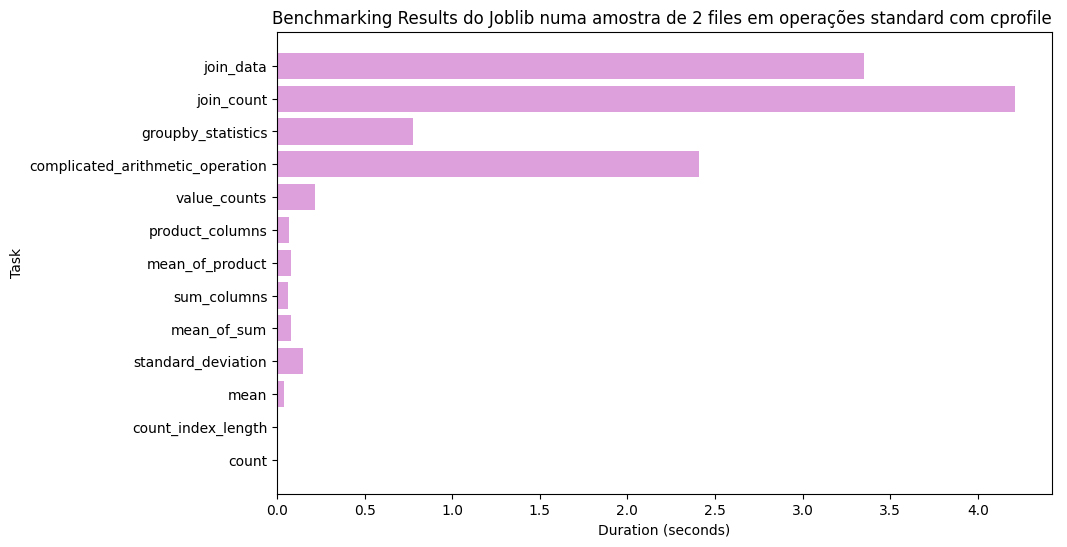

In [140]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.barh(results_joblib2['task'], results_joblib2['duration'], color='plum')
plt.xlabel('Duration (seconds)')
plt.ylabel('Task')
plt.title('Benchmarking Results do Joblib numa amostra de 2 files em operações standard com cprofile ')
plt.show()

### Gráfico de barras horizontais em dados completos com cprofile: Amostra de 3 files

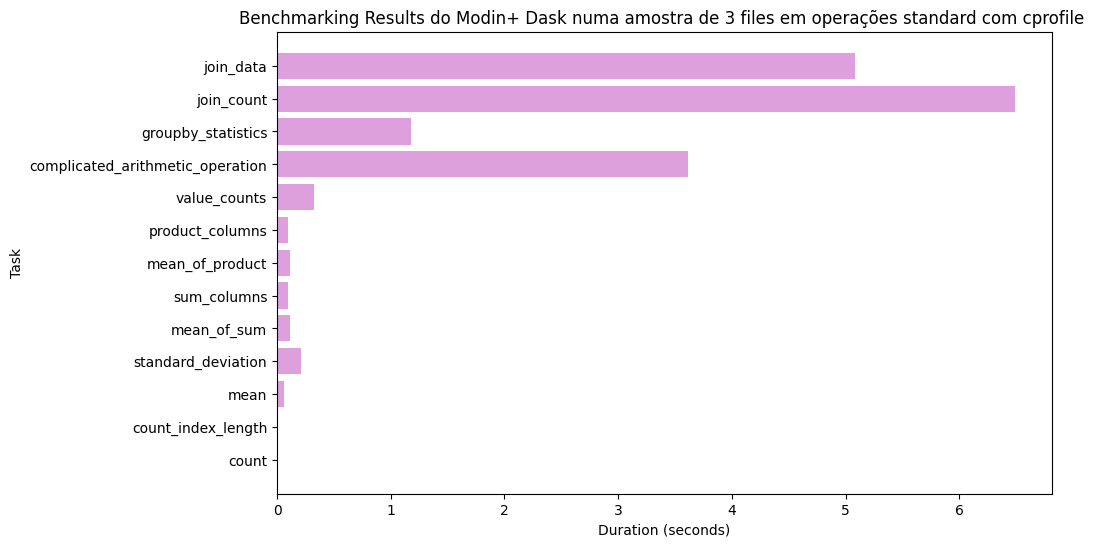

In [141]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.barh(results_joblib3['task'], results_joblib3['duration'], color='plum')
plt.xlabel('Duration (seconds)')
plt.ylabel('Task')
plt.title('Benchmarking Results do Modin+ Dask numa amostra de 3 files em operações standard com cprofile ')
plt.show()

### Gráfico circular em dados completos com cprofile: Amostra de 2 files

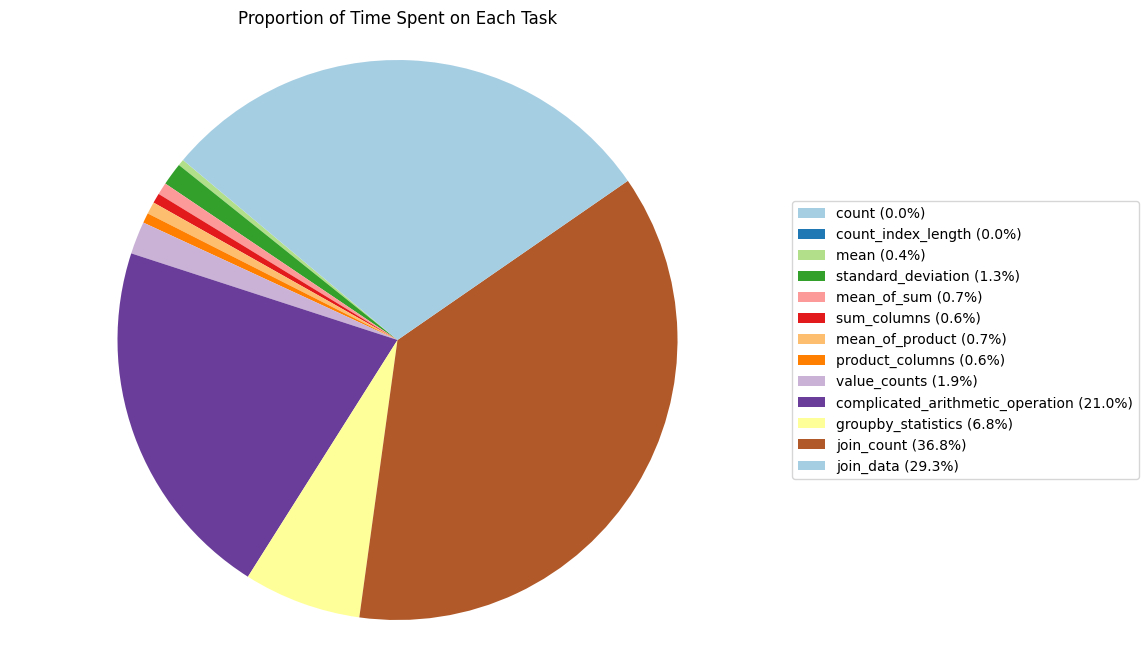

In [142]:
# Calcular percentagens
percentages = [f"{(d / sum(results_joblib2['duration']) * 100):.1f}%" for d in results_joblib2['duration']]
legend_labels = [f"{task} ({percentage})" for task, percentage in zip(results_joblib2['task'], percentages)]

# Definir cores, com 'read file' como rosa
colors = ['plum' if task == 'read file' else color for task, color in zip(results_joblib2['task'], plt.cm.Paired.colors)]

# Gráfico de Pizza sem rótulos nas fatias
explode = [0.1 if i == 0 else 0 for i in range(len(results_joblib2['duration']))]

plt.figure(figsize=(10, 8))
plt.pie(results_joblib2['duration'], startangle=140, colors=colors,
        explode=explode, pctdistance=0.85, labeldistance=1.1)

# Garantir que os rótulos não se sobreponham
plt.axis('equal')
plt.title('Proportion of Time Spent on Each Task')
plt.legend(legend_labels, loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

### Gráfico circular em dados completos com cprofile: Amostra de 3 files

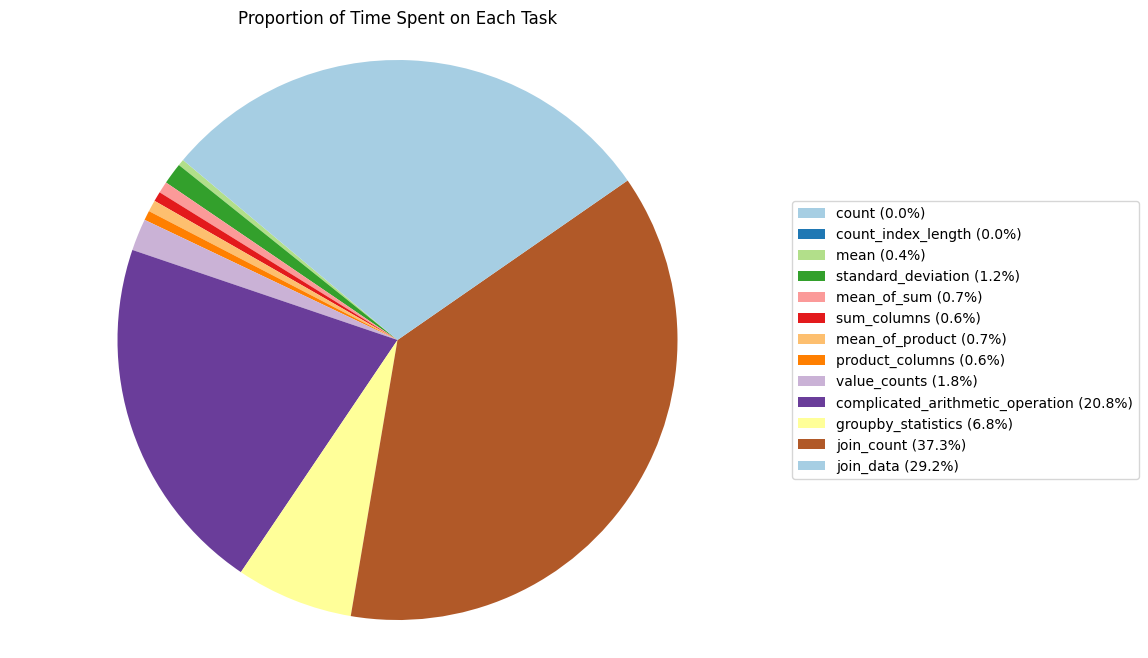

In [143]:
# Calcular percentagens
percentages = [f"{(d / sum(results_joblib3['duration']) * 100):.1f}%" for d in results_joblib3['duration']]
legend_labels = [f"{task} ({percentage})" for task, percentage in zip(results_joblib3['task'], percentages)]

# Definir cores, com 'read file' como rosa
colors = ['plum' if task == 'read file' else color for task, color in zip(results_joblib3['task'], plt.cm.Paired.colors)]

# Gráfico de Pizza sem rótulos nas fatias
explode = [0.1 if i == 0 else 0 for i in range(len(results_joblib3['duration']))]

plt.figure(figsize=(10, 8))
plt.pie(results_joblib3['duration'], startangle=140, colors=colors,
        explode=explode, pctdistance=0.85, labeldistance=1.1)

# Garantir que os rótulos não se sobreponham
plt.axis('equal')
plt.title('Proportion of Time Spent on Each Task')
plt.legend(legend_labels, loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

### Gráfico de linhas em dados completos com cprofile: Amostra de 2 files

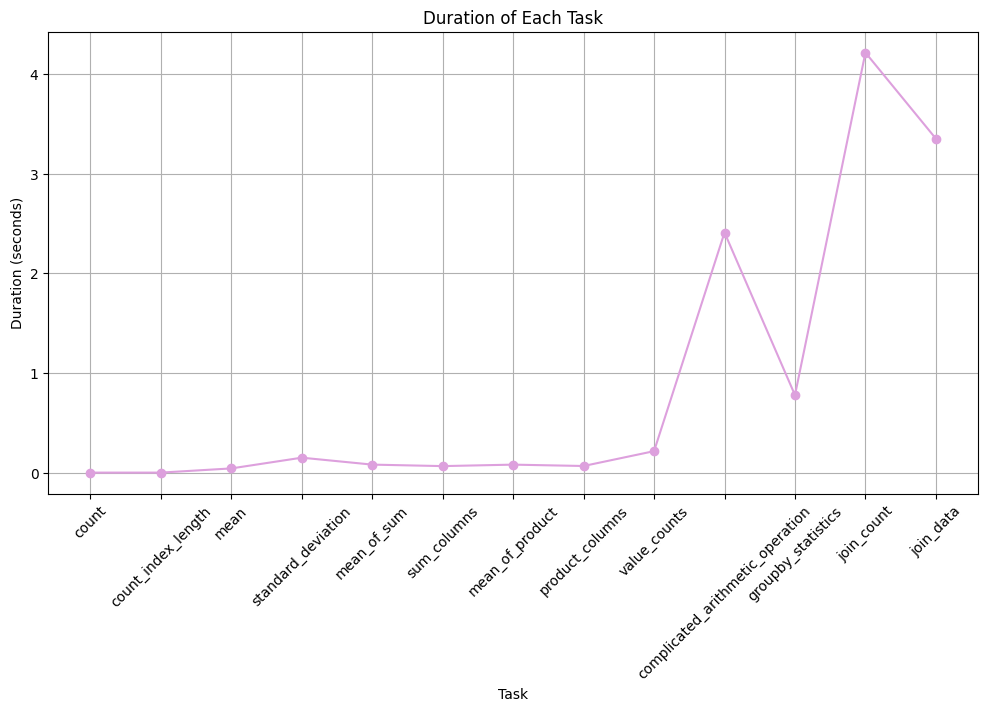

In [144]:
# Gráfico de Linha
plt.figure(figsize=(12, 6))
plt.plot(results_joblib2['task'], results_joblib2['duration'], marker='o', linestyle='-', color='plum')
plt.xlabel('Task')
plt.ylabel('Duration (seconds)')
plt.title('Duration of Each Task')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Gráfico de linhas em dados completos com cprofile: Amostra de 3 files

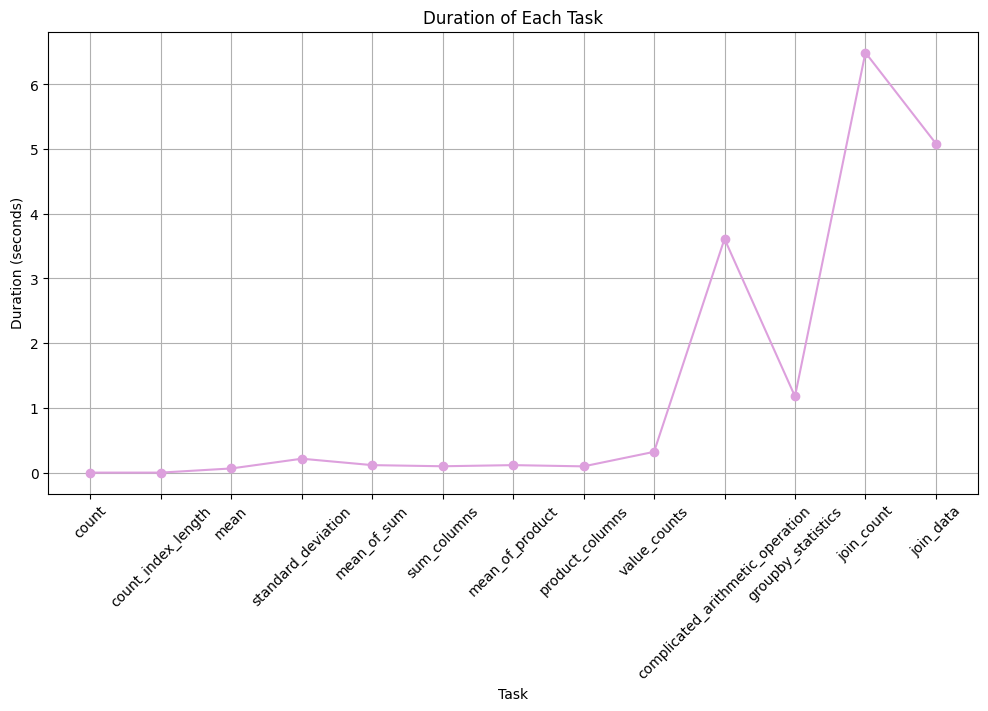

In [145]:
# Gráfico de Linha
plt.figure(figsize=(12, 6))
plt.plot(results_joblib3['task'], results_joblib3['duration'], marker='o', linestyle='-', color='plum')
plt.xlabel('Task')
plt.ylabel('Duration (seconds)')
plt.title('Duration of Each Task')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#### cprofile em operações de filtering

Inicializar dicionários para armazenar resultados dos benchmarks, para ambas as amostras

In [149]:
# Inicializar dicionários para armazenar resultados dos benchmarks
joblib_benchmarks_filtered2_cprofile = {'duration': [], 'task': []}
joblib_benchmarks_filtered3_cprofile = {'duration': [], 'task': []}

Executar benchmarks nas operações com dados filtrados e converter  os resultados das benchmarks para um dataframe, numa amostra de 2 files

In [151]:
# Executar benchmarks nas operações com dados filtrados
execute_benchmarks_cprofile(filtered_data2, joblib_benchmarks_filtered2_cprofile)
# Convert benchmark results to DataFrame
results_joblib2_filtered2 = pd.DataFrame.from_dict(joblib_benchmarks_standard2_cprofile)

count took: 1.9788742065429688e-05 seconds
         42 function calls (40 primitive calls) in 0.000 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.print}
        2    0.000    0.000    0.000    0.000 iostream.py:655(write)
        2    0.000    0.000    0.000    0.000 iostream.py:577(_schedule_flush)
        1    0.000    0.000    0.000    0.000 iostream.py:259(schedule)
        1    0.000    0.000    0.000    0.000 4072466040.py:9(count)
      5/3    0.000    0.000    0.000    0.000 {built-in method builtins.len}
        1    0.000    0.000    0.000    0.000 frame.py:1352(__len__)
        1    0.000    0.000    0.000    0.000 socket.py:626(send)
        2    0.000    0.000    0.000    0.000 iostream.py:550(_is_master_process)
        1    0.000    0.000    0.000    0.000 base.py:794(__len__)
        1    0.000    0.000    0.000    0.000 threading.py

Executar benchmarks nas operações com dados filtrados e converter  os resultados das benchmarks para um dataframe, numa amostra de 3 files

In [152]:
# Executar benchmarks nas operações com dados completos
execute_benchmarks_cprofile(filtered_data3, joblib_benchmarks_filtered3_cprofile)
# Convert benchmark results to DataFrame
results_joblib2_filtered3 = pd.DataFrame.from_dict(joblib_benchmarks_filtered3_cprofile)

count took: 1.8835067749023438e-05 seconds
         42 function calls (40 primitive calls) in 0.000 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.print}
        2    0.000    0.000    0.000    0.000 iostream.py:655(write)
        2    0.000    0.000    0.000    0.000 iostream.py:577(_schedule_flush)
        1    0.000    0.000    0.000    0.000 iostream.py:259(schedule)
        1    0.000    0.000    0.000    0.000 4072466040.py:9(count)
      5/3    0.000    0.000    0.000    0.000 {built-in method builtins.len}
        1    0.000    0.000    0.000    0.000 frame.py:1352(__len__)
        1    0.000    0.000    0.000    0.000 socket.py:626(send)
        1    0.000    0.000    0.000    0.000 base.py:794(__len__)
        2    0.000    0.000    0.000    0.000 iostream.py:550(_is_master_process)
        1    0.000    0.000    0.000    0.000 threading.py

### Gráfico de barras horizontais em dados filtrados com cprofile: Amostra de 2 files

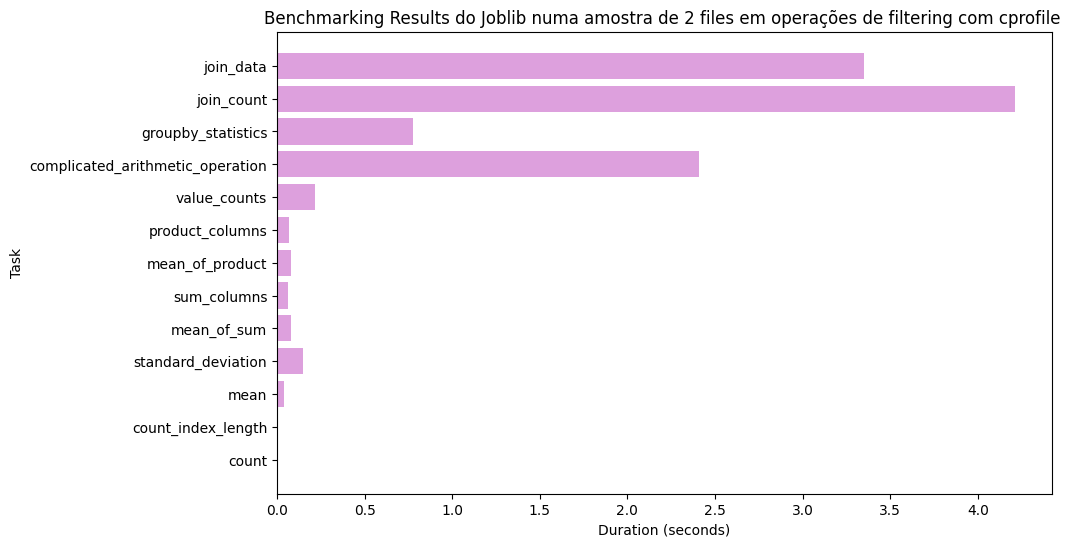

In [153]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.barh(results_joblib2_filtered2['task'], results_joblib2_filtered2['duration'], color='plum')
plt.xlabel('Duration (seconds)')
plt.ylabel('Task')
plt.title('Benchmarking Results do Joblib numa amostra de 2 files em operações de filtering com cprofile ')
plt.show()

### Gráfico de barras horizontais em dados filtrados com cprofile: Amostra de 3 files

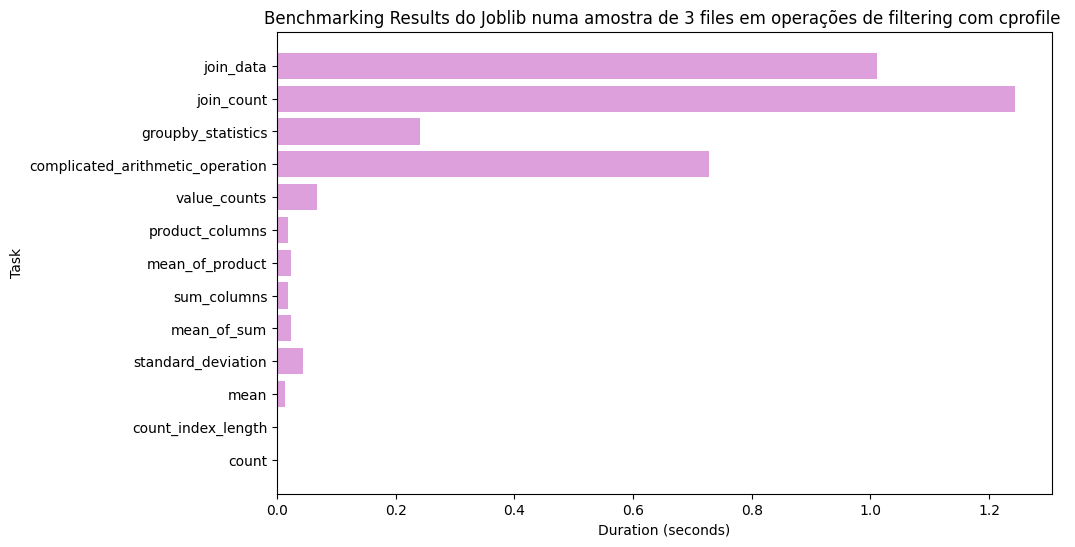

In [154]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.barh(results_joblib2_filtered3['task'], results_joblib2_filtered3['duration'], color='plum')
plt.xlabel('Duration (seconds)')
plt.ylabel('Task')
plt.title('Benchmarking Results do Joblib numa amostra de 3 files em operações de filtering com cprofile ')
plt.show()

### Gráfico circular em dados filtrados com cprofile: Amostra de 2 files

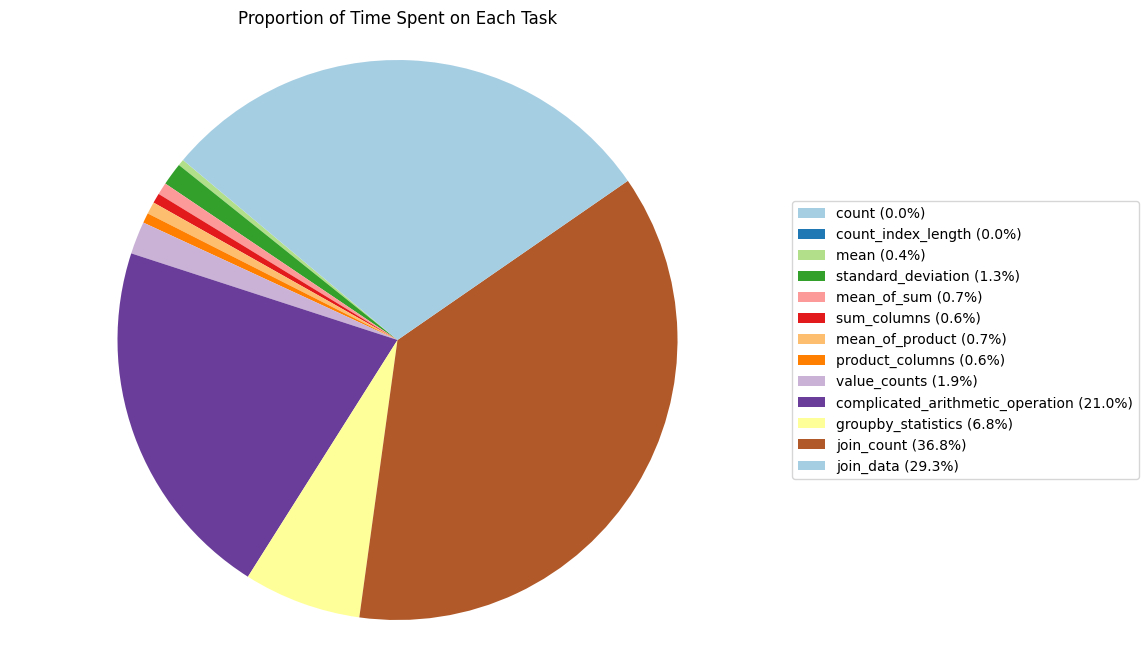

In [155]:
# Calcular percentagens
percentages = [f"{(d / sum(results_joblib2_filtered2['duration']) * 100):.1f}%" for d in results_joblib2_filtered2['duration']]
legend_labels = [f"{task} ({percentage})" for task, percentage in zip(results_joblib2_filtered2['task'], percentages)]

# Definir cores, com 'read file' como rosa
colors = ['plum' if task == 'read file' else color for task, color in zip(results_joblib2_filtered2['task'], plt.cm.Paired.colors)]

# Gráfico de Pizza sem rótulos nas fatias
explode = [0.1 if i == 0 else 0 for i in range(len(results_joblib2_filtered2['duration']))]

plt.figure(figsize=(10, 8))
plt.pie(results_joblib2_filtered2['duration'], startangle=140, colors=colors,
        explode=explode, pctdistance=0.85, labeldistance=1.1)

# Garantir que os rótulos não se sobreponham
plt.axis('equal')
plt.title('Proportion of Time Spent on Each Task')
plt.legend(legend_labels, loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

### Gráfico circular em dados filtrados com cprofile: Amostra de 3 files

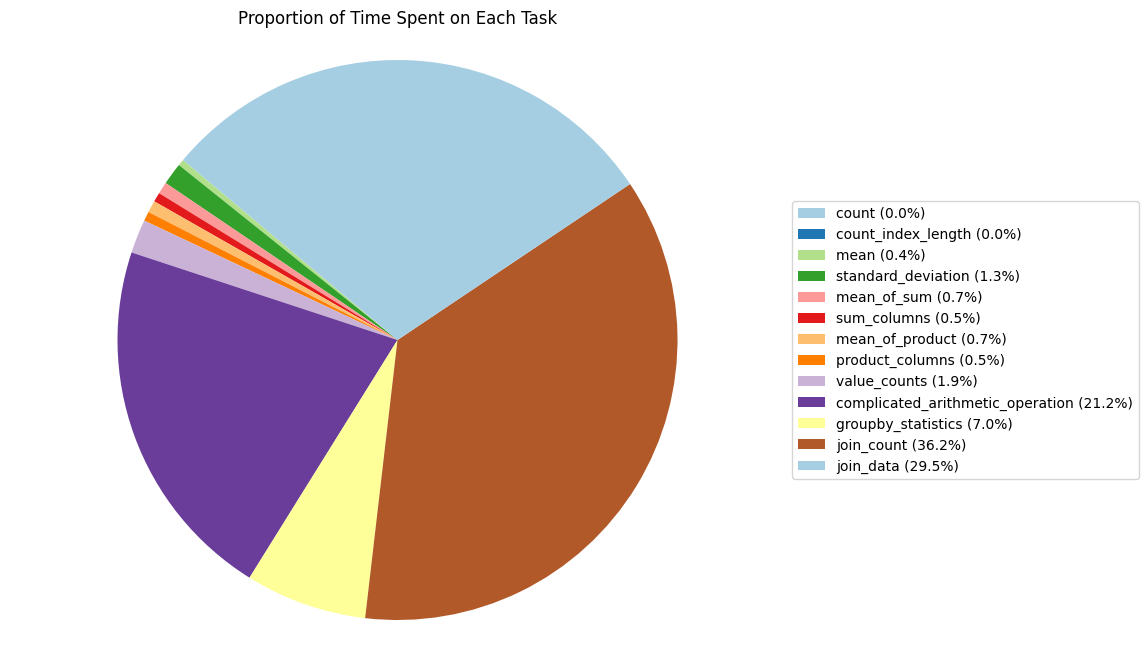

In [156]:
# Calcular percentagens
percentages = [f"{(d / sum(results_joblib2_filtered3['duration']) * 100):.1f}%" for d in results_joblib2_filtered3['duration']]
legend_labels = [f"{task} ({percentage})" for task, percentage in zip(results_joblib2_filtered3['task'], percentages)]

# Definir cores, com 'read file' como rosa
colors = ['plum' if task == 'read file' else color for task, color in zip(results_joblib2_filtered3['task'], plt.cm.Paired.colors)]

# Gráfico de Pizza sem rótulos nas fatias
explode = [0.1 if i == 0 else 0 for i in range(len(results_joblib2_filtered3['duration']))]

plt.figure(figsize=(10, 8))
plt.pie(results_joblib2_filtered3['duration'], startangle=140, colors=colors,
        explode=explode, pctdistance=0.85, labeldistance=1.1)

# Garantir que os rótulos não se sobreponham
plt.axis('equal')
plt.title('Proportion of Time Spent on Each Task')
plt.legend(legend_labels, loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()


### Observações
- **Operações de Junção**: As operações `join_data` e `join_count` foram as mais demoradas em ambos os conjuntos de benchmarks, indicando a complexidade envolvida na junção de grandes conjuntos de dados.
- **Operações Aritméticas Complexas**: A operação `complicated_arithmetic_operation` também apresentou tempos de execução elevados, refletindo a complexidade da tarefa.
- **Desempenho Geral**: Joblib mostrou uma variação considerável nos tempos de execução entre diferentes operações, sugerindo um bom desempenho para tarefas simples e uma necessidade de otimização para tarefas mais complexas.


#### Cprofile em operações de cache

Inicializar dicionários para armazenar resultados dos benchmarks

In [180]:
# Inicializar dicionários para armazenar resultados dos benchmarks
joblib_benchmarks_cache2_cprofile = {'duration': [], 'task': []}
joblib_benchmarks_cache3_cprofile = {'duration': [], 'task': []}

Executar benchmarks nas operações com dados persistidos e converter resultados num dataframe numa amostra de 2 files

In [181]:
# Executar benchmarks nas operações com dados persistidos
execute_benchmarks_cprofile(cached_data2, joblib_benchmarks_cache2_cprofile)
# Convert benchmark results to DataFrame
results_joblib_cache2 = pd.DataFrame.from_dict(joblib_benchmarks_cache2_cprofile)

count took: 1.9550323486328125e-05 seconds
         42 function calls (40 primitive calls) in 0.000 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.print}
        2    0.000    0.000    0.000    0.000 iostream.py:655(write)
        2    0.000    0.000    0.000    0.000 iostream.py:577(_schedule_flush)
        1    0.000    0.000    0.000    0.000 iostream.py:259(schedule)
        1    0.000    0.000    0.000    0.000 4072466040.py:9(count)
      5/3    0.000    0.000    0.000    0.000 {built-in method builtins.len}
        1    0.000    0.000    0.000    0.000 socket.py:626(send)
        1    0.000    0.000    0.000    0.000 frame.py:1352(__len__)
        2    0.000    0.000    0.000    0.000 iostream.py:550(_is_master_process)
        1    0.000    0.000    0.000    0.000 threading.py:1071(is_alive)
        2    0.000    0.000    0.000    0.000 iostr

Executar benchmarks nas operações com dados persistidos e converter resultados num dataframe numa amostra de 3 files

In [182]:
# Executar benchmarks nas operações com dados completos
execute_benchmarks_cprofile(cached_data3, joblib_benchmarks_cache3_cprofile)
# Convert benchmark results to DataFrame
results_joblib_cache3 = pd.DataFrame.from_dict(joblib_benchmarks_cache3_cprofile)

count took: 1.9311904907226562e-05 seconds
         42 function calls (40 primitive calls) in 0.000 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.print}
        2    0.000    0.000    0.000    0.000 iostream.py:655(write)
        2    0.000    0.000    0.000    0.000 iostream.py:577(_schedule_flush)
        1    0.000    0.000    0.000    0.000 iostream.py:259(schedule)
        1    0.000    0.000    0.000    0.000 4072466040.py:9(count)
      5/3    0.000    0.000    0.000    0.000 {built-in method builtins.len}
        1    0.000    0.000    0.000    0.000 socket.py:626(send)
        1    0.000    0.000    0.000    0.000 frame.py:1352(__len__)
        2    0.000    0.000    0.000    0.000 iostream.py:550(_is_master_process)
        1    0.000    0.000    0.000    0.000 base.py:794(__len__)
        1    0.000    0.000    0.000    0.000 threading.py

### Gráfico de barras horizontais em dados persistidos com cprofile: Amostra de 2 files

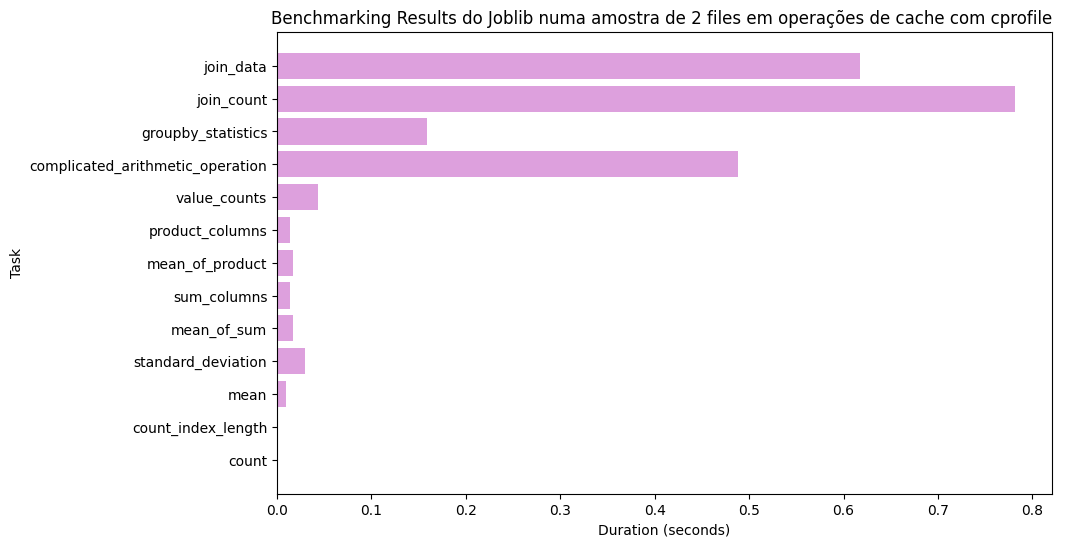

In [183]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.barh(results_joblib_cache2['task'], results_joblib_cache2['duration'], color='plum')
plt.xlabel('Duration (seconds)')
plt.ylabel('Task')
plt.title('Benchmarking Results do Joblib numa amostra de 2 files em operações de cache com cprofile ')
plt.show()

### Gráfico de barras horizontais em dados persistidos com cprofile: Amostra de 3 files

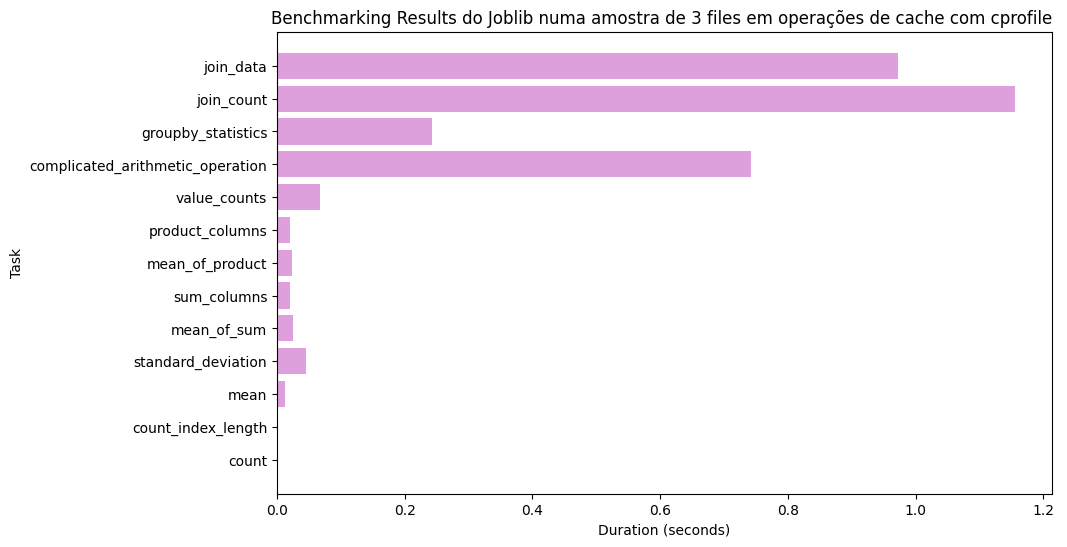

In [184]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.barh(results_joblib_cache3['task'], results_joblib_cache3['duration'], color='plum')
plt.xlabel('Duration (seconds)')
plt.ylabel('Task')
plt.title('Benchmarking Results do Joblib numa amostra de 3 files em operações de cache com cprofile ')
plt.show()

### Gráfico circular em dados persistidos com cprofile: Amostra de 2 files

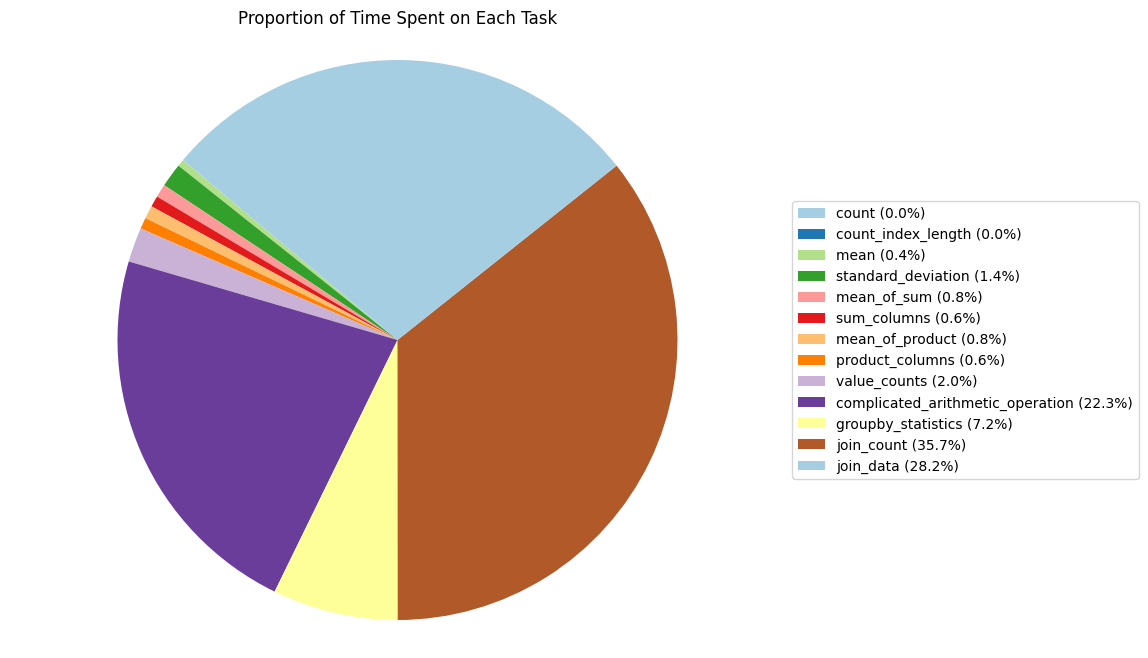

In [185]:
# Calcular percentagens
percentages = [f"{(d / sum(results_joblib_cache2['duration']) * 100):.1f}%" for d in results_joblib_cache2['duration']]
legend_labels = [f"{task} ({percentage})" for task, percentage in zip(results_joblib_cache2['task'], percentages)]

# Definir cores, com 'read file' como rosa
colors = ['plum' if task == 'read file' else color for task, color in zip(results_joblib_cache2['task'], plt.cm.Paired.colors)]

# Gráfico de Pizza sem rótulos nas fatias
explode = [0.1 if i == 0 else 0 for i in range(len(results_joblib_cache2['duration']))]

plt.figure(figsize=(10, 8))
plt.pie(results_joblib_cache2['duration'], startangle=140, colors=colors,
        explode=explode, pctdistance=0.85, labeldistance=1.1)

# Garantir que os rótulos não se sobreponham
plt.axis('equal')
plt.title('Proportion of Time Spent on Each Task')
plt.legend(legend_labels, loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

### Gráfico circular em dados persistidos com cprofile: Amostra de 3 files

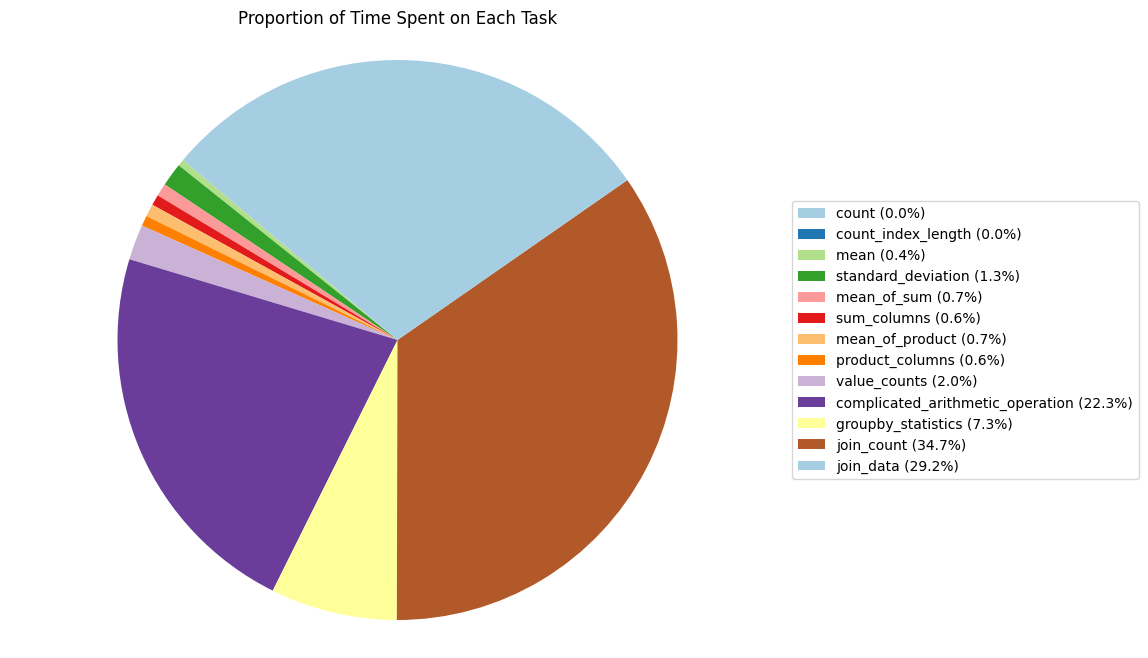

In [186]:
# Calcular percentagens
percentages = [f"{(d / sum(results_joblib_cache3['duration']) * 100):.1f}%" for d in results_joblib_cache3['duration']]
legend_labels = [f"{task} ({percentage})" for task, percentage in zip(results_joblib_cache3['task'], percentages)]

# Definir cores, com 'read file' como rosa
colors = ['plum' if task == 'read file' else color for task, color in zip(results_joblib_cache3['task'], plt.cm.Paired.colors)]

# Gráfico de Pizza sem rótulos nas fatias
explode = [0.1 if i == 0 else 0 for i in range(len(results_joblib_cache3['duration']))]

plt.figure(figsize=(10, 8))
plt.pie(results_joblib_cache3['duration'], startangle=140, colors=colors,
        explode=explode, pctdistance=0.85, labeldistance=1.1)

# Garantir que os rótulos não se sobreponham
plt.axis('equal')
plt.title('Proportion of Time Spent on Each Task')
plt.legend(legend_labels, loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

### Gráfico de linhas em dados persistidos com cprofile: Amostra de 2 files

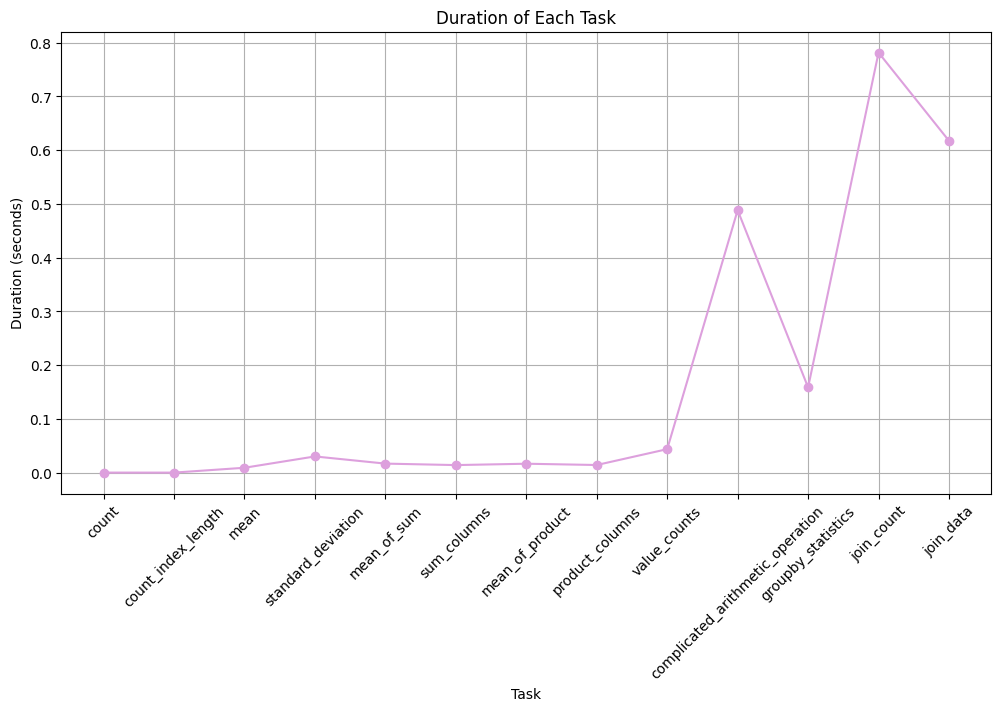

In [187]:
# Gráfico de Linha
plt.figure(figsize=(12, 6))
plt.plot(results_joblib_cache2['task'], results_joblib_cache2['duration'], marker='o', linestyle='-', color='plum')
plt.xlabel('Task')
plt.ylabel('Duration (seconds)')
plt.title('Duration of Each Task')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Gráfico de linhas em dados persistidos com cprofile: Amostra de 2 files

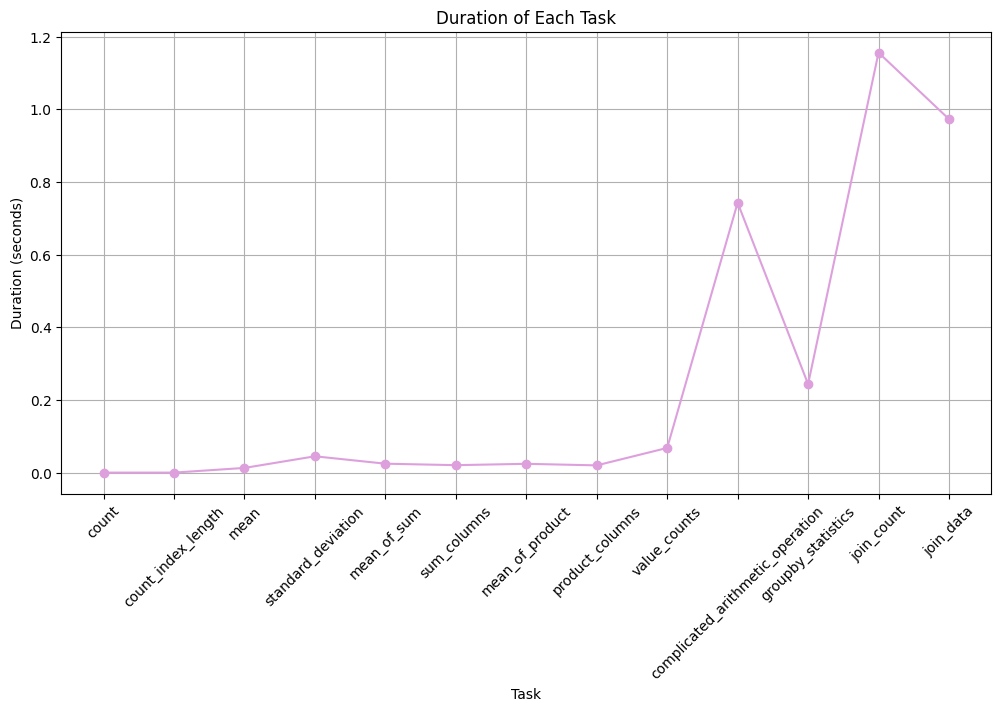

In [188]:
# Gráfico de Linha
plt.figure(figsize=(12, 6))
plt.plot(results_joblib_cache3['task'], results_joblib_cache3['duration'], marker='o', linestyle='-', color='plum')
plt.xlabel('Task')
plt.ylabel('Duration (seconds)')
plt.title('Duration of Each Task')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


#### Gráfico de Barras - Amostra de 2 Arquivos

Este gráfico apresenta os tempos de execução das operações padrão de cache para uma amostra de 2 arquivos usando cProfile com Joblib.

1. **Operações de Junção (join_data e join_count)**: Estas operações tiveram os maiores tempos de execução, com `join_data` e `join_count` dominando a maioria do tempo.
2. **Operação Aritmética Complexa (complicated_arithmetic_operation)**: Esta operação também consumiu uma quantidade significativa de tempo.
3. **Estatísticas de Agrupamento (groupby_statistics)**: Apesar de não ser tão intensiva quanto as operações de junção, ainda representou uma parte significativa do tempo de execução.
4. **Outras Operações**: As operações como `value_counts`, `product_columns`, `mean_of_product`, `sum_columns`, e outras, tiveram tempos de execução relativamente menores.

#### Gráfico de Barras - Amostra de 3 Arquivos

Este gráfico é similar ao anterior, mas foi executado com uma amostra de 3 arquivos.

1. **Operações de Junção (join_data e join_count)**: Continuam sendo as operações mais intensivas em termos de tempo.
2. **Operação Aritmética Complexa (complicated_arithmetic_operation)**: Também representou uma grande parte do tempo de execução.
3. **Estatísticas de Agrupamento (groupby_statistics)**: Teve um tempo de execução significativo, mas menor comparado às operações de junção e operações aritméticas complexas.
4. **Outras Operações**: Novamente, operações menores tiveram tempos de execução reduzidos.

#### Gráfico de Pizza - Proporção do Tempo Gasto em Cada Tarefa

Este gráfico apresenta a proporção de tempo gasto em cada tarefa para a amostra de 2 arquivos.

1. **Operações de Junção (join_data e join_count)**: Juntas, essas operações representam mais de 60% do tempo total de execução.
2. **Operação Aritmética Complexa (complicated_arithmetic_operation)**: Representa cerca de 21% do tempo total de execução.
3. **Estatísticas de Agrupamento (groupby_statistics)**: Representa cerca de 7% do tempo total.
4. **Outras Operações**: Cada uma das outras operações representa uma pequena fração do tempo total.

#### Gráfico de Pizza - Proporção do Tempo Gasto em Cada Tarefa (Amostra de 3 Arquivos)

Este gráfico é similar ao anterior, mas para a amostra de 3 arquivos.

1. **Operações de Junção (join_data e join_count)**: Representam mais de 63% do tempo total de execução.
2. **Operação Aritmética Complexa (complicated_arithmetic_operation)**: Representa cerca de 22% do tempo total de execução.
3. **Estatísticas de Agrupamento (groupby_statistics)**: Representa cerca de 7% do tempo total.
4. **Outras Operações**: Cada uma das outras operações representa uma pequena fração do tempo total.

#### Gráficos de Linha - Duração de Cada Tarefa

Estes gráficos mostram a duração de cada tarefa para as amostras de 2 e 3 arquivos.

1. **Operações de Junção (join_data e join_count)**: Destacam-se claramente como as tarefas mais intensivas em termos de tempo.
2. **Operação Aritmética Complexa (complicated_arithmetic_operation)**: Também se destaca, mas é menos intensiva que as operações de junção.
3. **Estatísticas de Agrupamento (groupby_statistics)**: Tem um tempo de execução significativo, mas menor.
4. **Outras Operações**: Operações como `count`, `mean`, `standard_deviation`, etc., têm tempos de execução muito menores.

### Conclusão

Os gráficos mostram claramente que as operações de junção (`join_data` e `join_count`) são as mais intensivas em termos de tempo, seguidas pelas operações aritméticas complexas e estatísticas de agrupamento. As outras operações, embora necessárias, representam uma fração muito menor do tempo total de execução. 